In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any
import shap
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, TargetEncoder, OneHotEncoder
# from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    classification_report
 )
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
import collections
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# !pip install ipykernel shap category_encoders imbalanced-learn xgboost lightgbm catboost scikit-learn pandas numpy matplotlib seaborn scipy catboost

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define constants and mappings
AGE_INTERVALS = {
    "[0-10)": (0, 10),
    "[10-20)": (10, 20),
    "[20-30)": (20, 30),
    "[30-40)": (30, 40),
    "[40-50)": (40, 50),
    "[50-60)": (50, 60),
    "[60-70)": (60, 70),
    "[70-80)": (70, 80),
    "[80-90)": (80, 90),
    "[90-100)": (90, 100)
}

RACE_ORDER = ["Caucasian", "AfricanAmerican", "Hispanic", "Asian", "Other"]

MED_CHANGE_MAP = {"No": 0, "Steady": 0, "Up": 1, "Down": 1}
A1C_MAP = {"None": 0, "Norm": 1, ">7": 2, ">8": 3}
GLU_MAP = {"None": 0, "Norm": 1, ">200": 2, ">300": 3}
CHANGE_MAP = {"No": 0, "Ch": 1}
DIABETES_MED_MAP = {"No": 0, "Yes": 1}
GENDER_MAP = {"Female": 0, "Male": 1}
HOME_DISCHARGE = {1, 6}
TRANSFER_DISCHARGE = {2, 3, 4, 5, 8, 9, 10, 15, 16, 17, 22, 23, 24, 25, 26, 30}
STILL_PATIENT_DISCHARGE = {12}
NOT_AVAILABLE_DISCHARGE = {18}
EXCLUDE_DISCHARGE = {11, 13, 14, 19, 20, 21}
EMERGENCY_ADMISSION = {1, 2, 7}
ELECTIVE_ADMISSION = {3}
NEWBORN_ADMISSION = {4}
NOT_AVAILABLE_ADMISSION = {5, 6, 8}
EMERGENCY_SOURCE = {7}
REFERRAL_SOURCE = {1, 2, 3}
TRANSFER_SOURCE = {4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26}
NOT_AVAILABLE_SOURCE = {9, 17}

def generate_age_numeric(age_series, seed=42):
    rng = np.random.default_rng(seed)
    numeric_ages = []
    for label in age_series:
        if pd.isna(label):
            numeric_ages.append(np.nan)
            continue
        interval = AGE_INTERVALS.get(label)
        if interval is None:
            numeric_ages.append(np.nan)
            continue
        low, high = interval
        numeric_ages.append(int(rng.integers(low, high)))
    return numeric_ages

def bucket_admission_type(value):
    if pd.isna(value):
        return np.nan
    value = int(value)
    if value in EMERGENCY_ADMISSION:
        return 0
    if value in ELECTIVE_ADMISSION:
        return 1
    if value in NEWBORN_ADMISSION:
        return 2
    if value in NOT_AVAILABLE_ADMISSION:
        return 3
    return 4

def bucket_discharge(value):
    if pd.isna(value):
        return np.nan
    value = int(value)
    if value in HOME_DISCHARGE:
        return 0
    if value in TRANSFER_DISCHARGE:
        return 1
    if value in STILL_PATIENT_DISCHARGE:
        return 2
    if value == 7:  # Left AMA
        return 3
    if value in NOT_AVAILABLE_DISCHARGE:
        return 4
    return 5

def bucket_admission_source(value):
    if pd.isna(value):
        return np.nan
    value = int(value)
    if value in EMERGENCY_SOURCE:
        return 0
    if value in REFERRAL_SOURCE:
        return 1
    if value in TRANSFER_SOURCE:
        return 2
    if value in NOT_AVAILABLE_SOURCE:
        return 3
    return 4

def map_icd9_to_group(code):
    if pd.isna(code):
        return 0
    code_str = str(code)
    if code_str.startswith('V') or code_str.startswith('E') or code_str == '-1':
        return 0
    try:
        code_val = float(code_str)
    except ValueError:
        return 0
    if 390 <= code_val < 460 or code_val == 785:
        return 1  # Circulatory system
    if 460 <= code_val < 520 or code_val == 786:
        return 2  # Respiratory system
    if 520 <= code_val < 580 or code_val == 787:
        return 3  # Digestive system
    if 250 <= code_val < 251:
        return 4  # Diabetes
    if 800 <= code_val < 1000:
        return 5  # Injury
    if 710 <= code_val < 740:
        return 6  # Musculoskeletal
    if 580 <= code_val < 630:
        return 7  # Genitourinary
    if 140 <= code_val < 240:
        return 8  # Neoplasms
    if 240 <= code_val < 280:
        return 9  # Endocrine/metabolic
    if 680 <= code_val < 710:
        return 10  # Skin/subcutaneous
    if 320 <= code_val < 390:
        return 11  # Nervous system
    if 280 <= code_val < 320:
        return 12  # Blood diseases
    if 630 <= code_val < 680:
        return 13  # Pregnancy/childbirth
    if 740 <= code_val < 760:
        return 14  # Congenital anomalies
    if 760 <= code_val < 780:
        return 15  # Perinatal period
    if 780 <= code_val < 785:
        return 16  # Symptoms
    if 120 <= code_val < 140:
        return 17  # Infectious and parasitic
    return 18  # Residual/other

def encode_race(series):
    cleaned = series.fillna('Other').replace('?', 'Other')
    mapped = cleaned.apply(lambda x: RACE_ORDER.index(x) if x in RACE_ORDER else len(RACE_ORDER))
    return mapped

In [3]:
def prepare_paper_feature_set(df_raw):
    data = df_raw.copy()
    data = data.replace('?', np.nan)

    # Remove newborn admissions and excluded discharge categories
    if 'admission_type_id' in data.columns:
        data = data[~data['admission_type_id'].isin(NEWBORN_ADMISSION)]
    if 'discharge_disposition_id' in data.columns:
        data = data[~data['discharge_disposition_id'].isin(EXCLUDE_DISCHARGE)]

    # Drop identifiers and high-missing features that the report discards
    drop_cols = [
        'weight', 'payer_code', 'medical_specialty',
        'examide', 'citoglipton', 'glyburide-metformin', 'glipizide-metformin',
        'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
    ]
    data = data.drop(columns=[col for col in drop_cols if col in data.columns])

    # Basic imputations
    if 'race' in data.columns:
        data['race'] = data['race'].fillna(data['race'].mode()[0])
    diag_cols = ['diag_1', 'diag_2', 'diag_3']
    for col in diag_cols:
        if col in data.columns:
            data[col] = data[col].fillna('-1')

    # Grouped categorical encodings
    data['admission_type_group'] = data['admission_type_id'].apply(bucket_admission_type)
    data['discharge_disposition_group'] = data['discharge_disposition_id'].apply(bucket_discharge)
    data['admission_source_group'] = data['admission_source_id'].apply(bucket_admission_source)

    # Prior year utilization (sum of outpatient, emergency, inpatient visits)
    utilization_cols = ['number_outpatient', 'number_emergency', 'number_inpatient']
    for col in utilization_cols:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce').fillna(0)
        else:
            data[col] = 0
    data['prior_year_visits'] = data[utilization_cols].sum(axis=1)

    # Medication change flags
    for med in ['insulin', 'metformin', 'glipizide', 'glyburide']:
        if med in data.columns:
            data[f'{med}_change_flag'] = data[med].map(MED_CHANGE_MAP).fillna(0).astype(int)
        else:
            data[f'{med}_change_flag'] = 0

    # Ordinal encodings for lab results and medication program
    data['A1Cresult_ord'] = data['A1Cresult'].map(A1C_MAP).fillna(0).astype(int)
    data['max_glu_serum_ord'] = data['max_glu_serum'].map(GLU_MAP).fillna(0).astype(int)
    data['change_flag'] = data['change'].map(CHANGE_MAP).fillna(0).astype(int)
    data['diabetesMed_flag'] = data['diabetesMed'].map(DIABETES_MED_MAP).fillna(0).astype(int)

    # Demographic encodings
    data = data[data['gender'] != 'Unknown/Invalid']
    data['gender_flag'] = data['gender'].map(GENDER_MAP).fillna(0).astype(int)
    data['race_ord'] = encode_race(data['race']).astype(int)
    data['age_numeric'] = generate_age_numeric(data['age'])

    # Diagnosis groupings
    for col in diag_cols:
        data[f'{col}_group'] = data[col].apply(map_icd9_to_group).astype(int)

    return data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway, kruskal
import warnings
warnings.filterwarnings('ignore')

def analyze_feature_distributions(df, target_column, figsize=(15, 5), alpha=0.05, max_categories=100):
    """
    Analyze distributions of all features against target column categories.

    Parameters:
    -----------
    df : pandas DataFrame
        The input dataframe
    target_column : str
        Name of the target column
    figsize : tuple
        Figure size for plots (width, height)
    alpha : float
        Significance level for statistical tests
    max_categories : int
        Maximum number of unique values for categorical features (default: 100)

    Returns:
    --------
    results_df : pandas DataFrame
        Statistical test results ranked by significance
    """

    # Get feature columns (all except target)
    feature_columns = [col for col in df.columns if col != target_column]

    # Get unique target categories
    target_categories = df[target_column].unique()
    n_categories = len(target_categories)

    print(f"Target column: {target_column}")
    print(f"Target categories: {target_categories}")
    print(f"Number of features: {len(feature_columns)}\n")

    # Store statistical test results
    test_results = []
    skipped_features = []

    # Analyze each feature
    for feature in feature_columns:
        print(f"\n{'='*80}")
        print(f"Analyzing: {feature}")
        print(f"{'='*80}")

        # Check if feature is numeric or categorical
        is_numeric = pd.api.types.is_numeric_dtype(df[feature])

        # Remove missing values for this analysis
        feature_data = df[[feature, target_column]].dropna()

        if len(feature_data) == 0:
            print(f"Warning: No valid data for {feature}")
            skipped_features.append((feature, "No valid data"))
            continue

        # Check number of unique values
        n_unique = feature_data[feature].nunique()

        # Skip if too many categories (likely ID column or problematic feature)
        if n_unique > max_categories:
            print(f"⚠️  SKIPPING: Feature has {n_unique} unique values (> {max_categories})")
            print(f"   This feature likely represents IDs or has too many categories for meaningful analysis.")
            skipped_features.append((feature, f"{n_unique} unique values (> {max_categories})"))
            continue

        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle(f'{feature} Distribution by {target_column}', fontsize=14, fontweight='bold')

        if is_numeric:
            # ============ NUMERIC FEATURES ============

            # Prepare data for each category
            groups = [feature_data[feature_data[target_column] == cat][feature].values
                     for cat in target_categories]

            # Plot 1: Overlapping histograms
            for cat in target_categories:
                data_subset = feature_data[feature_data[target_column] == cat][feature]
                axes[0].hist(data_subset, alpha=0.5, label=f'{cat} (n={len(data_subset)})',
                           bins=30, edgecolor='black')
            axes[0].set_xlabel(feature)
            axes[0].set_ylabel('Frequency')
            axes[0].set_title('Overlapping Histograms')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)

            # Plot 2: Box plots
            feature_data.boxplot(column=feature, by=target_column, ax=axes[1])
            axes[1].set_xlabel(target_column)
            axes[1].set_ylabel(feature)
            axes[1].set_title('Box Plots by Category')
            plt.sca(axes[1])
            plt.xticks(rotation=45)

            # Plot 3: Violin plots
            for i, cat in enumerate(target_categories):
                data_subset = feature_data[feature_data[target_column] == cat][feature]
                parts = axes[2].violinplot([data_subset], positions=[i],
                                          showmeans=True, showmedians=True)
            axes[2].set_xticks(range(len(target_categories)))
            axes[2].set_xticklabels(target_categories, rotation=45)
            axes[2].set_xlabel(target_column)
            axes[2].set_ylabel(feature)
            axes[2].set_title('Violin Plots')
            axes[2].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            # Statistical tests for numeric features
            # Remove groups with insufficient data
            valid_groups = [g for g in groups if len(g) > 0]

            if len(valid_groups) < 2:
                print(f"Insufficient groups for statistical testing")
                skipped_features.append((feature, "Insufficient groups"))
                continue

            # Print descriptive statistics
            print("\nDescriptive Statistics:")
            print(feature_data.groupby(target_column)[feature].describe())

            # Choose appropriate test based on number of categories
            if n_categories == 2:
                # Two groups: t-test or Mann-Whitney U
                # Check normality (Shapiro-Wilk test)
                normality_pvals = [stats.shapiro(g)[1] if len(g) >= 3 else 0
                                  for g in valid_groups]

                if all(p > 0.05 for p in normality_pvals):
                    # Use parametric test (t-test)
                    stat, p_value = stats.ttest_ind(valid_groups[0], valid_groups[1])
                    test_name = "Independent t-test"
                else:
                    # Use non-parametric test (Mann-Whitney U)
                    stat, p_value = stats.mannwhitneyu(valid_groups[0], valid_groups[1])
                    test_name = "Mann-Whitney U test"
            else:
                # More than two groups: ANOVA or Kruskal-Wallis
                # Check normality
                normality_pvals = [stats.shapiro(g)[1] if len(g) >= 3 else 0
                                  for g in valid_groups]

                if all(p > 0.05 for p in normality_pvals):
                    # Use parametric test (ANOVA)
                    stat, p_value = f_oneway(*valid_groups)
                    test_name = "One-way ANOVA"
                else:
                    # Use non-parametric test (Kruskal-Wallis)
                    stat, p_value = kruskal(*valid_groups)
                    test_name = "Kruskal-Wallis H test"

            # Calculate effect size (for 2 groups: Cohen's d, for >2: eta-squared)
            if n_categories == 2:
                mean_diff = np.mean(valid_groups[0]) - np.mean(valid_groups[1])
                pooled_std = np.sqrt((np.var(valid_groups[0]) + np.var(valid_groups[1])) / 2)
                effect_size = mean_diff / pooled_std if pooled_std > 0 else 0
                effect_name = "Cohen's d"
            else:
                # Eta-squared for ANOVA
                grand_mean = np.mean(np.concatenate(valid_groups))
                ss_between = sum(len(g) * (np.mean(g) - grand_mean)**2 for g in valid_groups)
                ss_total = sum((x - grand_mean)**2 for g in valid_groups for x in g)
                effect_size = ss_between / ss_total if ss_total > 0 else 0
                effect_name = "Eta-squared"

        else:
            # ============ CATEGORICAL FEATURES ============

            # Create contingency table
            contingency_table = pd.crosstab(feature_data[feature],
                                           feature_data[target_column])

            # Plot 1: Stacked bar chart (counts)
            contingency_table.plot(kind='bar', stacked=False, ax=axes[0],
                                  edgecolor='black')
            axes[0].set_xlabel(feature)
            axes[0].set_ylabel('Count')
            axes[0].set_title('Count Distribution')
            axes[0].legend(title=target_column)
            axes[0].grid(True, alpha=0.3)
            plt.sca(axes[0])
            plt.xticks(rotation=45, ha='right')

            # Plot 2: Normalized stacked bar chart (proportions within feature)
            contingency_norm = contingency_table.div(contingency_table.sum(axis=1), axis=0)
            contingency_norm.plot(kind='bar', stacked=True, ax=axes[1],
                                 edgecolor='black')
            axes[1].set_xlabel(feature)
            axes[1].set_ylabel('Proportion')
            axes[1].set_title('Proportions within Feature Category')
            axes[1].legend(title=target_column)
            axes[1].grid(True, alpha=0.3)
            plt.sca(axes[1])
            plt.xticks(rotation=45, ha='right')

            # Plot 3: Grouped bar chart
            contingency_table.T.plot(kind='bar', ax=axes[2], edgecolor='black')
            axes[2].set_xlabel(target_column)
            axes[2].set_ylabel('Count')
            axes[2].set_title('Count by Target Category')
            axes[2].legend(title=feature, bbox_to_anchor=(1.05, 1))
            axes[2].grid(True, alpha=0.3)
            plt.sca(axes[2])
            plt.xticks(rotation=45, ha='right')

            plt.tight_layout()
            plt.show()

            # Chi-square test
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            test_name = "Chi-square test"
            stat = chi2

            # Cramér's V as effect size
            n = contingency_table.sum().sum()
            min_dim = min(contingency_table.shape[0] - 1, contingency_table.shape[1] - 1)
            effect_size = np.sqrt(chi2 / (n * min_dim))
            effect_name = "Cramér's V"

            print("\nContingency Table:")
            print(contingency_table)
            print("\nProportions:")
            print(contingency_norm)

        # Print test results
        print(f"\n{test_name}:")
        print(f"  Test Statistic: {stat:.4f}")
        print(f"  P-value: {p_value:.4e}")
        print(f"  {effect_name}: {effect_size:.4f}")
        print(f"  Significant at α={alpha}: {'Yes' if p_value < alpha else 'No'}")

        # Store results
        test_results.append({
            'Feature': feature,
            'Type': 'Numeric' if is_numeric else 'Categorical',
            'N_Unique': n_unique,
            'Test': test_name,
            'Test_Statistic': stat,
            'P_Value': p_value,
            'Effect_Size': effect_size,
            'Effect_Measure': effect_name,
            'Significant': p_value < alpha,
            'Rank_Score': -np.log10(p_value) if p_value > 0 else np.inf
        })

    # Create results dataframe
    results_df = pd.DataFrame(test_results)
    results_df = results_df.sort_values('P_Value')

    # Print skipped features summary
    if skipped_features:
        print("\n" + "="*80)
        print("SKIPPED FEATURES:")
        print("="*80)
        for feat, reason in skipped_features:
            print(f"  • {feat}: {reason}")

    # Print summary
    print("\n" + "="*80)
    print("SUMMARY: Features Ranked by Statistical Significance")
    print("="*80)
    print(results_df.to_string(index=False))

    # Visualize p-values
    plt.figure(figsize=(12, 6))
    colors = ['green' if sig else 'red' for sig in results_df['Significant']]
    plt.barh(results_df['Feature'], -np.log10(results_df['P_Value']), color=colors, alpha=0.7)
    plt.axvline(x=-np.log10(alpha), color='black', linestyle='--',
                label=f'Significance threshold (α={alpha})')
    plt.xlabel('-log10(P-Value)', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Feature Discriminating Power (Higher = More Significant)', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

    return results_df



In [5]:
def create_safe_patient_history_features(df):
    """
    Create patient history features WITHOUT data leakage

    Key principles to avoid leakage:
    1. Only use information from PRIOR encounters (not current or future)
    2. Use temporal ordering (encounter_id as proxy for time)
    3. Use .shift() to exclude current encounter from aggregations

    Returns: DataFrame with new history features
    """
    df = df.copy()
    original_columns = set(df.columns)

    # Sort by patient and encounter (encounter_id is chronological proxy)
    remove_patient_nbr_list = [493038, 23611986, 23738805, 67099194, 84365577, 89947233, 42491844, 33665094, 43466490, 42055272, 108707976, 39583782, 54686619, 33581808, 41325552, 151756061, 94422375, 32337963]
    df = df.sort_values(['patient_nbr', 'encounter_id']).reset_index(drop=True)
    df = df[~df['patient_nbr'].isin(remove_patient_nbr_list)]

    print("Creating patient history features (avoiding temporal leakage)...")

    # 1. Count of prior encounters (excluding current)
    df['prior_encounter_count'] = df.groupby('patient_nbr').cumcount()

    # 2. Prior readmission history (using .shift to exclude current encounter)
    # Use readmitted_binary if available, otherwise create it
    if 'readmitted_binary' not in df.columns:
        print("  ⚠️  Warning: readmitted_binary not found, creating it (<30 days = 1)")
        df['readmitted_binary'] = (df['readmitted'] == '<30').astype(int)

    # # Count of prior 30-day readmissions (high risk - our target)
    df['prior_30day_readmission_count'] = (
        df.groupby('patient_nbr')['readmitted_binary']
        .shift(1)  # Exclude current encounter
        .fillna(0)
        .groupby(df['patient_nbr'])
        .cumsum()
    )

    # Also track any readmission (not just <30 days) for additional context
    df['was_readmitted_any'] = (df['readmitted'] != 'NO').astype(int)
    df['prior_was_readmitted_any'] = (
        df.groupby('patient_nbr')['was_readmitted_any']
        .shift(1)
        .fillna(0)
        .astype(int)
    )
    df['prior_any_readmission_count'] = (
        df.groupby('patient_nbr')['was_readmitted_any']
        .shift(1)  # Exclude current encounter
        .fillna(0)
        .groupby(df['patient_nbr'])
        .cumsum()
    )

    # 3. Prior total inpatient visits (cumulative)
    df['prior_total_inpatient'] = (
        df.groupby('patient_nbr')['number_inpatient']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .cumsum()
    )

    # 4. Prior total emergency visits
    df['prior_total_emergency'] = (
        df.groupby('patient_nbr')['number_emergency']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .cumsum()
    )

    # 5. Prior total outpatient visits
    df['prior_total_outpatient'] = (
        df.groupby('patient_nbr')['number_outpatient']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .cumsum()
    )

    # 6. Average time in hospital for prior encounters
    df['prior_avg_time_in_hospital'] = (
        df.groupby('patient_nbr')['time_in_hospital']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )

    # 7. Prior medication count (number of medications prescribed)
    df['prior_avg_num_medications'] = (
        df.groupby('patient_nbr')['num_medications']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )

    # 8. Prior lab procedures count
    df['prior_avg_num_lab_procedures'] = (
        df.groupby('patient_nbr')['num_lab_procedures']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )

    # 9. Prior diagnosis count
    df['prior_avg_number_diagnoses'] = (
        df.groupby('patient_nbr')['number_diagnoses']
        .shift(1)
        .fillna(0)
        .groupby(df['patient_nbr'])
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )

    # 10. Is this a returning patient? (binary flag)
    df['is_returning_patient'] = (df['prior_encounter_count'] > 0).astype(int)

    # # 11. Prior 30-day readmission rate (for returning patients)
    df['prior_30day_readmission_rate'] = df.apply(
        lambda row: row['prior_30day_readmission_count'] / row['prior_encounter_count']
        if row['prior_encounter_count'] > 0 else 0, axis=1
    )

    # ========== NEW ADVANCED FEATURES ==========

    # 12. Polypharmacy risk score (exponential risk above 5 medications)
    df['polypharmacy_risk'] = df['num_medications'].apply(
        lambda x: np.exp((x - 5) / 10) if x > 5 else 0
    )

    # 13. Medication count change from history
    df['medication_count_change'] = (
        df['num_medications'] - df['prior_avg_num_medications']
    )

    # 14. High-risk medication combination (Insulin + diabetes meds + anticoagulants proxy)
    # Using num_medications > 15 as proxy for complex medication regimen
    diabetes_med_cols = ['insulin', 'metformin', 'glipizide', 'glyburide', 'glimepiride']
    if any(col in df.columns for col in diabetes_med_cols):
        df['has_diabetes_meds'] = df[[col for col in diabetes_med_cols if col in df.columns]].apply(
            lambda row: (row != 'No').any() and (row != 'Steady').any(), axis=1
        ).astype(int)
        df['high_risk_med_combo'] = (
            (df['has_diabetes_meds'] == 1) & (df['num_medications'] > 10)
        ).astype(int)
    else:
        # Fallback if medication columns not available
        df['high_risk_med_combo'] = (df['num_medications'] > 15).astype(int)

    # 15. Healthcare utilization trend (acceleration indicator)
    df['healthcare_utilization_trend'] = df.apply(
        lambda row: (row['number_emergency'] + row['number_inpatient']) / max(row['prior_encounter_count'], 1),
        axis=1
    )

    # 16. High-confidence readmission signal
    # Prior 30-day readmission + emergency + long stay + high medications
    df['high_confidence_readmission'] = (
        (df['prior_30day_readmission_count'] > 0) &
        (df['admission_type_id'] == 1) &  # Emergency admission
        (df['time_in_hospital'] >= 7) &
        (df['num_medications'] > 15)
    ).astype(int)

    # 17. Low-risk exclusion features
    # Young + no complications + short stay + elective
    age_numeric = df['age'].map({
        '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
        '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
        '[80-90)': 85, '[90-100)': 95
    }) if 'age' in df.columns else 50  # Default to middle age if not available

    df['high_risk_profile'] = (
        (age_numeric > 50) &
        (df['number_diagnoses'] > 5) &
        (df['time_in_hospital'] > 3) &
        (df['discharge_disposition_id'].isin([11, 13, 14, 19, 20, 21]))
    ).astype(int)

    # 18. Log transformations for skewed distributions
    df['log_prior_encounter_count'] = np.log1p(df['prior_encounter_count'])
    df['log_num_procedures'] = np.log1p(df['num_procedures'])

    # 19. Cross features between discharge disposition and medications
    # High medication count at risky discharge destinations
    risky_discharge_ids = [1, 6, 7, 13]  # Home, home with service, AMA, hospice/home
    if 'discharge_disposition_id' in df.columns:
        df['risky_discharge_high_meds'] = (
            (df['discharge_disposition_id'].isin(risky_discharge_ids)) &
            (df['num_medications'] > 10)
        ).astype(int)
    else:
        df['risky_discharge_high_meds'] = 0

    # 20. Number of unique diagnosis groups from all historic visits
    # Count unique diagnosis groups seen across patient history
    df['historic_unique_diag_groups'] = 0  # Initialize

    diag_group_cols = ['diag_1_group', 'diag_2_group', 'diag_3_group']
    if all(col in df.columns for col in diag_group_cols):
        # For each patient, track unique diagnosis groups from prior encounters
        for patient in df['patient_nbr'].unique():
            patient_mask = df['patient_nbr'] == patient
            patient_data = df[patient_mask].copy()

            # For each encounter, count unique diagnoses from ALL prior encounters
            unique_counts = []
            for idx in range(len(patient_data)):
                if idx == 0:
                    unique_counts.append(0)  # First encounter has no history
                else:
                    # Get all diagnoses from prior encounters
                    prior_diags = set()
                    for i in range(idx):
                        prior_diags.update([
                            patient_data.iloc[i]['diag_1_group'],
                            patient_data.iloc[i]['diag_2_group'],
                            patient_data.iloc[i]['diag_3_group']
                        ])
                    prior_diags.discard('Unknown')  # Remove unknowns
                    prior_diags.discard(None)
                    unique_counts.append(len(prior_diags))

            df.loc[patient_mask, 'historic_unique_diag_groups'] = unique_counts


    if all(col in df.columns for col in diag_group_cols):
        def _clean_diag(value):
            if pd.isna(value):
                return np.nan
            val = str(value).strip()
            if val.lower() in {'unknown', 'nan', 'none', ''}:
                return np.nan
            return val

        records = []
        for patient, patient_df in df.groupby('patient_nbr', sort=False):
            last_readmitted_diags = [np.nan, np.nan, np.nan]
            prior_readmitted_union: set[str] = set()
            patient_rows = []
            for _, row in patient_df.iterrows():
                current_diags = [_clean_diag(row[col]) for col in diag_group_cols]
                current_diag_set = {val for val in current_diags if pd.notna(val)}

                overlap = prior_readmitted_union & current_diag_set
                patient_rows.append({
                    'prior_readmitted_diag_1_group': last_readmitted_diags[0],
                    'prior_readmitted_diag_2_group': last_readmitted_diags[1],
                    'prior_readmitted_diag_3_group': last_readmitted_diags[2],
                    'prior_readmitted_diag_match_flag': int(bool(overlap)),
                    'prior_readmitted_diag_match_count': len(overlap)
                })

                if row['readmitted_binary'] == 1:
                    last_readmitted_diags = current_diags
                    prior_readmitted_union.update(current_diag_set)
            records.append(pd.DataFrame(patient_rows, index=patient_df.index))
        diag_history = pd.concat(records).sort_index()
        df = df.join(diag_history)
    else:
        df['prior_readmitted_diag_1_group'] = np.nan
        df['prior_readmitted_diag_2_group'] = np.nan
        df['prior_readmitted_diag_3_group'] = np.nan
        df['prior_readmitted_diag_match_flag'] = 0
        df['prior_readmitted_diag_match_count'] = 0

    new_feature_names = sorted(set(df.columns) - original_columns)
    print(f"✓ Created {len(new_feature_names)} patient history features without data leakage")
    print(f"  - All features use only PRIOR encounters (via .shift(1))")
    print(f"  - First encounter for each patient has 0/NaN values (no prior history)")
    print(f"  - Uses readmitted_binary (30-day readmission) as target-aligned feature")
    print(f"  - Added 9 NEW advanced features for improved F1 score")
    if new_feature_names:
        preview = ", ".join(new_feature_names[:10])
        print(f"  - Sample new features: {preview}")

    # Verification check
    print("\n=== Leakage Check ===")
    first_encounters = df[df['prior_encounter_count'] == 0]
    print(f"First encounters: {len(first_encounters)}")
    # print(f"Prior 30-day readmission count for first encounters (should be 0): {first_encounters['prior_30day_readmission_count'].sum()}")
    print(f"Prior any readmission count for first encounters (should be 0): {first_encounters['prior_any_readmission_count'].sum()}")

    returning_encounters = df[df['prior_encounter_count'] > 0]
    print(f"Returning patients: {len(returning_encounters)}")
    history_features = [col for col in df.columns if 'prior_' in col.lower()]

    for feat in history_features[:5]:
        print(f"\n{feat}:")
        print(f"  Mean: {returning_encounters[feat].mean():.3f}")
        print(f"  Std: {returning_encounters[feat].std():.3f}")
        print(f"  Non-zero: {(returning_encounters[feat] != 0).sum()} / {len(returning_encounters)} ({(returning_encounters[feat] != 0).mean()*100:.1f}%)")

        # For returning patients, history features should NOT be all zeros
        if (returning_encounters[feat] == 0).mean() > 0.95:
            print(f"  WARNING: {feat} is 95%+ zeros for 'returning patients'!")
            print(f"     This suggests feature engineering failed!")

    # Show feature summary
    print("\n=== New Patient History Features ===")
    print("1. prior_encounter_count - Count of previous encounters")
    # print("2. prior_30day_readmission_count - Count of prior <30 day readmissions (TARGET-ALIGNED)")
    print("3. prior_any_readmission_count - Count of any prior readmissions")
    print("4. prior_was_readmitted_any - Whether the patient was readmitted in the immediately previous encounter")
    print("5. prior_readmitted_diag_1_group - Latest diagnosis group 1 from a prior readmitted encounter")
    print("6. prior_readmitted_diag_2_group - Latest diagnosis group 2 from a prior readmitted encounter")
    print("7. prior_readmitted_diag_3_group - Latest diagnosis group 3 from a prior readmitted encounter")
    print("8. prior_readmitted_diag_match_flag - Whether current diagnosis groups overlap with any prior readmitted diagnosis group")
    print("9. prior_readmitted_diag_match_count - Number of overlapping diagnosis groups with prior readmitted encounters")
    print("10. prior_total_inpatient - Cumulative prior inpatient visits")
    print("11. prior_total_emergency - Cumulative prior emergency visits")
    print("12. prior_total_outpatient - Cumulative prior outpatient visits")
    print("13. prior_avg_time_in_hospital - Average prior hospital stay")
    print("14. prior_avg_num_medications - Average prior medications")
    print("15. prior_avg_num_lab_procedures - Average prior lab procedures")
    print("16. prior_avg_number_diagnoses - Average prior diagnoses")
    print("17. is_returning_patient - Binary flag for returning patients")
    # print("18. prior_30day_readmission_rate - Rate of 30-day readmissions")

    print("\n=== NEW Advanced Features (for F1 improvement) ===")
    print("19. polypharmacy_risk - Exponential risk score for high medication counts (>5)")
    print("20. medication_count_change - Change from historical average medications")
    print("21. high_risk_med_combo - Diabetes meds + high medication count indicator")
    print("22. healthcare_utilization_trend - Acceleration of healthcare use")
    print("23. high_confidence_readmission - Multiple high-risk factors combined")
    print("24. low_risk_profile - Young + uncomplicated + short stay + elective")
    print("25. log_prior_encounter_count - Log transform of encounter history")
    print("26. log_num_procedures - Log transform of procedures")
    print("27. risky_discharge_high_meds - Risky discharge destination + high meds")
    print("28. historic_unique_diag_groups - Count of unique diagnosis categories in history")


    return df

In [6]:
def create_advanced_features(df):
    """
    Combined advanced engineered features for encounter-level modeling.
    """
    from sklearn.preprocessing import KBinsDiscretizer

    df = df.copy()
    original_columns = set(df.columns)

    print("=" * 80)
    print("CREATING ADVANCED FEATURES")
    print("=" * 80)

    def to_series(values):
        if isinstance(values, pd.Series):
            return values
        return pd.Series(values, index=df.index)

    def safe_divide(numerator, denominator):
        numerator = to_series(numerator)
        denominator = to_series(denominator)
        denominator = denominator.replace(0, np.nan)
        result = numerator / denominator
        return result.replace([np.inf, -np.inf], np.nan).fillna(0)

    zeros = lambda: pd.Series(0.0, index=df.index)

    # 1. Domain-specific medical features
    print("\n1️⃣  Creating domain-specific medical features...")
    encounter_cols = [col for col in ['number_inpatient', 'number_emergency', 'number_outpatient'] if col in df.columns]
    if encounter_cols:
        total_encounters = df[encounter_cols].sum(axis=1)
    else:
        total_encounters = zeros()
    df['total_healthcare_encounters'] = total_encounters

    df['emergency_ratio'] = safe_divide(df['number_emergency'], total_encounters) if 'number_emergency' in df.columns else zeros()
    df['inpatient_ratio'] = safe_divide(df['number_inpatient'], total_encounters) if 'number_inpatient' in df.columns else zeros()
    df['outpatient_ratio'] = safe_divide(df['number_outpatient'], total_encounters) if 'number_outpatient' in df.columns else zeros()

    complexity_cols = [col for col in ['num_procedures', 'num_medications', 'number_diagnoses'] if col in df.columns]
    if complexity_cols:
        df['clinical_complexity_score'] = df[complexity_cols].sum(axis=1)

    if 'time_in_hospital' in df.columns:
        stay = df['time_in_hospital']
        if 'num_medications' in df.columns:
            df['medication_intensity'] = safe_divide(df['num_medications'], stay)
        if 'num_lab_procedures' in df.columns:
            df['lab_intensity'] = safe_divide(df['num_lab_procedures'], stay)
        if 'num_procedures' in df.columns:
            df['procedure_intensity'] = safe_divide(df['num_procedures'], stay)

    if {'num_medications', 'number_diagnoses'} <= set(df.columns):
        df['medication_per_diagnosis'] = safe_divide(df['num_medications'], df['number_diagnoses'])
    if {'num_lab_procedures', 'number_diagnoses'} <= set(df.columns):
        df['lab_per_diagnosis'] = safe_divide(df['num_lab_procedures'], df['number_diagnoses'])
    if {'num_procedures', 'number_diagnoses'} <= set(df.columns):
        df['procedures_per_diagnosis'] = safe_divide(df['num_procedures'], df['number_diagnoses'])

    print("   ✓ Created utilisation, intensity, and ratio features")

    # 2. Patient history interaction features
    print("\n2️⃣  Creating patient history interaction features...")
    if 'prior_encounter_count' in df.columns:
        # df['weighted_prior_readmission_risk'] = df['prior_30day_readmission_rate'] * df['prior_encounter_count']
        df['current_vs_avg_hospitalization'] = df.apply(
            lambda row: row['time_in_hospital'] / row['prior_avg_time_in_hospital'] if row['prior_avg_time_in_hospital'] > 0 else 1,
            axis=1
        )
        df['current_vs_avg_medications'] = df.apply(
            lambda row: row['num_medications'] / row['prior_avg_num_medications'] if row['prior_avg_num_medications'] > 0 else 1,
            axis=1
        )
        df['current_vs_avg_procedures'] = df.apply(
            lambda row: row['num_lab_procedures'] / row['prior_avg_num_lab_procedures'] if row['prior_avg_num_lab_procedures'] > 0 else 1,
            axis=1
        )
        df['hospitalization_escalation'] = (df['current_vs_avg_hospitalization'] > 1.2).astype(int)
        df['medication_escalation'] = (df['current_vs_avg_medications'] > 1.5).astype(int)
        print("   ✓ Created 6 patient history interaction features")
    else:
        print("   • Skipped (requires patient history features)")

    # 3. Diabetes medication combination features
    print("\n3️⃣  Creating diabetes medication combination features...")
    diabetes_meds = sorted({
        'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
        'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
        'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin',
        'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
        'metformin-rosiglitazone', 'metformin-pioglitazone'
    })
    available_meds = [col for col in diabetes_meds if col in df.columns]
    if available_meds:
        med_changes = df[available_meds]
        df['diabetes_med_change_count'] = med_changes.apply(lambda row: sum(row != 'No'), axis=1)
        df['any_diabetes_med_change'] = (df['diabetes_med_change_count'] > 0).astype(int)
        df['has_diabetes_meds'] = med_changes.apply(
            lambda row: int(any(val not in ['No', 'Steady'] for val in row)),
            axis=1
        )
        if 'num_medications' in df.columns:
            df['high_risk_med_combo'] = (
                (df['has_diabetes_meds'] == 1) & (df['num_medications'] > 10)
            ).astype(int)
        if 'insulin' in df.columns:
            df['insulin_changed'] = (df['insulin'] != 'No').astype(int)
        print("   ✓ Created diabetes medication interaction features")
    else:
        print("   • Skipped (medication columns not available)")

    # 4. Age-related cross features
    print("\n4️⃣  Creating age-related cross features...")
    if 'age_numeric' not in df.columns and 'age' in df.columns:
        age_mapping = {
            '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
            '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
            '[80-90)': 85, '[90-100)': 95
        }
        df['age_numeric'] = df['age'].map(age_mapping)
    if 'age_numeric' in df.columns:
        df['is_child'] = (df['age_numeric'] <= 20).astype(int)
        df['is_elderly'] = (df['age_numeric'] >= 70).astype(int)
        if 'clinical_complexity_score' in df.columns:
            df['age_complexity_interaction'] = df['age_numeric'] * df['clinical_complexity_score'] / 1000
        if 'num_medications' in df.columns:
            df['age_medication_interaction'] = df['age_numeric'] * df['num_medications'] / 100
        print("   ✓ Created age cross features")
    else:
        print("   • Skipped (age column not available)")

    # 5. Admission-discharge pattern features
    print("\n5️⃣  Creating admission-discharge pattern features...")
    if 'admission_type_desc' in df.columns:
        df['is_emergency_admission'] = (df['admission_type_desc'] == 'Emergency').astype(int)
    elif 'admission_type_id' in df.columns:
        df['is_emergency_admission'] = (df['admission_type_id'] == 1).astype(int)

    if 'discharge_disposition_desc' in df.columns:
        high_risk_discharge = [
            'Expired', 'Hospice / home', 'Hospice / medical facility',
            'Expired at home. Medicaid only, hospice',
            'Expired in a medical facility. Medicaid only, hospice',
            'Expired, place unknown. Medicaid only, hospice'
        ]
        df['high_risk_discharge'] = df['discharge_disposition_desc'].apply(
            lambda x: 1 if any(risk in str(x) for risk in high_risk_discharge) else 0
        )
    elif 'discharge_disposition_id' in df.columns and 'high_risk_discharge' not in df.columns:
        df['high_risk_discharge'] = df['discharge_disposition_id'].isin([11, 13, 14, 19, 20, 21]).astype(int)

    if 'time_in_hospital' in df.columns:
        df['long_hospital_stay'] = (df['time_in_hospital'] > 7).astype(int)

    if {'age_numeric', 'number_diagnoses', 'time_in_hospital', 'admission_type_id'}.issubset(df.columns) and 'low_risk_profile' not in df.columns:
        df['low_risk_profile'] = (
            (df['age_numeric'] < 40) &
            (df['number_diagnoses'] <= 5) &
            (df['time_in_hospital'] <= 3) &
            (df['admission_type_id'] == 3)
        ).astype(int)

    print("   ✓ Created admission/discharge risk indicators")

    # 6. Medication and laboratory heuristics
    print("\n6️⃣  Creating medication and lab heuristics...")
    if 'num_medications' in df.columns and 'polypharmacy_risk' not in df.columns:
        df['polypharmacy_risk'] = np.where(df['num_medications'] > 5, np.exp((df['num_medications'] - 5) / 10), 0)
    if 'num_medications' in df.columns and 'log_num_medications' not in df.columns:
        df['log_num_medications'] = np.log1p(df['num_medications'])
    if {'log_num_medications', 'time_in_hospital'}.issubset(df.columns) and 'medication_burden_score' not in df.columns:
        df['medication_burden_score'] = df['log_num_medications'] * df['time_in_hospital']
    if 'num_procedures' in df.columns and 'log_num_procedures' not in df.columns:
        df['log_num_procedures'] = np.log1p(df['num_procedures'])
    if 'time_in_hospital' in df.columns and 'log_time_in_hospital' not in df.columns:
        df['log_time_in_hospital'] = np.log1p(df['time_in_hospital'])
    if 'total_healthcare_encounters' in df.columns and 'log_total_healthcare_encounters' not in df.columns:
        df['log_total_healthcare_encounters'] = np.log1p(df['total_healthcare_encounters'])
    if 'A1Cresult' in df.columns and 'a1c_abnormal_flag' not in df.columns:
        df['a1c_abnormal_flag'] = df['A1Cresult'].isin(['>7', '>8']).astype(int)
    if 'max_glu_serum' in df.columns and 'glu_lab_flag' not in df.columns:
        df['glu_lab_flag'] = df['max_glu_serum'].isin(['>200', '>300']).astype(int)

    lab_features = ['max_glu_serum', 'A1Cresult']
    for col in lab_features:
        if col in df.columns:
            # Create missing indicator (highly predictive!)
            df[f'{col}_missing'] = df[col].isna().astype(int)

            # Impute with informative category
            df[col] = df[col].fillna('Not_Tested')
    print("   ✓ Created medication/lab heuristic features")

    # 7. Quantile-based binning for non-linear patterns
    print("\n7️⃣  Creating quantile-based binned features (n_bins=6)...")
    n_bins = 6
    binning_features = [
        feature for feature in [
            'time_in_hospital', 'num_medications', 'num_lab_procedures',
            'number_diagnoses', 'num_procedures', 'clinical_complexity_score',
            'total_healthcare_encounters'
        ] if feature in df.columns and df[feature].nunique() > 1
    ]
    for feature in binning_features:
        discretizer = KBinsDiscretizer(
            n_bins=min(n_bins, df[feature].nunique()),
            encode='ordinal',
            strategy='quantile',
            subsample=None
        )
        df[f'{feature}_bin'] = discretizer.fit_transform(df[[feature]]).astype(int)
    print(f"   ✓ Created {len(binning_features)} quantile-binned features")

    # 8. Diagnosis pattern features
    print("\n8️⃣  Creating diagnosis pattern features...")
    diag_group_cols = ['diag_1_group', 'diag_2_group', 'diag_3_group']
    if all(col in df.columns for col in diag_group_cols):
        df['diabetes_diagnosis_count'] = df[diag_group_cols].apply(
            lambda row: sum(val == 'Diabetes' for val in row), axis=1
        )
        df['primary_diabetes'] = (df['diag_1_group'] == 'Diabetes').astype(int)
        df['has_circulatory_complication'] = df[diag_group_cols].apply(
            lambda row: int(any(val == 'Circulatory' for val in row)),
            axis=1
        )
        if 'circulatory_issue_flag' not in df.columns:
            df['circulatory_issue_flag'] = df['has_circulatory_complication']
        df['diagnosis_diversity'] = df[diag_group_cols].apply(
            lambda row: len(set(row)), axis=1
        )
        print("   ✓ Created diagnosis pattern features")
    else:
        print("   • Skipped (diagnosis group columns not available)")

    # 9. Diagnosis cross features and history interactions
    print("\n9️⃣  Creating diagnosis cross features...")
    if all(col in df.columns for col in ['diag_1', 'diag_2', 'diag_3']):
        df['diag_123'] = df['diag_1'].astype(str) + '_' + df['diag_2'].astype(str) + '_' + df['diag_3'].astype(str)
        print(f"   ✓ Created diag_123 (unique combinations: {df['diag_123'].nunique()})")
    if all(col in df.columns for col in diag_group_cols):
        df['diag_123_group'] = (
            df['diag_1_group'].astype(str) + '_' +
            df['diag_2_group'].astype(str) + '_' +
            df['diag_3_group'].astype(str)
        )
        created_cross = 0
        for feat in binning_features:
            bin_col = f'{feat}_bin'
            if bin_col in df.columns:
                df[f'diag_123_group_{feat}_bin'] = (
                    df['diag_123_group'].astype(str) + '_' + df[bin_col].astype(str)
                )
                created_cross += 1
        print(f"   ✓ Created diagnosis group × numeric cross features for {created_cross} new attributes")
        print(f"   ✓ Created diag_123_group (unique combinations: {df['diag_123_group'].nunique()})")
        created_cross = 0
        if 'prior_encounter_count' in df.columns:
            history_features = [
                'prior_encounter_count',
                # 'prior_30day_readmission_count',
                'prior_avg_time_in_hospital',
                'prior_avg_num_medications',
                'prior_avg_num_lab_procedures',
                'prior_avg_num_procedures'
            ]
            for hist_feat in history_features:
                if hist_feat in df.columns:
                    bin_col = f'{hist_feat}_bin'
                    if bin_col not in df.columns:
                        discretizer = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile', subsample=None)
                        df[bin_col] = discretizer.fit_transform(df[[hist_feat]]).astype(int)
                    df[f'diag_123_group_{hist_feat}_bin'] = (
                        df['diag_123_group'].astype(str) + '_' + df[bin_col].astype(str)
                    )
                    created_cross += 1
            print(f"   ✓ Created diagnosis group × history cross features for {created_cross} history attributes")

    # ------------------------------------------------------------------
    # Positive-risk signals
    # ------------------------------------------------------------------

    # Positive-risk signals to improve true negatives
    if 'change' in df.columns:
        df['medication_change_flag'] = (df['change'] != 'No').astype(int)
    if 'diabetesMed' in df.columns:
        df['has_diabetes_med_flag'] = (df['diabetesMed'] == 'Yes').astype(int)
    if 'time_in_hospital' in df.columns:
        df['long_stay_flag'] = (df['time_in_hospital'] > 4).astype(int)

    positive_risk_signals = [
        'is_emergency_admission',
        'high_risk_discharge',
        'medication_change_flag',
        'has_diabetes_med_flag',
        'long_stay_flag',
        'polypharmacy_risk'
    ]
    signal_cols = [col for col in positive_risk_signals if col in df.columns]
    if signal_cols:
        df['aggregated_positive_risk_score'] = df[signal_cols].sum(axis=1)
        df['high_risk_signature'] = (df['aggregated_positive_risk_score'] >= 3).astype(int)

    print("\n" + "=" * 80)
    print("SUMMARY: Advanced Feature Engineering Complete")
    print("=" * 80)
    new_features = sorted(set(df.columns) - original_columns)
    print(f"✅ Created {len(new_features)} new features")
    if new_features:
        preview = ", ".join(new_features[:10])
        print(f"   Sample new features: {preview}")
    return df

In [7]:
def create_advanced_encodings(df, target_col='readmitted_binary', train_indices=None):
    """
    Create advanced encodings for categorical variables:
    - Frequency encoding
    - Target encoding (with smoothing to prevent overfitting)
    - Count encoding
    - Binary encoding for high cardinality

    Parameters:
    - df: DataFrame
    - target_col: name of target column for target encoding
    - train_indices: indices of training set (to prevent leakage in target encoding)

    Returns: DataFrame with encoded features
    """
    df = df.copy()

    print("="*80)
    print("CREATING ADVANCED ENCODINGS")
    print("="*80)

    # If no train_indices provided, use all data (but warn about potential leakage)
    if train_indices is None:
        print("⚠️  WARNING: No train_indices provided. Using full dataset for encoding.")
        print("   This is OK for exploration, but use proper train/test split for modeling!")
        train_indices = df.index

    # ===================================================================
    # 1. FREQUENCY ENCODING
    # ===================================================================
    print("\n1️⃣  Creating frequency encodings...")

    # High cardinality categorical features that benefit from frequency encoding
    freq_encode_cols = []

    # Identify categorical columns with many unique values
    for col in df.select_dtypes(include=['object']).columns:
        nunique = df[col].nunique()
        if 10 < nunique < 1000 and col != target_col:  # Skip if too few or too many
            freq_encode_cols.append(col)

    freq_encoded = 0
    for col in freq_encode_cols[:5]:  # Limit to top 5 to avoid too many features
        freq_map = df.loc[train_indices, col].value_counts(normalize=True).to_dict()
        df[f'{col}_frequency'] = df[col].map(freq_map).fillna(0)
        freq_encoded += 1

    print(f"   ✓ Created {freq_encoded} frequency-encoded features")

    # ===================================================================
    # 2. COUNT ENCODING
    # ===================================================================
    print("\n3️⃣  Creating count encodings...")

    count_encoded = 0
    for col in ['diag_1', 'diag_2', 'diag_3'][:3]:  # High cardinality diagnosis codes
        if col in df.columns:
            count_map = df.loc[train_indices, col].value_counts().to_dict()
            df[f'{col}_count'] = df[col].map(count_map).fillna(0)
            count_encoded += 1

    print(f"   ✓ Created {count_encoded} count-encoded features")

    # ===================================================================
    # 4. BINARY ENCODING for specific binary features
    # ===================================================================
    print("\n4️⃣  Creating binary encodings...")

    binary_cols = {
        'gender': {'Male': 1, 'Female': 0},
        'change': {'Ch': 1, 'No': 0},
        'diabetesMed': {'Yes': 1, 'No': 0}
    }

    binary_encoded = 0
    for col, mapping in binary_cols.items():
        if col in df.columns:
            df[f'{col}_binary'] = df[col].map(mapping).fillna(0)
            binary_encoded += 1

    print(f"   ✓ Created {binary_encoded} binary-encoded features")

    # ===================================================================
    # 5. ORDINAL ENCODING for naturally ordered categories
    # ===================================================================
    print("\n5️⃣  Creating ordinal encodings...")

    # Age is already ordinal, just encode it
    if 'age' in df.columns and 'age_numeric' not in df.columns:
        age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
                     '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
        df['age_ordinal'] = df['age'].map({age: i for i, age in enumerate(age_order)})

    # Encode medication change levels if they exist
    med_change_order = {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3}
    ordinal_encoded = 0

    for col in df.columns:
        if 'metformin' in col.lower() or 'insulin' in col.lower():
            if df[col].dtype == 'object' and set(df[col].unique()).issubset(set(med_change_order.keys()) | {np.nan}):
                df[f'{col}_ordinal'] = df[col].map(med_change_order).fillna(0)
                ordinal_encoded += 1

    print(f"   ✓ Created {ordinal_encoded} ordinal-encoded features")

    print("\n" + "="*80)
    print("SUMMARY: Advanced Encoding Complete")
    print("="*80)
    print(f"✅ Created encodings:")
    print(f"  - Frequency encoding: {freq_encoded}")
    print(f"  - Count encoding: {count_encoded}")
    print(f"  - Binary encoding: {binary_encoded}")
    print(f"  - Ordinal encoding: {ordinal_encoded}")
    print(f"  TOTAL: ~{freq_encoded + count_encoded + binary_encoded + ordinal_encoded} new encoded features")
    print(f"\n⚠️  NOTE: Target encoding is handled in the sklearn Pipeline to prevent data leakage!")

    return df

In [8]:
def remove_features(df, target_col: str = 'readmitted_binary', preserve_cols: list[str] | None = None) -> pd.DataFrame:
    """
    Remove identifier-like, leakage-prone, and near-constant features while preserving requested columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset.
    target_col : str
        Name of the target column to keep.
    preserve_cols : list[str] | None
        Additional columns that must be preserved (e.g., grouping identifiers).

    Returns
    -------
    pd.DataFrame
        DataFrame with low-information columns removed.
    """
    preserve = set(preserve_cols or [])
    preserve.add(target_col)

    id_like_cols = ['payer_code', 'weight']
    raw_leakage_cols = {'readmitted'}
    prior_feature_allowlist = {
          'prior_encounter_count',
          'prior_any_readmission_count',
          'prior_was_readmitted_any',
          'prior_total_inpatient',
          'prior_total_emergency',
          'prior_total_outpatient',
          'prior_avg_time_in_hospital',
          'prior_avg_num_medications',
          'prior_avg_num_lab_procedures',
          'prior_avg_number_diagnoses',
          'is_returning_patient',
          'log_prior_encounter_count',
          'medication_count_change',
          'healthcare_utilization_trend',
          }

    near_constant_cols: list[str] = []
    for col in df.columns:
        if col in preserve:
            continue
        value_counts = df[col].value_counts(dropna=False, normalize=True)
        if not value_counts.empty and value_counts.iloc[0] >= 0.99:
            near_constant_cols.append(col)

    leakage_cols: list[str] = []
    for col in df.columns:
        if col in preserve:
            continue
        if col in raw_leakage_cols:
            leakage_cols.append(col)
        elif col == 'was_readmitted_any':
            leakage_cols.append(col)
        elif col.startswith('prior_') and col not in prior_feature_allowlist:
            leakage_cols.append(col)
        elif ('readmitted' in col.lower() and col not in prior_feature_allowlist
              and col not in raw_leakage_cols and col != target_col):
            leakage_cols.append(col)

    to_drop = [col for col in id_like_cols if col in df.columns and col not in preserve]
    to_drop.extend([col for col in near_constant_cols if col not in preserve])
    to_drop.extend([col for col in leakage_cols if col not in preserve])

    if to_drop:
        unique_drop = sorted(set(to_drop))
        print(f"Dropping id_like_cols columns: {id_like_cols}")
        print(f"Dropping near_constant_cols columns: {near_constant_cols}")
        print(f"Dropping potential leakage/ID columns: {leakage_cols}")
        return df.drop(columns=unique_drop, errors='ignore')
    return df.copy()

In [9]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """Custom feature selector that replicates the previous voting logic while remaining sklearn-compatible."""
    def __init__(self, correlation_threshold: float = 0.9,
                 variance_threshold: float = 0.95,
                 random_state: int = 42,
                 top_k_fraction: float = 0.15,
                 min_top_k: int = 50,
                 max_features: int = 50,
                 keep_feature_list: list[str] = []):
        self.correlation_threshold = correlation_threshold
        self.variance_threshold = variance_threshold
        self.random_state = random_state
        self.top_k_fraction = top_k_fraction
        self.min_top_k = min_top_k
        self.max_features = max_features
        self.keep_feature_list = keep_feature_list

        # Attributes populated during fit()
        self._input_columns: list[str] | None = None
        self._uncorrelated_columns: list[str] | None = None
        self.correlated_to_drop_: list[str] = []
        self.mutual_info_series_: pd.Series | None = None
        self.pca_feature_scores_: pd.Series = pd.Series(dtype=float)
        self.pca_selected_features_: list[str] = []
        self.pca_components_retained_: int = 0
        self.pca_cumulative_variance_: float = 0.0
        self.numeric_feature_count_: int = 0
        self.rf_feature_importance_: pd.Series | None = None
        self.selected_features_: list[str] = []
        self.support_mask_: np.ndarray | None = None


    def fit(self, X: pd.DataFrame, y: pd.Series):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if not isinstance(y, pd.Series):
            y = pd.Series(y, index=X.index)

        self._input_columns = list(X.columns)
        self.correlated_to_drop_ = []
        if X.shape[1] > 1:
            corr_matrix = X.corr().abs()
            upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            self.correlated_to_drop_ = [column for column in upper_tri.columns if any(upper_tri[column] > self.correlation_threshold)]

        X_uncorr = X.drop(columns=self.correlated_to_drop_, errors='ignore')
        self._uncorrelated_columns = list(X_uncorr.columns)

        mi_scores = mutual_info_classif(X_uncorr, y, discrete_features='auto', random_state=self.random_state, n_neighbors=5)
        self.mutual_info_series_ = pd.Series(mi_scores, index=X_uncorr.columns).sort_values(ascending=False)

        numeric_cols = X_uncorr.select_dtypes(include=[np.number]).columns.tolist()
        self.numeric_feature_count_ = len(numeric_cols)
        self.pca_feature_scores_ = pd.Series(dtype=float)
        self.pca_selected_features_ = []
        self.pca_components_retained_ = 0
        self.pca_cumulative_variance_ = 0.0
        if numeric_cols:
            scaler_for_pca = StandardScaler(with_mean=False)
            X_numeric = X_uncorr[numeric_cols]
            X_numeric_scaled = scaler_for_pca.fit_transform(X_numeric)

            pca_full = PCA(random_state=self.random_state)
            pca_full.fit(X_numeric_scaled)
            cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
            n_components = np.searchsorted(cumulative_variance, self.variance_threshold) + 1
            n_components = min(n_components, X_numeric.shape[1])

            pca = PCA(n_components=n_components, random_state=self.random_state)
            pca.fit(X_numeric_scaled)

            loadings = np.abs(pca.components_)
            variance_weights = pca.explained_variance_ratio_.reshape(-1, 1)
            feature_contrib = (loadings * variance_weights).sum(axis=0)
            feature_contrib = feature_contrib / feature_contrib.sum()
            self.pca_feature_scores_ = pd.Series(feature_contrib, index=numeric_cols).sort_values(ascending=False)
            cumulative_feature_contrib = self.pca_feature_scores_.cumsum()
            self.pca_selected_features_ = cumulative_feature_contrib.index[cumulative_feature_contrib <= self.variance_threshold].tolist()
            if not self.pca_selected_features_ and not self.pca_feature_scores_.empty:
                self.pca_selected_features_ = [self.pca_feature_scores_.index[0]]
            self.pca_components_retained_ = n_components
            self.pca_cumulative_variance_ = cumulative_variance[n_components - 1] if n_components > 0 else 0.0

        # rf_selector = RandomForestClassifier(
        #     n_estimators=400,
        #     max_depth=None,
        #     random_state=self.random_state,
        #     n_jobs=-1,
        #     class_weight='balanced_subsample'
        # )
        # rf_selector.fit(X_uncorr, y)
        # self.rf_feature_importance_ = pd.Series(
        #     rf_selector.feature_importances_, index=X_uncorr.columns
        # ).sort_values(ascending=False)

        top_k = min(self.max_features, max(self.min_top_k, int(self.top_k_fraction * len(X_uncorr.columns))))
        mi_top = set(self.mutual_info_series_.head(top_k).index) if self.mutual_info_series_ is not None else set()
        # rf_top = set(self.rf_feature_importance_.head(top_k).index) if self.rf_feature_importance_ is not None else set()
        pca_top = set(self.pca_feature_scores_.head(top_k).index) if not self.pca_feature_scores_.empty else set()

        votes = {feature: 0 for feature in X_uncorr.columns}
        for feature in mi_top:
            votes[feature] += 2
        # for feature in rf_top:
        #     votes[feature] += 1
        for feature in pca_top:
            votes[feature] += 1

        self.selected_features_ = [feature for feature, vote in votes.items() if vote >= 2]
        self.selected_features_ = list(set(self.selected_features_) | set(self.keep_feature_list))
        if not self.selected_features_:
            self.selected_features_ = list(self.mutual_info_series_.head(top_k).index) if self.mutual_info_series_ is not None else list(X_uncorr.columns)

        support_index = pd.Index(self._input_columns) if self._input_columns is not None else pd.Index([])
        mask = support_index.isin(self.selected_features_) if len(support_index) else np.array([], dtype=bool)
        self.support_mask_ = np.asarray(mask, dtype=bool)
        return self

    def transform(self, X: pd.DataFrame):
        if not isinstance(X, pd.DataFrame):
            if self._input_columns is None:
                raise ValueError("FeatureSelector has not been fitted yet.")
            X = pd.DataFrame(X, columns=self._input_columns)
        missing = [col for col in self.selected_features_ if col not in X.columns]
        if missing:
            raise ValueError(f"Missing expected features for selection: {missing[:5]}")
        return X[self.selected_features_]

    def get_support(self) -> np.ndarray:
        if self.support_mask_ is None:
            raise ValueError("FeatureSelector has not been fitted yet.")
        return self.support_mask_


def feature_select(
    X_train_prepared: pd.DataFrame,
    X_test_prepared: pd.DataFrame,
    y_train: pd.Series,
    correlation_threshold: float = 0.9,
    variance_threshold: float = 0.95,
    random_state: int = 42,
    top_k_fraction: float = 0.15,
    min_top_k: int = 50,
    keep_feature_list: list[str] = []
 ) -> tuple[pd.DataFrame, pd.DataFrame, FeatureSelector]:
    """
    Feature selection pipeline: correlation removal ➜ MI / PCA / RF voting.

    Returns the transformed train/test matrices along with the fitted FeatureSelector instance.
    """
    print("In feature_select, Initial feature counts (train/test):", X_train_prepared.shape, X_test_prepared.shape)

    selector = FeatureSelector(
        correlation_threshold=correlation_threshold,
        variance_threshold=variance_threshold,
        random_state=random_state,
        top_k_fraction=top_k_fraction,
        min_top_k=min_top_k,
        keep_feature_list=keep_feature_list
    )
    selector.fit(X_train_prepared, y_train)
    X_train_final = selector.transform(X_train_prepared)
    X_test_final = selector.transform(X_test_prepared)

    # Feature-target correlation check
    correlations = []
    for col in X_train_final.columns:
        if X_train_final[col].dtype in [np.float64, np.int64]:
            corr = np.corrcoef(X_train_final[col], y_train)[0, 1]
            correlations.append((col, abs(corr)))

    top_corr = sorted(correlations, key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 features by absolute correlation with target:")
    for feat, corr in top_corr:
        print(f"  {feat}: {corr:.3f}")
    if top_corr[0][1] < 0.05:
        print("   🚨 CRITICAL: No features correlate >0.05 with target!")
        print("      Model cannot learn - features have no signal")

    print(f"Removed {len(selector.correlated_to_drop_)} highly correlated features (> {correlation_threshold})")
    print("Top 10 features by mutual information:")
    if selector.mutual_info_series_ is not None:
        display(selector.mutual_info_series_.head(10).to_frame('mutual_information'))
    else:
        display(pd.DataFrame(columns=['mutual_information']))

    if selector.numeric_feature_count_ == 0 or selector.pca_feature_scores_.empty:
        print("No numeric features detected for PCA variance analysis.")
        display(pd.DataFrame(columns=["pca_weighted_contribution"]))
    else:
        print(
            f"PCA retained {selector.pca_components_retained_} components covering {selector.pca_cumulative_variance_:.2%} variance "
            f"and {len(selector.pca_selected_features_)} original numeric features (>= {variance_threshold:.0%} contribution)."
        )
        display(selector.pca_feature_scores_.head(10).to_frame("pca_weighted_contribution"))

    if selector.rf_feature_importance_ is not None:
        print("Top 10 features by Random Forest importance:")
        display(selector.rf_feature_importance_.head(10).to_frame('rf_importance'))

    print("Feature selection summary:")
    print(f"  • Correlated features removed: {len(selector.correlated_to_drop_)}")
    print(f"  • Features considered after decorrelation: {len(selector._uncorrelated_columns or [])}")
    print(f"  • Selected features after voting (>=1 vote): {len(selector.selected_features_)}")
    print(f"  • Final feature shapes (train/test): {X_train_final.shape}, {X_test_final.shape}")
    return X_train_final, X_test_final, selector


In [10]:
def evaluate_models(
    models: dict,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    cv_splits: int = 5,
    imbalance_handling: str = 'smote',
    fit_params_map: dict | None = None,
    imbalance_threshold: float = 0.35,
    smote_kwargs: dict | None = None,
    groups: np.ndarray | None = None,
    crossval_data: dict | None = None,
    model_feature_overrides: dict[str, dict] | None = None,
) -> dict:
    """
    Train and evaluate models using cross-validation on the training data (with proper
    leakage-safe folds) and report metrics on train and test splits.

    Parameters
    ----------
    models : dict
        Mapping of model names to estimators (already initialised).
    X_train, X_test : pd.DataFrame
        Preprocessed & feature-selected matrices for the training/test splits.
    y_train, y_test : pd.Series
        Target vectors for training/test splits.
    cv_splits : int
        Number of cross-validation folds.
    imbalance_handling : {'smote', 'auto', 'none'}
        Strategy for dealing with class imbalance.
    fit_params_map : dict | None
        Optional mapping of model name to kwargs passed into estimator.fit().
    imbalance_threshold : float
        Threshold on minority class ratio below which SMOTE variants are evaluated.
    smote_kwargs : dict | None
        Extra keyword arguments passed to SMOTE initialisation.
    groups : np.ndarray | None
        Optional group labels (e.g., patient identifiers) for grouped CV.
    crossval_data : dict | None
        Supplies raw training data and builder functions so that cross-validation can
        redo preprocessing/feature selection inside each fold to avoid leakage.

        Expected keys:
            - 'X_train_raw': DataFrame of raw training features (prior to preprocessing).
            - 'prepare_features': callable returning (preprocessor, feature_groups, X_train_prepared, X_valid_prepared).
            - 'prepare_kwargs': optional dict of kwargs for the callable.
            - 'feature_selector_params': parameters to instantiate FeatureSelector per fold.

    Returns
    -------
    dict
        Dictionary keyed by model name (with optional " (SMOTE)" suffix) containing
        cross-validation scores, train/test metrics, fitted estimators, and metadata.
    """
    model_feature_overrides = model_feature_overrides or {}

    if not isinstance(X_train, pd.DataFrame):
        X_train = pd.DataFrame(X_train)
    else:
        X_train = X_train.copy()
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test, columns=X_train.columns)
    else:
        X_test = X_test.copy()
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    if not isinstance(y_train, pd.Series):
        y_train = pd.Series(y_train)
    else:
        y_train = y_train.copy()
    if not isinstance(y_test, pd.Series):
        y_test = pd.Series(y_test)
    else:
        y_test = y_test.copy()
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    if groups is not None:
        groups = np.asarray(groups)
        if len(groups) != len(y_train):
            raise ValueError("Length of groups array must match y_train.")

    results: dict[str, dict] = {}
    fit_params_map = fit_params_map or {}
    imbalance_option = imbalance_handling.lower()
    if imbalance_option not in {'smote', 'auto', 'none'}:
        raise ValueError(
            f"Unsupported imbalance_handling '{imbalance_handling}'. Choose from 'smote', 'auto', or 'none'."
        )

    class_distribution = y_train.value_counts(normalize=True)
    if class_distribution.empty:
        raise ValueError("y_train must contain at least one class.")
    minority_ratio = class_distribution.min()
    evaluate_with_smote = (
        imbalance_option in {'smote', 'auto'} and minority_ratio < imbalance_threshold
    )

    smote_config = {'random_state': 42}
    if smote_kwargs:
        smote_config.update(smote_kwargs)

    if evaluate_with_smote:
        print(
            f"Detected class imbalance (minority ratio={minority_ratio:.3f} < threshold={imbalance_threshold:.2f}). "
            "Evaluating baseline and SMOTE variants."
        )
    else:
        if imbalance_option in {'smote', 'auto'}:
            print(
                f"Minority ratio={minority_ratio:.3f} meets threshold; proceeding without SMOTE variants."
            )
        else:
            print(
                f"Imbalance handling disabled (minority ratio={minority_ratio:.3f})."
            )

    scoring_metrics = [
        'precision',
        'recall',
        'f1',
        'accuracy',
        'balanced_accuracy',
        'roc_auc',
        'average_precision'
    ]

    # ------------------------------------------------------------------
    # Prepare cross-validation folds with leakage-safe preprocessing
    # ------------------------------------------------------------------
    fold_datasets: list[dict[str, pd.DataFrame | pd.Series]] = []
    augmented_folds: dict[str, list[dict[str, pd.DataFrame]]] = collections.defaultdict(list)
    outer_selected_features = X_train.columns.tolist()
    splitter_name = 'StratifiedKFold'
    if crossval_data is not None:
        X_train_raw = crossval_data.get('X_train_raw')
        if X_train_raw is None:
            raise ValueError("crossval_data must include 'X_train_raw'.")
        if not isinstance(X_train_raw, pd.DataFrame):
            X_train_raw = pd.DataFrame(X_train_raw)
        X_train_raw = X_train_raw.reset_index(drop=True)

        prepare_features_func = crossval_data.get('prepare_features', prepare_preprocessed_features)
        prepare_kwargs = crossval_data.get('prepare_kwargs', {})

        # feature_selector_params = crossval_data.get('feature_selector_params', {})
        if groups is not None:
            splitter = StratifiedGroupKFold(n_splits=cv_splits, shuffle=True, random_state=42)
            split_indices = list(splitter.split(X_train_raw, y_train, groups))
            splitter_name = 'StratifiedGroupKFold'
        else:
            splitter = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
            split_indices = list(splitter.split(X_train_raw, y_train))
            splitter_name = 'StratifiedKFold'

        for train_idx, valid_idx in split_indices:
            X_fold_train_raw = X_train_raw.iloc[train_idx]
            X_fold_valid_raw = X_train_raw.iloc[valid_idx]
            y_fold_train = y_train.iloc[train_idx]
            y_fold_valid = y_train.iloc[valid_idx]
            # _, _, X_fold_train_prepared, X_fold_valid_prepared = prepare_features_func(
            #     X_fold_train_raw,
            #     X_fold_valid_raw,
            #     y_fold_train,
            #     **prepare_kwargs
            # )
            # selector_fold = FeatureSelector(**feature_selector_params)
            # selector_fold.fit(X_fold_train_prepared, y_fold_train)
            # X_fold_train_final = selector_fold.transform(X_fold_train_prepared)
            # X_fold_valid_final = selector_fold.transform(X_fold_valid_prepared)
            X_fold_train_final = prepare_features_func(
                X_fold_train_raw,
                X_fold_valid_raw,
                y_fold_train,
                **prepare_kwargs
            )[2].reindex(columns=outer_selected_features, fill_value=0.0)

            X_fold_valid_final = prepare_features_func(
                X_fold_train_raw,
                X_fold_valid_raw,
                y_fold_train,
                **prepare_kwargs
            )[3].reindex(columns=outer_selected_features, fill_value=0.0)

            fold_payload = {
                    "X_train": X_fold_train_final.reset_index(drop=True),
                    "X_valid": X_fold_valid_final.reset_index(drop=True),
                    "y_train": y_fold_train.reset_index(drop=True),
                    "y_valid": y_fold_valid.reset_index(drop=True),
                }

            fold_datasets.append(fold_payload)


            # CatBoost (or others) can request raw-categorical augmentation here
            if "CatBoost" in model_feature_overrides:
                cat_prefix = model_feature_overrides["CatBoost"].get("prefix", "raw_cat__")
                cat_cols = model_feature_overrides["CatBoost"].get("categorical_cols", [])
                augmented_folds["CatBoost"].append({
                    "X_train": _augment_with_raw_categories(
                        fold_payload["X_train"],
                        X_fold_train_raw.reset_index(drop=True),
                        cat_cols,
                        prefix=cat_prefix,
                    ),
                    "X_valid": _augment_with_raw_categories(
                        fold_payload["X_valid"],
                        X_fold_valid_raw.reset_index(drop=True),
                        cat_cols,
                        prefix=cat_prefix,
                    ),
                })
    else:
        warnings.warn(
            "crossval_data not provided; cross-validation will operate on preprocessed features. "
            "Results may be optimistically biased if target-dependent encodings were applied beforehand.",
            RuntimeWarning
        )
        if groups is not None:
            splitter = StratifiedGroupKFold(n_splits=cv_splits, shuffle=True, random_state=42)
            split_indices = list(splitter.split(X_train, y_train, groups))
            splitter_name = 'StratifiedGroupKFold'
        else:
            splitter = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
            split_indices = list(splitter.split(X_train, y_train))
            splitter_name = 'StratifiedKFold'
        for train_idx, valid_idx in split_indices:
            fold_datasets.append({
                'X_train': X_train.iloc[train_idx].reset_index(drop=True),
                'X_valid': X_train.iloc[valid_idx].reset_index(drop=True),
                'y_train': y_train.iloc[train_idx].reset_index(drop=True),
                'y_valid': y_train.iloc[valid_idx].reset_index(drop=True)
            })
    if fold_datasets:
        print(f"Cross-validation splitter: {splitter_name} (n_splits={cv_splits})")

    def compute_metrics(model, X: pd.DataFrame, y: pd.Series) -> dict:
        preds = model.predict(X)
        if hasattr(model, 'predict_proba'):
            probs = model.predict_proba(X)[:, 1]
        elif hasattr(model, 'decision_function'):
            decision = model.decision_function(X)
            probs = (decision - decision.min()) / (decision.max() - decision.min() + 1e-8)
        else:
            probs = preds.astype(float)
        cm = confusion_matrix(y, preds, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        try:
            roc_auc = roc_auc_score(y, probs)
        except ValueError:
            roc_auc = np.nan
        try:
            avg_precision = average_precision_score(y, probs)
        except ValueError:
            avg_precision = np.nan
        return {
            'precision': precision_score(y, preds, zero_division=0),
            'recall': recall_score(y, preds, zero_division=0),
            'f1': f1_score(y, preds, zero_division=0),
            'accuracy': accuracy_score(y, preds),
            'balanced_accuracy': balanced_accuracy_score(y, preds),
            'specificity': specificity,
            'roc_auc': roc_auc,
            'average_precision': avg_precision,
            'confusion_matrix': cm,
            'probabilities': probs
        }

    for model_name, estimator in models.items():
        print("-" * 80)
        print(f"Training model: {model_name}")
        fit_params = fit_params_map.get(model_name, {})
        overrides = model_feature_overrides.get(model_name, {})
        override_train = overrides.get("X_train")
        override_test = overrides.get("X_test")
        override_folds = augmented_folds.get(model_name, overrides.get("folds", []))

        X_train_eval_base = override_train if override_train is not None else X_train
        non_numeric_present = any(not pd.api.types.is_numeric_dtype(dtype) for dtype in X_train_eval_base.dtypes)
        allow_smote = evaluate_with_smote and not non_numeric_present
        if evaluate_with_smote and not allow_smote:
            print(f"Skipping SMOTE variants for {model_name} because features include non-numeric dtypes.")

        variant_options = [('', False, 'Baseline')]
        if allow_smote:
            variant_options.append((' (SMOTE)', True, 'SMOTE'))
        for label_suffix, use_smote, variant_name in variant_options:
            variant_label = f"{model_name}{label_suffix}"
            print(f"Variant: {variant_name}")
            cv_metric_history = {metric: [] for metric in scoring_metrics}
            if fold_datasets:
                for fold_idx, fold in enumerate(fold_datasets):
                    X_fold_train = override_folds[fold_idx]["X_train"] if fold_idx < len(override_folds) else fold["X_train"]
                    X_fold_valid = override_folds[fold_idx]["X_valid"] if fold_idx < len(override_folds) else fold["X_valid"]
                    y_fold_train = fold["y_train"]
                    y_fold_valid = fold["y_valid"]

                    if use_smote:
                        smote = SMOTE(**smote_config)
                        X_fold_resampled, y_fold_resampled = smote.fit_resample(X_fold_train, y_fold_train)
                        X_fold_resampled = pd.DataFrame(X_fold_resampled, columns=X_fold_train.columns)
                        y_fold_resampled = pd.Series(y_fold_resampled)
                    else:
                        X_fold_resampled, y_fold_resampled = X_fold_train, y_fold_train
                    estimator_cv = clone(estimator)
                    fit_params_variant = fit_params.copy() if fit_params else {}
                    if fit_params_variant:
                        estimator_cv.fit(X_fold_resampled, y_fold_resampled, **fit_params_variant)
                    else:
                        estimator_cv.fit(X_fold_resampled, y_fold_resampled)
                    metrics_valid = compute_metrics(estimator_cv, X_fold_valid, y_fold_valid)
                    for metric in scoring_metrics:
                        cv_metric_history[metric].append(metrics_valid[metric])
            cv_scores = {
                f'test_{metric}': np.array(cv_metric_history[metric], dtype=float)
                for metric in scoring_metrics
            }
            if any(len(values) for values in cv_metric_history.values()):
                print("Cross-validation averages:")
                for metric in scoring_metrics:
                    values = cv_metric_history[metric]
                    if not values:
                        continue
                    print(
                        f"  {metric.replace('_', ' ').upper()}: {np.nanmean(values):.3f} ± {np.nanstd(values):.3f}"
                    )
            else:
                print("Cross-validation skipped (no folds computed).")

            X_train_eval = override_train if override_train is not None else X_train
            X_test_eval = override_test if override_test is not None else X_test

            if use_smote:
                smote = SMOTE(**smote_config)
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train_eval, y_train)
                X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train_eval.columns)
                y_train_resampled = pd.Series(y_train_resampled, name=y_train.name)
            else:
                X_train_resampled, y_train_resampled = X_train_eval, y_train
            estimator_fitted = clone(estimator)
            if fit_params:
                estimator_fitted.fit(X_train_resampled, y_train_resampled, **fit_params)
            else:
                estimator_fitted.fit(X_train_resampled, y_train_resampled)
            metrics_train = compute_metrics(estimator_fitted, X_train_eval, y_train)
            metrics_test = compute_metrics(estimator_fitted, X_test_eval, y_test)
            results[variant_label] = {
                'cv_scores': cv_scores,
                'train': metrics_train,
                'test': metrics_test,
                'estimator': estimator_fitted,
                'base_estimator': estimator_fitted,
                'variant': variant_name,
                'is_smote': use_smote
            }
            print("Test metrics:")
            for metric, value in metrics_test.items():
                if metric in ['confusion_matrix', 'probabilities']:
                    if metric == 'confusion_matrix':
                        print(f"  {metric}:\n{value}")
                    continue
                if value is None or (isinstance(value, float) and np.isnan(value)):
                    print(f"  {metric}: nan")
                else:
                    print(f"  {metric}: {value:.3f}")
    return results

In [11]:
# Summarise results in a comparison table using CV (validation proxy) and test metrics

def summarise_results(results: dict) -> pd.DataFrame:
    rows = []
    for model_name, metrics in results.items():
        cv_scores = metrics['cv_scores']
        row = {
            'model': model_name,
            'Val Accuracy (CV)': cv_scores['test_accuracy'].mean(),
            'Val Balanced Acc (CV)': cv_scores['test_balanced_accuracy'].mean(),
            'Val Precision (CV)': cv_scores['test_precision'].mean(),
            'Val Recall (CV)': cv_scores['test_recall'].mean(),
            'Val F1 (CV)': cv_scores['test_f1'].mean(),
            'Val ROC-AUC (CV)': cv_scores['test_roc_auc'].mean(),
            'Val Avg Precision (CV)': cv_scores['test_average_precision'].mean(),
            'Test Accuracy': metrics['test']['accuracy'],
            'Test Balanced Acc': metrics['test']['balanced_accuracy'],
            'Test Specificity': metrics['test']['specificity'],
            'Test Precision': metrics['test']['precision'],
            'Test Recall': metrics['test']['recall'],
            'Test F1': metrics['test']['f1'],
            'Test ROC-AUC': metrics['test']['roc_auc'],
            'Test Avg Precision': metrics['test']['average_precision'],
            'Train Accuracy': metrics['train']['accuracy'],
            'Train Balanced Acc': metrics['train']['balanced_accuracy'],
            'Train Precision': metrics['train']['precision'],
            'Train Recall': metrics['train']['recall'],
            'Train F1': metrics['train']['f1'],
            'Train ROC-AUC': metrics['train']['roc_auc']
        }
        rows.append(row)
    summary_df = pd.DataFrame(rows)
    return summary_df.set_index('model').sort_values(by='Test F1', ascending=False)

In [12]:
def plot_confusion_matrix(results, group_name):
    # Confusion matrices for each model on the test set
    n_models = len(results)
    rows = int(np.ceil(n_models / 2))
    fig, axes = plt.subplots(rows, 2, figsize=(12, 5 * rows))
    axes = axes.flatten()

    for idx, (model_name, metrics) in enumerate(results.items()):
        cm = metrics['test']['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(f'{group_name} - {model_name} - Test Confusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [13]:
def plot_roc_auc(results, y_test, group_name):
    # ROC-AUC and Precision-Recall curves for all models on the same axes
    plt.figure(figsize=(14, 6))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    # Baseline lines
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Baseline')
    positive_rate = y_test.mean()
    ax2.hlines(positive_rate, 0, 1, linestyles='--', colors='gray', label=f'Baseline (prevalence={positive_rate:.2f})')

    palette = sns.color_palette('tab20', n_colors=len(results)) if len(results) > 0 else ['steelblue']

    for (model_name, metrics), color in zip(results.items(), palette):
        probs = metrics['test']['probabilities']
        fpr, tpr, _ = roc_curve(y_test, probs)
        precision, recall, _ = precision_recall_curve(y_test, probs)
        auc_score = metrics['test']['roc_auc']
        ap_score = average_precision_score(y_test, probs)
        ax1.plot(fpr, tpr, label=f"{model_name} (AUC={auc_score:.2f})", color=color, linewidth=2)
        ax2.plot(recall, precision, label=f"{model_name} (AP={ap_score:.2f})", color=color, linewidth=2)


    ax1.set_title(f'ROC Curves (Test Set) - {group_name}')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.legend(loc='lower right')

    ax2.set_title(f'Precision-Recall Curves (Test Set) - {group_name}')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [14]:
# Feature importance analysis per model

def plot_feature_importances(results: dict, feature_names: list[str], group_name: str, top_n: int = 15):
    n_models = len(results)
    fig, axes = plt.subplots(n_models, 1, figsize=(12, 4 * n_models))
    if n_models == 1:
        axes = [axes]
    for ax, (model_name, metrics) in zip(axes, results.items()):
        estimator = metrics.get('base_estimator', metrics['estimator'])
        if hasattr(estimator, 'feature_importances_'):
            importances = estimator.feature_importances_
        elif hasattr(estimator, 'coef_'):
            importances = np.abs(estimator.coef_.ravel())
        else:
            ax.set_visible(False)
            continue

        # Prefer the estimator's own feature names when available; fall back to provided list
        inferred_names: list[str] | None = None
        if hasattr(estimator, 'feature_names_in_'):
            inferred_names = list(estimator.feature_names_in_)
        elif hasattr(estimator, 'feature_names_'):
            inferred_names = list(estimator.feature_names_)
        elif hasattr(estimator, 'get_feature_names_out'):
            try:
                inferred_names = list(estimator.get_feature_names_out())
            except Exception:
                inferred_names = None

        working_feature_names = inferred_names or list(feature_names)

        if len(importances) != len(working_feature_names):
            # If the provided feature_names matches the importances length, prefer that
            if len(importances) == len(feature_names):
                working_feature_names = list(feature_names)
            else:
                print(
                    f"⚠️  Skipping feature importances for {model_name}: "
                    f"{len(importances)} importances vs {len(working_feature_names)} feature names."
                )
                ax.set_visible(False)
                continue

        importance_df = pd.DataFrame({
            'feature': working_feature_names,
            'importance': importances
        })
        top_features = (
            importance_df.sort_values('importance', ascending=False).head(top_n).iloc[::-1]
        )
        colors = sns.color_palette('viridis', n_colors=len(top_features))
        ax.barh(top_features['feature'], top_features['importance'], color=colors)
        ax.set_title(f'{model_name} - Top {top_n} Feature Importances ({group_name})')
        ax.set_xlabel('Importance')
    plt.tight_layout()
    plt.show()

In [15]:
# Confusion matrix breakdown by key demographic/clinical groups (using Logistic Regression)
def confusion_breakdown(estimator, X, y_true, metadata: pd.DataFrame, feature: str) -> pd.DataFrame:
    y_pred = estimator.predict(X)
    rows = []
    for level, idx in metadata.groupby(feature).groups.items():
        true_subset = y_true.loc[idx]
        pred_subset = pd.Series(y_pred, index=X.index).loc[idx]
        cm = confusion_matrix(true_subset, pred_subset, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        rows.append({
            feature: level,
            'support': len(true_subset),
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'TP': tp,
            'f1_score': f1_score(true_subset, pred_subset, zero_division=0),
            'precision': tp / (tp + fp) if (tp + fp) > 0 else np.nan,
            'recall': tp / (tp + fn) if (tp + fn) > 0 else np.nan,
            'specificity': tn / (tn + fp) if (tn + fp) > 0 else np.nan,
            'roc_auc': roc_auc_score(true_subset, pred_subset) if len(true_subset.unique()) > 1 else np.nan
        })
    return pd.DataFrame(rows).sort_values('support', ascending=False)

In [16]:
# Permutation importance to validate feature contributions
def permutation_report(results_dict: dict,
                        model_key: str,
                        X: pd.DataFrame,
                        y: pd.Series,
                        scoring: str = 'f1',
                        top_n: int = 20,
                        return_full: bool = False,
                        n_jobs: int = 1,
                        random_state: int = 42) -> pd.DataFrame:
    estimator = results_dict[model_key]['estimator']
    result = permutation_importance(
        estimator,
        X,
        y,
        n_repeats=10,
        random_state=random_state,
        scoring=scoring,
        n_jobs=n_jobs
    )
    full_importances_df = pd.DataFrame({
        'feature': X.columns,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    }).sort_values(by='importance_mean', ascending=False)
    print(f"Top {top_n} permutation importances for {model_key} (scoring={scoring}):")
    display(full_importances_df.head(top_n))
    return full_importances_df if return_full else full_importances_df.head(top_n)

In [17]:

def build_preprocessing_pipeline(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    skew_threshold: float = 1.0
 ) -> tuple[ColumnTransformer, dict]:
    """
    Fit a preprocessing pipeline with numeric scaling/transformations and target encoding.

    Returns the fitted ColumnTransformer and metadata about the feature groups.
    """
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

    numeric_skewness = X_train[numeric_cols].skew() if numeric_cols else pd.Series(dtype=float)
    numeric_skewness_abs = numeric_skewness.abs()

    binary_like_numeric_cols = [col for col in numeric_cols if X_train[col].nunique() <= 2]
    skewed_numeric_cols = [
        col for col in numeric_cols
        if col not in binary_like_numeric_cols and numeric_skewness_abs.get(col, 0.0) > skew_threshold
    ]
    non_skewed_numeric_cols = [col for col in numeric_cols if col not in skewed_numeric_cols]

    print("Numeric feature groups for preprocessing:")
    print(f"  • Total numeric columns: {len(numeric_cols)}")
    print(f"  • Skew-corrected columns (> {skew_threshold} skew & non-binary): {len(skewed_numeric_cols)}")
    print(f"  • Remaining numeric columns: {len(non_skewed_numeric_cols)}")

    transformers: list[tuple[str, Pipeline, list[str]]] = []
    if skewed_numeric_cols:
        skewed_numeric_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('yeojohnson', PowerTransformer(method='yeo-johnson', standardize=False)),
            ('scaler', StandardScaler())
        ])
        transformers.append(('num_skewed', skewed_numeric_pipeline, skewed_numeric_cols))

    if non_skewed_numeric_cols:
        regular_numeric_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        transformers.append(('num_other', regular_numeric_pipeline, non_skewed_numeric_cols))

    if categorical_cols:
        # transformers.append(('cat_target', SafeTargetEncoder(cols=categorical_cols), categorical_cols))

        # 2) parallel one-hot to keep raw category info for CatBoost/others
        transformers.append(('cat_onehot', OneHotEncoder(handle_unknown="ignore", sparse_output=True, dtype=np.float32), categorical_cols))

    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop', sparse_threshold=0)
    preprocessor.fit(X_train, y_train)

    feature_groups = {
        'categorical_cols': categorical_cols,
        'skewed_numeric_cols': skewed_numeric_cols,
        'non_skewed_numeric_cols': non_skewed_numeric_cols,
        'onehot_features': [f for f in preprocessor.get_feature_names_out() if f.startswith('cat_onehot')],
        # 'target_encoded_features': [f for f in preprocessor.get_feature_names_out() if f.startswith('cat_target')],
    }
    return preprocessor, feature_groups


def transform_with_feature_names(transformer: ColumnTransformer, X: pd.DataFrame) -> pd.DataFrame:
    """Apply a fitted transformer and return a DataFrame with named columns."""
    transformed = transformer.transform(X)
    feature_names = transformer.get_feature_names_out()
    return pd.DataFrame(transformed, columns=feature_names, index=X.index)


def prepare_preprocessed_features(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    skew_threshold: float = 1.0
 ) -> tuple[ColumnTransformer, dict, pd.DataFrame, pd.DataFrame]:
    """
    Fit the preprocessing pipeline and transform train/test sets in one step.
    """
    preprocessor, feature_groups = build_preprocessing_pipeline(
        X_train, y_train, skew_threshold=skew_threshold
    )
    X_train_prepared = transform_with_feature_names(preprocessor, X_train)
    X_test_prepared = transform_with_feature_names(preprocessor, X_test)

    print("Encoded feature counts:")
    print(f"  • Train: {X_train_prepared.shape}")
    print(f"  • Test: {X_test_prepared.shape}")

    return preprocessor, feature_groups, X_train_prepared, X_test_prepared

In [18]:
def compute_scale_pos_weight(y: pd.Series, adjustment_factor: float = 0.7) -> float:
    """Compute the negative-to-positive ratio for imbalanced learning."""
    positives = (y == 1).sum()
    negatives = (y == 0).sum()
    if positives == 0:
        return 1.0

    raw_ratio = negatives / positives
    adjusted_ratio = raw_ratio * adjustment_factor

    print(f"Raw ratio: {raw_ratio:.1f}:1")
    print(f"Adjusted ratio (factor={adjustment_factor}): {adjusted_ratio:.1f}:1")

    return adjusted_ratio


def build_model_registry(scale_pos_weight: float) -> dict[str, Any]:
    """Return a dictionary of candidate estimators keyed by model name."""
    lr = 0.05
    n_estimators = 400
    return {
        'Naive Bayes': GaussianNB(var_smoothing=1e-9),
        'Logistic Regression': LogisticRegression(
            penalty='elasticnet',
            C=0.1,
            class_weight='balanced',
            solver='saga',
            random_state=42,
            l1_ratio=0.5,
            max_iter=1000
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=10,
            min_samples_split=100,
            min_samples_leaf=50,
            class_weight='balanced_subsample',
            random_state=42,
            n_jobs=-1
        ),
        'XGBoost': XGBClassifier(
            n_estimators=n_estimators,
            max_depth=8,
            min_child_weight=3,
            learning_rate=lr,
            subsample=0.8,
            gamma=0.1,
            reg_alpha=0.1,
            reg_lambda=1.0,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        ),
        'LightGBM': LGBMClassifier(
            n_estimators=n_estimators,
            num_leaves=31,
            learning_rate=lr,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=8,
            min_child_samples=20,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            reg_alpha=0.1,
            reg_lambda=1.0,
            importance_type='gain',
            n_jobs=-1,
            verbose=-1
        ),
        # 'CatBoost': CatBoostClassifier(
        #     iterations=500,
        #     learning_rate=lr,
        #     depth=8,
        #     l2_leaf_reg=3.0,
        #     loss_function='Logloss',
        #     eval_metric='Logloss',
        #     random_seed=42,
        #     scale_pos_weight=scale_pos_weight,
        #     border_count=128,
        #     verbose=0,
        #     allow_writing_files=False
        # )
    }


def select_best_model(results: dict, metric: str = 'f1') -> tuple[str, dict]:
    """Pick the model with the highest specified test metric."""
    best_name = None
    best_score = -np.inf
    best_payload = None
    for name, payload in results.items():
        score = payload['test'].get(metric, -np.inf)
        if score > best_score:
            best_score = score
            best_name = name
            best_payload = payload
    return best_name, best_payload


def find_optimal_threshold(y_true, y_prob, metric='f1'):
    """Find threshold that maximizes chosen metric."""
    thresholds = np.arange(0.1, 0.9, 0.01)
    scores = []

    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)

        if metric == 'f1':
            score = f1_score(y_true, y_pred)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred)
        elif metric == 'balanced_accuracy':
            score = balanced_accuracy_score(y_true, y_pred)

        scores.append(score)

    optimal_idx = np.argmax(scores)
    optimal_threshold = thresholds[optimal_idx]

    print(f"Optimal threshold for {metric}: {optimal_threshold:.3f}")
    print(f"Best {metric} score: {scores[optimal_idx]:.3f}")

    return optimal_threshold, thresholds, scores

def display_optimal_thresholds(best_model, best_model_name, X_test_final, y_test, group):
    if not hasattr(best_model, "predict_proba"):
        print(f"⚠️  {group} ({best_model_name}) does not expose predict_proba; skipping threshold scan.")
        return
    y_prob = best_model.predict_proba(X_test_final)[:, 1]
    optimal_thresh, thresholds, scores = find_optimal_threshold(y_test, y_prob, metric='f1')
    print(f'==={group} {best_model_name} Optimal Threshold===')
    print(f"Default threshold: 0.5")
    print(f"Optimal threshold: {optimal_thresh:.3f}")
    print(f"  Max F1 score: {np.max(scores):.3f}")
    print(f"  ROC-AUC score: ")
    # Predict with optimal threshold
    y_pred_optimized = (y_prob >= optimal_thresh).astype(int)

    print("\nPerformance at optimal threshold:")
    print(classification_report(y_test, y_pred_optimized))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_optimized))
    # Plot threshold vs metric
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, scores)
    plt.axvline(optimal_thresh, color='r', linestyle='--', label=f'Optimal: {optimal_thresh:.3f}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title(f'{group} Threshold Calibration')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [19]:
def _augment_with_raw_categories(
    base_frame: pd.DataFrame,
    raw_frame: pd.DataFrame,
    categorical_cols: list[str],
    prefix: str = "raw_cat__"
) -> pd.DataFrame:
    """
    Append raw categorical columns (with a prefix and missing-value fill) to a numeric matrix.

    Parameters
    ----------
    base_frame : pd.DataFrame
        The already encoded/selected feature matrix.
    raw_frame : pd.DataFrame
        The raw features from which the original categorical columns can be drawn.
    categorical_cols : list[str]
        Column names to copy from raw_frame.
    prefix : str
        Prefix applied to distinguish raw categorical replicas.

    Returns
    -------
    pd.DataFrame
        base_frame with additional prefixed categorical columns appended.
    """
    if not categorical_cols:
        return base_frame

    augmented = base_frame.copy()
    raw_slice = (
        raw_frame[categorical_cols]
        .fillna("__MISSING__")
        .astype("string")
        .add_prefix(prefix)
    )

    duplicates = [col for col in raw_slice.columns if col in augmented.columns]
    if duplicates:
        augmented = augmented.drop(columns=duplicates)

    augmented = pd.concat([augmented, raw_slice], axis=1)
    return augmented

In [20]:
def engineer_dataset_for_group(
    df_subset: pd.DataFrame,
    target_col: str = 'readmitted_binary',
    patient_level: bool = True
) -> pd.DataFrame:

    """Apply patient history and advanced feature engineering to a cohort subset."""

    if patient_level:
        df_subset = df_subset.sort_values(['patient_nbr', 'encounter_id']).reset_index(drop=True)
        df_history = create_safe_patient_history_features(df_subset)
        df_features = create_advanced_features(df_history)
    else:
        df_features = create_advanced_features(df_subset)

    if target_col not in df_features.columns:
        raise ValueError(f"Target column '{target_col}' is missing after feature creation.")

    return df_features


def build_model_ready_frame(
    df_features: pd.DataFrame,
    target_col: str = 'readmitted_binary',
    preserve_cols: list[str] | None = None
) -> pd.DataFrame:

    preserve = set(preserve_cols or [])
    # preserve.update({'patient_nbr', 'encounter_id'})
    return remove_features(df_features, target_col=target_col, preserve_cols=list(preserve))


def split_train_test_by_patient(
    df_model: pd.DataFrame,
    target_col: str = 'readmitted_binary',
    test_size: float = 0.2,
    random_state: int = 42
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, np.ndarray, np.ndarray]:

    groups = df_model['patient_nbr'].values
    feature_cols = [col for col in df_model.columns if col not in {target_col, 'readmitted', 'patient_nbr', 'encounter_id'}]

    X = df_model[feature_cols]
    y = df_model[target_col]

    unique_patients = np.unique(groups)
    rng = np.random.default_rng(random_state)
    rng.shuffle(unique_patients)
    n_test = max(1, int(len(unique_patients) * test_size))

    test_patients = unique_patients[:n_test]
    train_patients = unique_patients[n_test:] if n_test < len(unique_patients) else unique_patients
    train_mask = np.isin(groups, train_patients)
    test_mask = np.isin(groups, test_patients)

    print("\nLeakage check:")
    train_set = set(train_patients)
    test_set = set(test_patients)
    overlap = train_set & test_set
    print(f"  Patients in BOTH train and test: {len(overlap)}")

    if len(overlap) > 0:
        raise ValueError(f"CRITICAL: {len(overlap)} patients in both train and test!")

    print(f"\n✅ Train/test split verified:")
    print(f"   Train: {len(train_patients)} patients, {train_mask.sum()} encounters")
    print(f"   Test: {len(test_patients)} patients, {test_mask.sum()} encounters")
    print(f"   No patient overlap: SAFE")

    return (
        X.iloc[train_mask],
        X.iloc[test_mask],
        y.iloc[train_mask],
        y.iloc[test_mask],
        groups[train_mask],
        groups[test_mask]
    )


def _select_shap_slice(values: Any, feature_count: int) -> tuple[np.ndarray, int]:
    """
    Normalize SHAP outputs.

    Returns a 2‑D array (n_samples × n_features) plus the class index chosen.
    """
    # Case 1: SHAP returns a list – the classic multi-class API
    if isinstance(values, list):
        target_idx = 1 if len(values) > 1 else 0
        return values[target_idx], target_idx

    arr = np.asarray(values)

    # Case 2: three-dimensional ndarray, new-style SHAP output
    if arr.ndim == 3:
        # identify where the features live
        if arr.shape[1] == feature_count:
            class_axis, feature_axis = 2, 1
        elif arr.shape[2] == feature_count:
            class_axis, feature_axis = 1, 2
        else:
            raise ValueError(
                f"Unexpected SHAP shape {arr.shape}; none of the axes "
                f"match the feature count ({feature_count})."
            )

        target_idx = 1 if arr.shape[class_axis] > 1 else 0
        sliced = np.take(arr, target_idx, axis=class_axis)
        # ensure we end up with (n_samples, n_features)
        if sliced.ndim != 2:
            sliced = np.moveaxis(sliced, feature_axis - (feature_axis > class_axis), -1)
        return sliced, target_idx

    # Case 3: already 2-D
    return arr, -1


def run_shap_analysis(
    estimator,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    title: str | None = None,
) -> dict:
    actual_model = estimator
    if hasattr(estimator, "named_steps"):
        step_names = list(estimator.named_steps.keys())
        if step_names:
            actual_model = estimator.named_steps[step_names[-1]]
    elif hasattr(estimator, "steps") and estimator.steps:
        actual_model = estimator.steps[-1][1]

    feature_count = X_test.shape[1]
    print(f"Detected model type: {type(actual_model).__name__}")

    tree_based = {
        "RandomForestClassifier",
        "XGBClassifier",
        "LGBMClassifier",
        "CatBoostClassifier",
        "GradientBoostingClassifier",
        "ExtraTreesClassifier",
        "DecisionTreeClassifier",
    }

    def _summarise_and_plot(shap_matrix: np.ndarray, X_ref: pd.DataFrame, context: str):
        shap_df = pd.DataFrame(shap_matrix, columns=X_ref.columns, index=X_ref.index)
        summary = pd.DataFrame(
            {
                "mean_abs_shap": shap_df.abs().mean(),
                "mean_shap": shap_df.mean(),
                "feature_mean": X_ref.mean(),
            }
        ).sort_values("mean_abs_shap", ascending=False)

        print(f"SHAP contribution summary for ALL features ({context}):")
        print("Top 20 most important features:")
        display(summary.head(20))

        top_features = summary.head(20).index.tolist()
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            shap_matrix[:, [X_ref.columns.get_loc(f) for f in top_features]],
            X_ref[top_features],
            feature_names=top_features,
            show=False,
        )
        if title:
            plt.title(title, fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 6))
        shap.summary_plot(
            shap_matrix[:, [X_ref.columns.get_loc(f) for f in top_features]],
            X_ref[top_features],
            feature_names=top_features,
            plot_type="bar",
            show=False,
        )
        plt.title("SHAP Feature Importance - Top 20 Features")
        plt.tight_layout()
        plt.show()

        return summary

    if type(actual_model).__name__ in tree_based:
        print("Using TreeExplainer for tree-based model")
        try:
            explainer = shap.TreeExplainer(actual_model)
            raw_values = explainer.shap_values(X_test)

            shap_matrix, class_idx = _select_shap_slice(raw_values, feature_count)
            if class_idx >= 0:
                print(f"Using class {class_idx} SHAP values for binary classification")

            summary = _summarise_and_plot(
                shap_matrix,
                X_test,
                f"{type(actual_model).__name__}, test set",
            )

            return {
                "explainer": explainer,
                "values": shap_matrix,
                "summary": summary,
                "sample": X_test,
                "explainer_type": "TreeExplainer",
                "class_index": class_idx,
            }

        except Exception as exc:
            print(f"TreeExplainer failed: {exc}")
            return {"error": f"TreeExplainer failed: {exc}"}

    print("Using general SHAP Explainer")
    try:
        model_to_explain = estimator if hasattr(estimator, "predict_proba") else actual_model
        explainer = shap.Explainer(model_to_explain, X_train)
        shap_result = explainer(X_test)

        # shap_result may be a shap.Explanation or ndarray
        values = getattr(shap_result, "values", shap_result)
        shap_matrix, class_idx = _select_shap_slice(values, feature_count)
        if class_idx >= 0:
            print(f"Using class {class_idx} SHAP values for binary classification")

        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_matrix, X_test, show=False)
        if title:
            plt.title(title, fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()

        return {
            "explainer": explainer,
            "values": shap_matrix,
            "sample": X_test,
            "explainer_type": "Explainer",
            "class_index": class_idx,
        }

    except Exception as exc:
        print(f"SHAP.Explainer failed ({exc}); falling back to TreeExplainer...")
        try:
            explainer = shap.TreeExplainer(actual_model)
            raw_values = explainer.shap_values(X_test)

            shap_matrix, class_idx = _select_shap_slice(raw_values, feature_count)
            if class_idx >= 0:
                print(f"Using class {class_idx} SHAP values for binary classification")

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_matrix, X_test, show=False)
            if title:
                plt.title(title, fontsize=14, pad=20)
            plt.tight_layout()
            plt.show()

            return {
                "explainer": explainer,
                "values": shap_matrix,
                "sample": X_test,
                "explainer_type": "TreeExplainer (fallback)",
                "class_index": class_idx,
            }

        except Exception as inner_exc:
            print(f"All SHAP methods failed: {inner_exc}")
            print(f"   Model type: {type(actual_model).__name__}")
            print(f"   X_test shape: {X_test.shape}")
            print(f"   X_train shape: {X_train.shape}")
            return {"error": f"All SHAP methods failed: {inner_exc}"}


def run_group_modeling_pipeline(
    df_subset: pd.DataFrame,
    group_name: str,
    target_col: str = 'readmitted_binary',
    test_size: float = 0.2,
    random_state: int = 42,
    patient_level: bool = True,
    min_top_k: int = 30,
    keep_feature_list: list[str] = []
) -> dict:

    banner = f"{'=' * 40} {group_name.upper()} GROUP PIPELINE {'=' * 40}"
    print(banner)

    print(f"\nBefore any processing:")
    print(f"  Total rows: {len(df_subset)}")
    print(f"  Readmission rate: {(df_subset['readmitted'] == '<30').mean():.3f}")

    df_engineered = engineer_dataset_for_group(df_subset, target_col=target_col, patient_level=patient_level)

    print(f"\nAfter feature engineering:")
    print(f"  Total rows: {len(df_engineered)}")
    print(f"  Readmission rate: {df_engineered['readmitted_binary'].mean():.3f}")

    df_model = build_model_ready_frame(df_engineered, target_col=target_col)

    print(f"\nAfter feature removal:")
    print(f"  Total rows: {len(df_model)}")
    print(f"  Readmission rate: {df_model['readmitted_binary'].mean():.3f}")


    if 'single' in group_name.lower():
        dangerous_patterns = [
        'prior_30day_readmission',
        'prior_any_readmission',
        'prior_readmitted',
        'high_confidence_readmission',
        'was_readmitted',
            ]
        cols_to_drop = []
        for col in df_model.columns:
            if col.startswith('prior_'):
                cols_to_drop.append(col)
                continue
            for pattern in dangerous_patterns:
                if col.startswith(pattern):
                    cols_to_drop.append(col)
                    break

        for col in cols_to_drop:
            assert df_model[col].sum() == 0, f"Data leakage detected in single-encounter group: {col}!"
        print('No Data leakage detected in single-encounter group')

    if patient_level:
        X_train, X_test, y_train, y_test, groups_train, groups_test = split_train_test_by_patient(
            df_model, target_col=target_col, test_size=test_size, random_state=random_state
        )

        groups_train = pd.Series(groups_train).reset_index(drop=True).to_numpy()
        groups_test = pd.Series(groups_test).reset_index(drop=True).to_numpy()
    else:
        X = df_model.drop(columns=[target_col, 'readmitted', 'patient_nbr', 'encounter_id'], errors='ignore')
        y = df_model[target_col]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        groups_train = None
        groups_test = None

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)

    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    print(f"\nAfter train/test split (training set):")
    print(f"  Total rows: {len(y_train)}")
    print(f"  Readmission rate: {y_train.mean():.3f}")

    skew_threshold = 1.0

    preprocessor, feature_groups, X_train_prepared, X_test_prepared = prepare_preprocessed_features(
        X_train,
        X_test,
        y_train,
        skew_threshold=skew_threshold
    )

    feature_selector_params = {
        'correlation_threshold': 0.9,
        'variance_threshold': 0.95,
        'random_state': random_state,
        'top_k_fraction': 0.15,
        'min_top_k': min_top_k,
        'keep_feature_list': keep_feature_list
    }

    print(f"\nStart feature select:")
    X_train_final, X_test_final, selector = feature_select(
        X_train_prepared,
        X_test_prepared,
        y_train,
        **feature_selector_params
    )

    selected_features = list(X_train_final.columns)

    # build CatBoost-friendly views (raw categorical columns reattached)
    # print(f'Preparing CatBoost datasets with raw categorical features...')
    # cat_prefix = "raw_cat__"
    # cat_columns = feature_groups["categorical_cols"]
    # X_train_catboost = _augment_with_raw_categories(X_train_final, X_train, cat_columns, prefix=cat_prefix)
    # X_test_catboost = _augment_with_raw_categories(X_test_final, X_test, cat_columns, prefix=cat_prefix)

    scale_pos_weight = compute_scale_pos_weight(y_train)

    print(f"{group_name} Class imbalance ratio (neg:pos): {scale_pos_weight:.2f}:1")

    print('Building model registry...')
    models = build_model_registry(scale_pos_weight)

    # categorical_cols_raw = X_train_final.select_dtypes(include=['object', 'category']).columns.tolist()

    cat_feature_indices = [X_train_final.columns.get_loc(col) for col in feature_groups['categorical_cols'] if col in X_train_final.columns]
    # cat_feature_indices = [
    #     X_train_catboost.columns.get_loc(f"{cat_prefix}{col}")
    #     for col in cat_columns
    #     if f"{cat_prefix}{col}" in X_train_catboost.columns
    # ]

    fit_params_map = {
        'CatBoost': {
            'cat_features': cat_feature_indices,
        }
    }

    crossval_data = {
        'X_train_raw': X_train.copy(),
        'prepare_features': prepare_preprocessed_features,
        'prepare_kwargs': {'skew_threshold': skew_threshold},
        'feature_selector_params': feature_selector_params.copy(),
    }

    # model_feature_overrides = {
    #     "CatBoost": {
    #         "X_train": X_train_catboost,
    #         "X_test": X_test_catboost,
    #         "prefix": cat_prefix,
    #         "categorical_cols": cat_columns,
    #     }
    # }

    print(f"\nEvaluating models for {group_name}...")
    results = evaluate_models(
        models,
        X_train_final,
        y_train,
        X_test_final,
        y_test,
        cv_splits=5,
        fit_params_map=fit_params_map,
        groups=groups_train,
        crossval_data=crossval_data,
        # model_feature_overrides=model_feature_overrides
    )

    print(f"\nDetailed classification reports for {group_name}:")
    summary_df = summarise_results(results)
    print(f"\nModel performance summary for {group_name}:")
    display(summary_df)

    best_model_name, best_model_payload = select_best_model(results, metric='roc_auc')

    return {
        'engineered_df': df_engineered,
        'model_df': df_model,
        'X_train_final': X_train_final,
        'X_test_final': X_test_final,
        'y_train': y_train,
        'y_test': y_test,
        'groups_train': groups_train,
        'groups_test': groups_test,
        'results': results,
        'summary': summary_df,
        'selected_features': selected_features,
        'best_model_name': best_model_name,
        'best_model_payload': best_model_payload,
        'feature_groups': feature_groups,
        'preprocessor': preprocessor,
        'feature_selector': selector,
        'scale_pos_weight': scale_pos_weight,
    }


def run_display_summary(results, group_name, y_test, X_train_final, X_test_final, selected_features, best_model_name, best_model_payload):
    plot_confusion_matrix(results, group_name)
    plot_roc_auc(results, y_test, group_name)
    plot_feature_importances(results, selected_features, group_name)

    shap_payload = run_shap_analysis(
        best_model_payload['estimator'],
        X_train_final,
        X_test_final,
        title=f"SHAP summary - {group_name} ({best_model_name})"
    )
    return {'shap': shap_payload}

# Load Data & Create basic features

In [21]:
# filepath = '/content/drive/MyDrive/Colab Notebooks/diabetic_data.csv'
filepath = "diabetic_data.csv"
df = pd.read_csv(filepath)
df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No   
1                 3  ...          No      Up                   No   
2                 2  ...          No      No                   No   
3                 2  ...          No      Up                   No   
4                 1  ...          No  Steady                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

   metformin-pioglitazone  change diabetesMed readmitted  
0                      No      No          No         NO  
1                      No      Ch         Yes        >30  
2                      No      No         Yes         NO  
3                      No      Ch         Yes         NO  
4                      No      Ch         Yes         NO  

[5 rows x 50 columns]

In [22]:
df = prepare_paper_feature_set(df)

# Convert readmitted to binary target
# <30 days = 1 (high risk, needs intervention)
# NO or >30 days = 0 (lower risk)
print("\nOriginal 'readmitted' column distribution:")
print(df['readmitted'].value_counts())

df['readmitted_binary'] = (df['readmitted'] == '<30').astype(int)

print("\nTarget 'readmitted_binary' encoding:")
print(df[['readmitted', 'readmitted_binary']].drop_duplicates().sort_values('readmitted'))


Original 'readmitted' column distribution:
readmitted
NO     52517
>30    35500
<30    11313
Name: count, dtype: int64

Target 'readmitted_binary' encoding:
   readmitted  readmitted_binary
11        <30                  1
1         >30                  0
0          NO                  0


CREATING ADVANCED FEATURES

1️⃣  Creating domain-specific medical features...
   ✓ Created utilisation, intensity, and ratio features

2️⃣  Creating patient history interaction features...
   • Skipped (requires patient history features)

3️⃣  Creating diabetes medication combination features...
   ✓ Created diabetes medication interaction features

4️⃣  Creating age-related cross features...
   ✓ Created age cross features

5️⃣  Creating admission-discharge pattern features...
   ✓ Created admission/discharge risk indicators

6️⃣  Creating medication and lab heuristics...
   ✓ Created medication/lab heuristic features

7️⃣  Creating quantile-based binned features (n_bins=6)...
   ✓ Created 7 quantile-binned features

8️⃣  Creating diagnosis pattern features...
   ✓ Created diagnosis pattern features

9️⃣  Creating diagnosis cross features...
   ✓ Created diag_123 (unique combinations: 56840)
   ✓ Created diagnosis group × numeric cross features for 7 new attributes
   ✓ Created diag_1

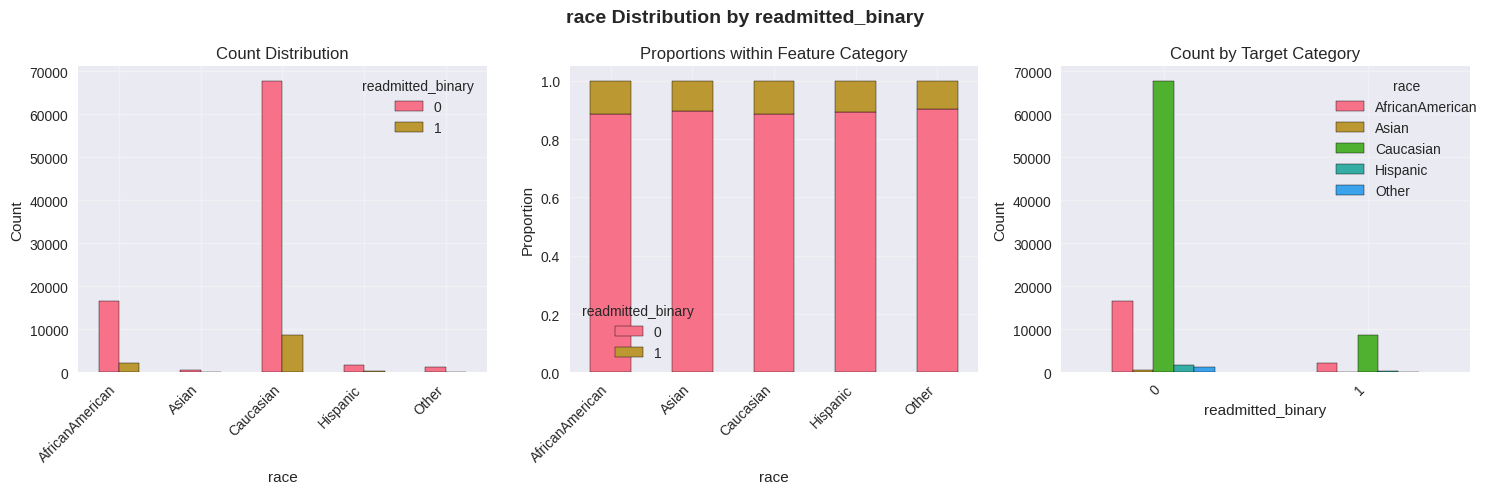


Contingency Table:
readmitted_binary      0     1
race                          
AfricanAmerican    16621  2149
Asian                562    65
Caucasian          67704  8743
Hispanic            1803   212
Other               1327   144

Proportions:
readmitted_binary         0         1
race                                 
AfricanAmerican    0.885509  0.114491
Asian              0.896332  0.103668
Caucasian          0.885633  0.114367
Hispanic           0.894789  0.105211
Other              0.902107  0.097893

Chi-square test:
  Test Statistic: 6.1227
  P-value: 1.9017e-01
  Cramér's V: 0.0079
  Significant at α=0.05: No

Analyzing: gender


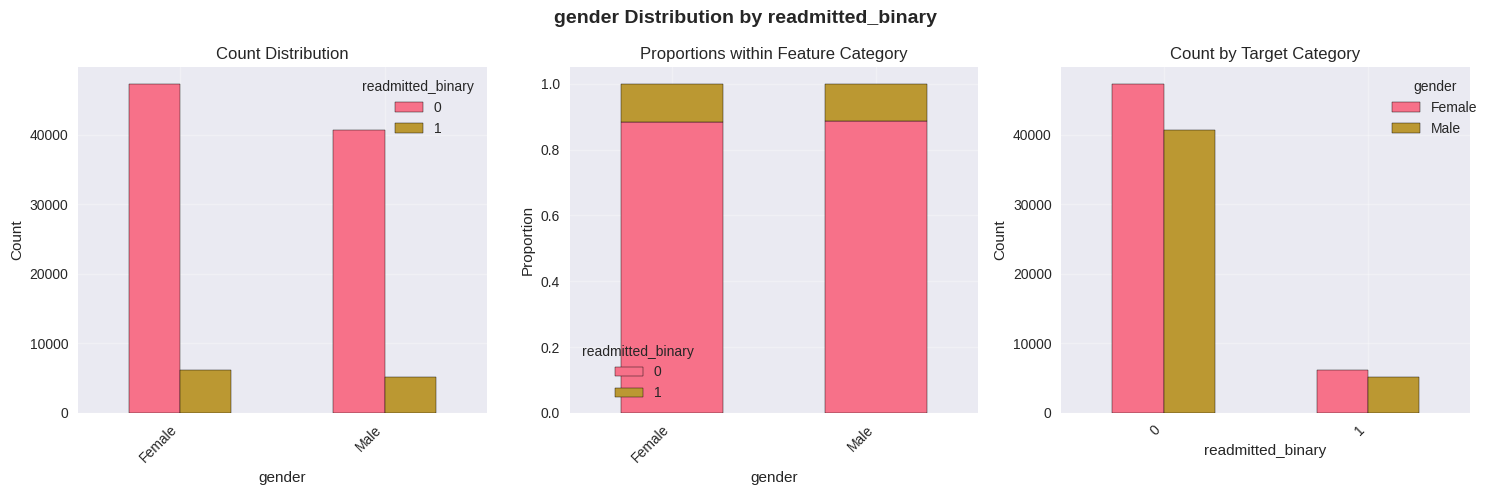


Contingency Table:
readmitted_binary      0     1
gender                        
Female             47324  6127
Male               40693  5186

Proportions:
readmitted_binary         0         1
gender                               
Female             0.885372  0.114628
Male               0.886964  0.113036

Chi-square test:
  Test Statistic: 0.6042
  P-value: 4.3697e-01
  Cramér's V: 0.0025
  Significant at α=0.05: No

Analyzing: age


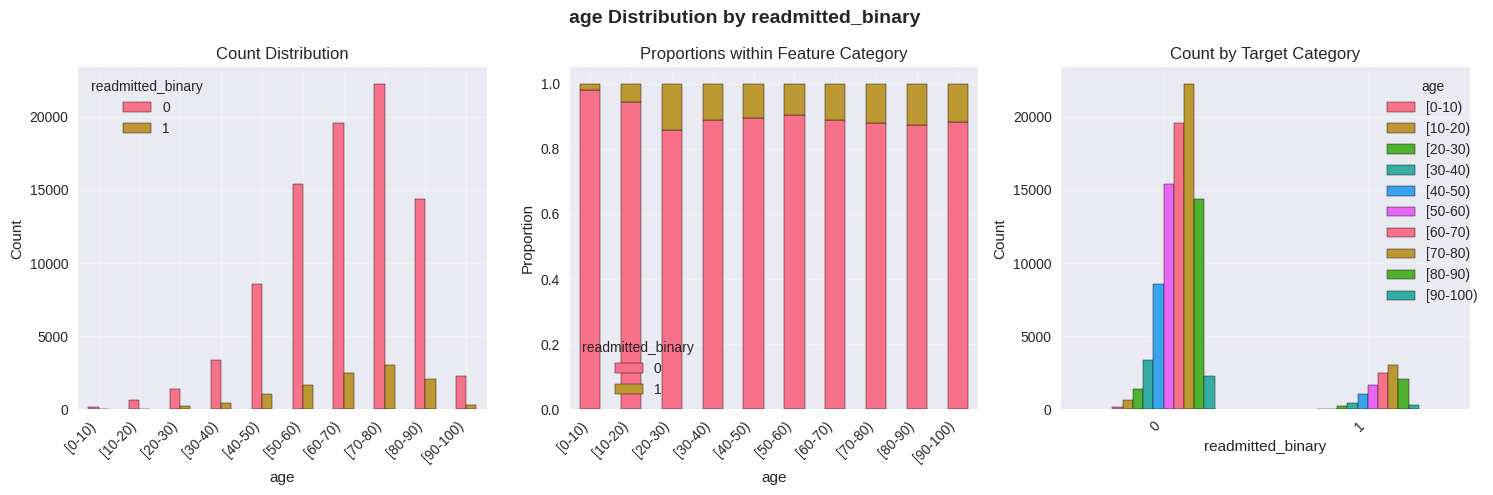


Contingency Table:
readmitted_binary      0     1
age                           
[0-10)               156     3
[10-20)              650    40
[20-30)             1413   236
[30-40)             3340   424
[40-50)             8582  1024
[50-60)            15392  1667
[60-70)            19563  2492
[70-80)            22273  3054
[80-90)            14367  2065
[90-100)            2281   308

Proportions:
readmitted_binary         0         1
age                                  
[0-10)             0.981132  0.018868
[10-20)            0.942029  0.057971
[20-30)            0.856883  0.143117
[30-40)            0.887354  0.112646
[40-50)            0.893400  0.106600
[50-60)            0.902280  0.097720
[60-70)            0.887010  0.112990
[70-80)            0.879417  0.120583
[80-90)            0.874331  0.125669
[90-100)           0.881035  0.118965

Chi-square test:
  Test Statistic: 133.5470
  P-value: 2.2086e-24
  Cramér's V: 0.0367
  Significant at α=0.05: Yes

Analyzing: admission

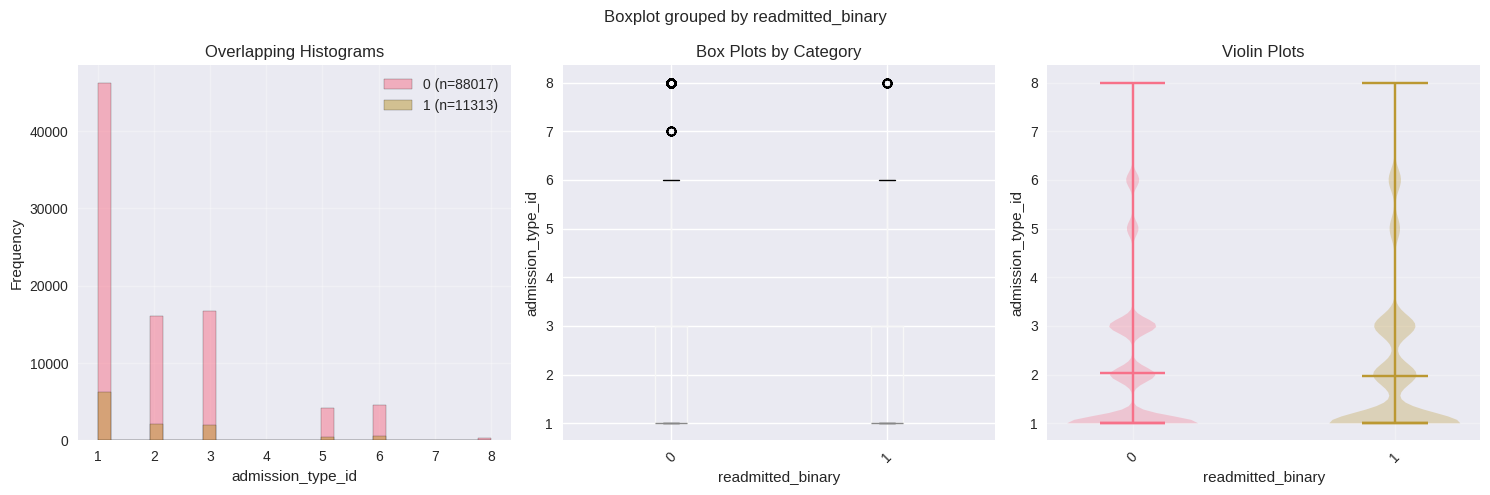


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  2.036925  1.449249  1.0  1.0  1.0  3.0  8.0
1                  11313.0  1.976752  1.422282  1.0  1.0  1.0  3.0  8.0

Mann-Whitney U test:
  Test Statistic: 510822331.5000
  P-value: 8.5771e-07
  Cohen's d: 0.0419
  Significant at α=0.05: Yes

Analyzing: discharge_disposition_id


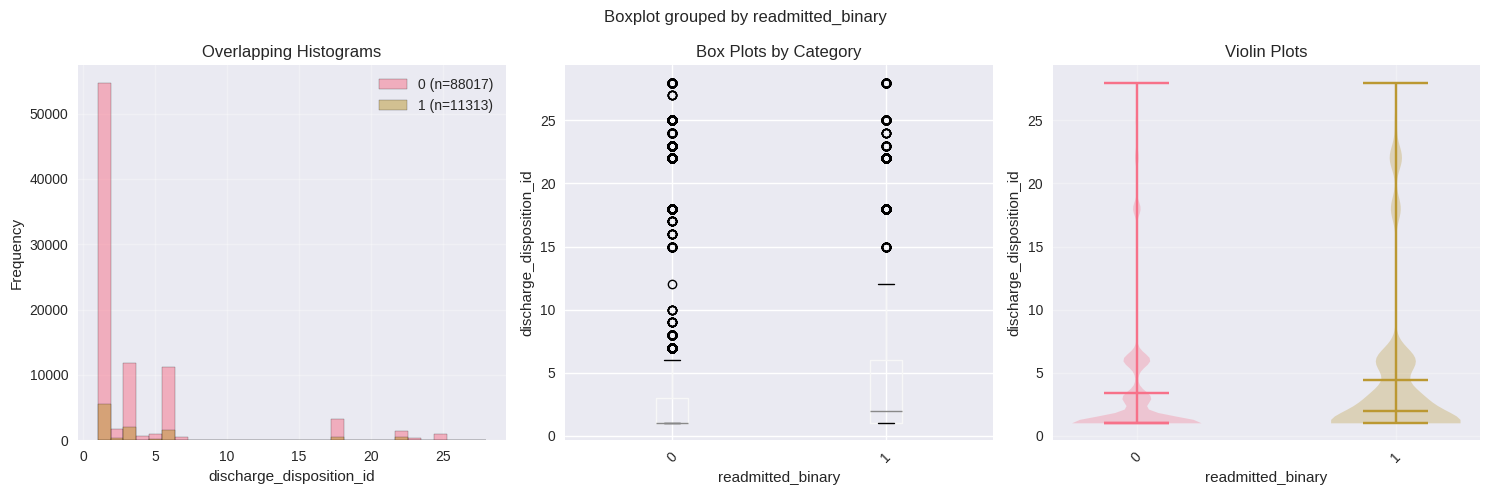


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%   max
readmitted_binary                                                       
0                  88017.0  3.400014  5.048459  1.0  1.0  1.0  3.0  28.0
1                  11313.0  4.434191  6.061881  1.0  1.0  2.0  6.0  28.0

Mann-Whitney U test:
  Test Statistic: 434832885.0000
  P-value: 8.2408e-138
  Cohen's d: -0.1854
  Significant at α=0.05: Yes

Analyzing: admission_source_id


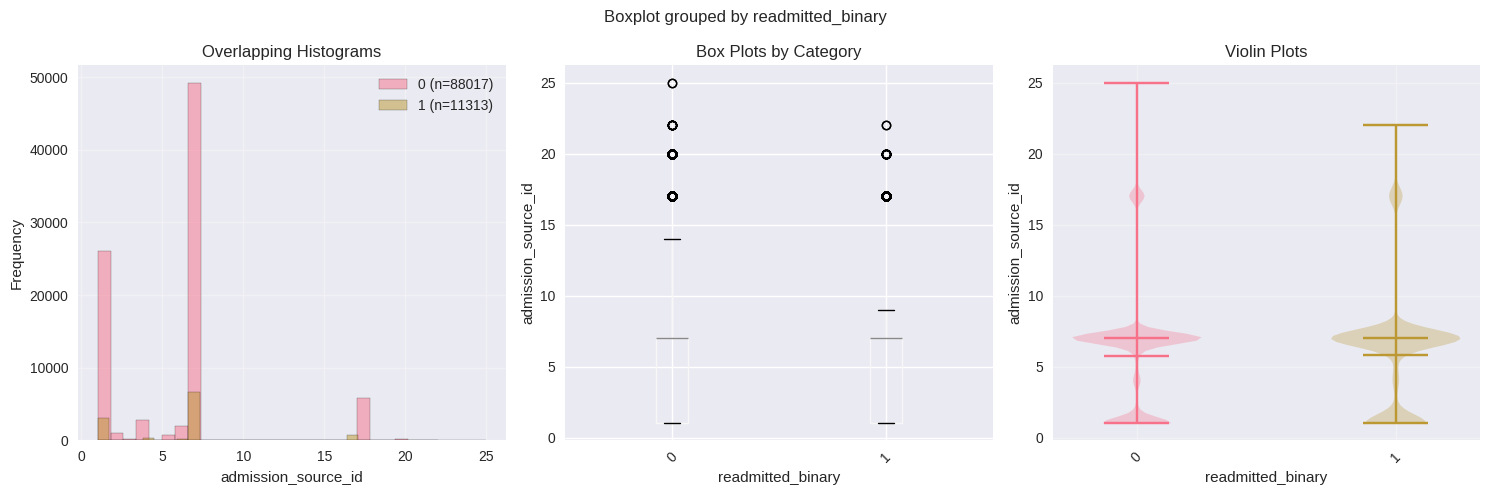


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%   max
readmitted_binary                                                       
0                  88017.0  5.719691  4.077683  1.0  1.0  7.0  7.0  25.0
1                  11313.0  5.820560  3.964880  1.0  1.0  7.0  7.0  22.0

Mann-Whitney U test:
  Test Statistic: 486438832.0000
  P-value: 8.1832e-06
  Cohen's d: -0.0251
  Significant at α=0.05: Yes

Analyzing: time_in_hospital


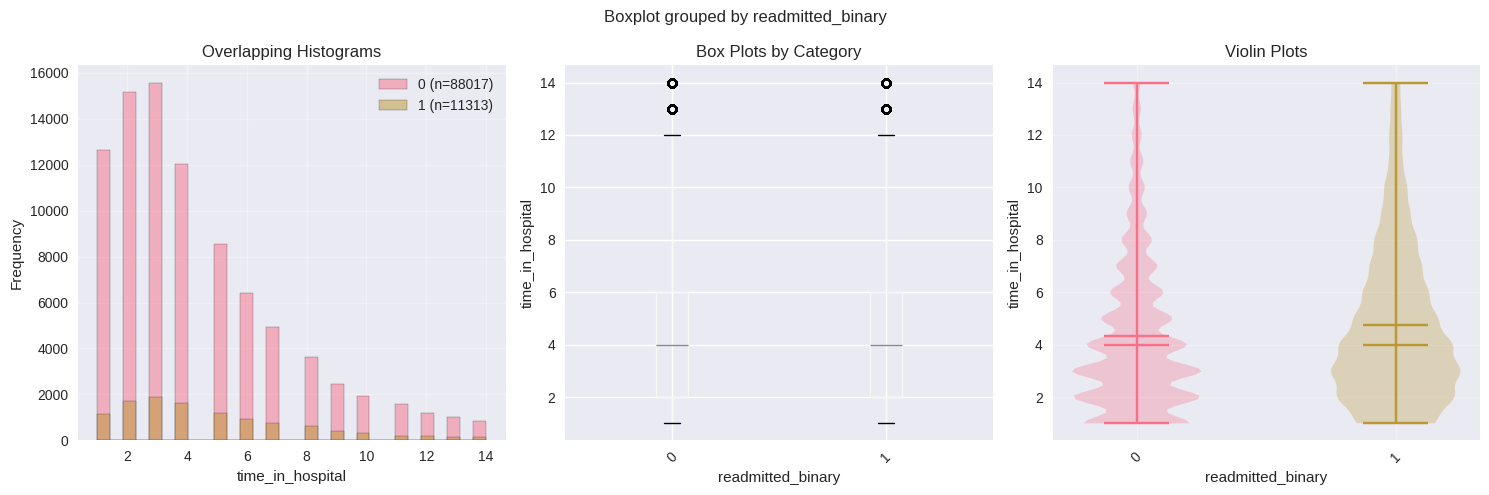


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%   max
readmitted_binary                                                       
0                  88017.0  4.329573  2.957106  1.0  2.0  4.0  6.0  14.0
1                  11313.0  4.767789  3.027762  1.0  2.0  4.0  6.0  14.0

Mann-Whitney U test:
  Test Statistic: 450354610.0000
  P-value: 1.4302e-62
  Cohen's d: -0.1464
  Significant at α=0.05: Yes

Analyzing: num_lab_procedures
⚠️  SKIPPING: Feature has 118 unique values (> 100)
   This feature likely represents IDs or has too many categories for meaningful analysis.

Analyzing: num_procedures


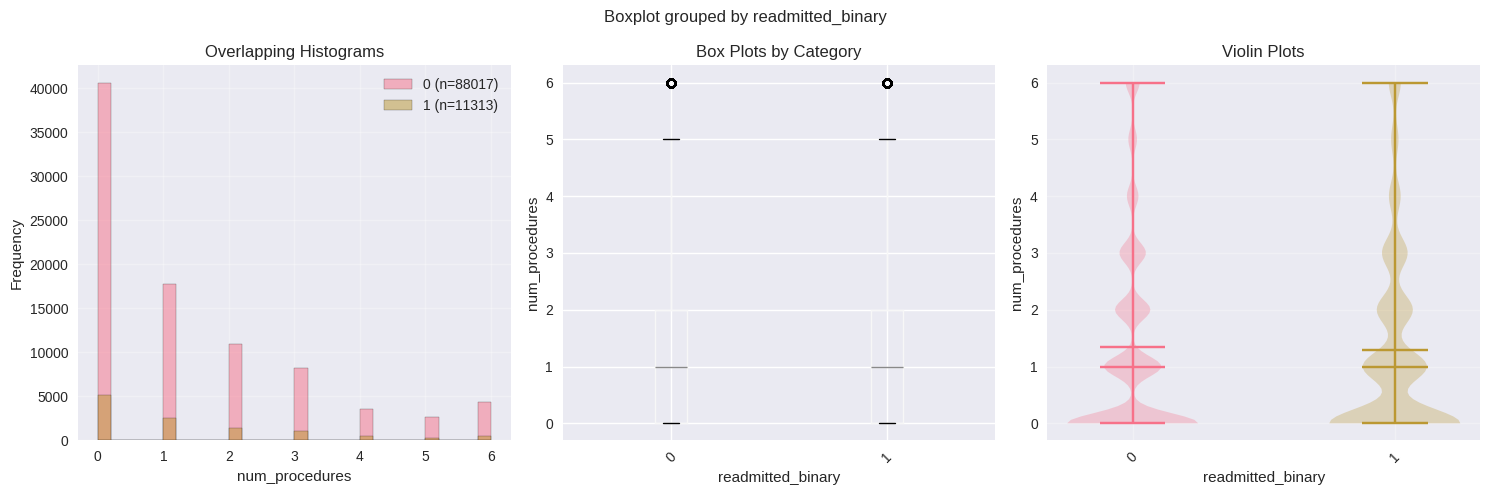


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  1.340786  1.710955  0.0  0.0  1.0  2.0  6.0
1                  11313.0  1.282860  1.636603  0.0  0.0  1.0  2.0  6.0

Mann-Whitney U test:
  Test Statistic: 501717903.5000
  P-value: 1.5552e-01
  Cohen's d: 0.0346
  Significant at α=0.05: No

Analyzing: num_medications


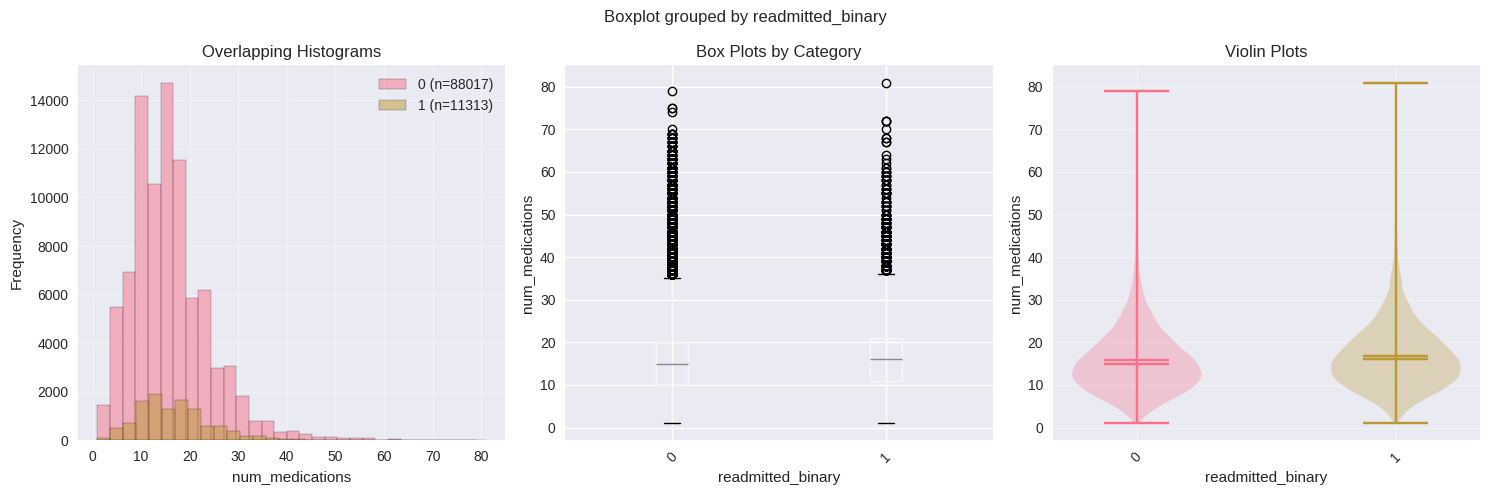


Descriptive Statistics:
                     count       mean       std  min   25%   50%   75%   max
readmitted_binary                                                           
0                  88017.0  15.859925  8.086984  1.0  10.0  15.0  20.0  79.0
1                  11313.0  16.909750  8.097995  1.0  11.0  16.0  21.0  81.0

Mann-Whitney U test:
  Test Statistic: 454431734.5000
  P-value: 8.2423e-52
  Cohen's d: -0.1297
  Significant at α=0.05: Yes

Analyzing: number_outpatient


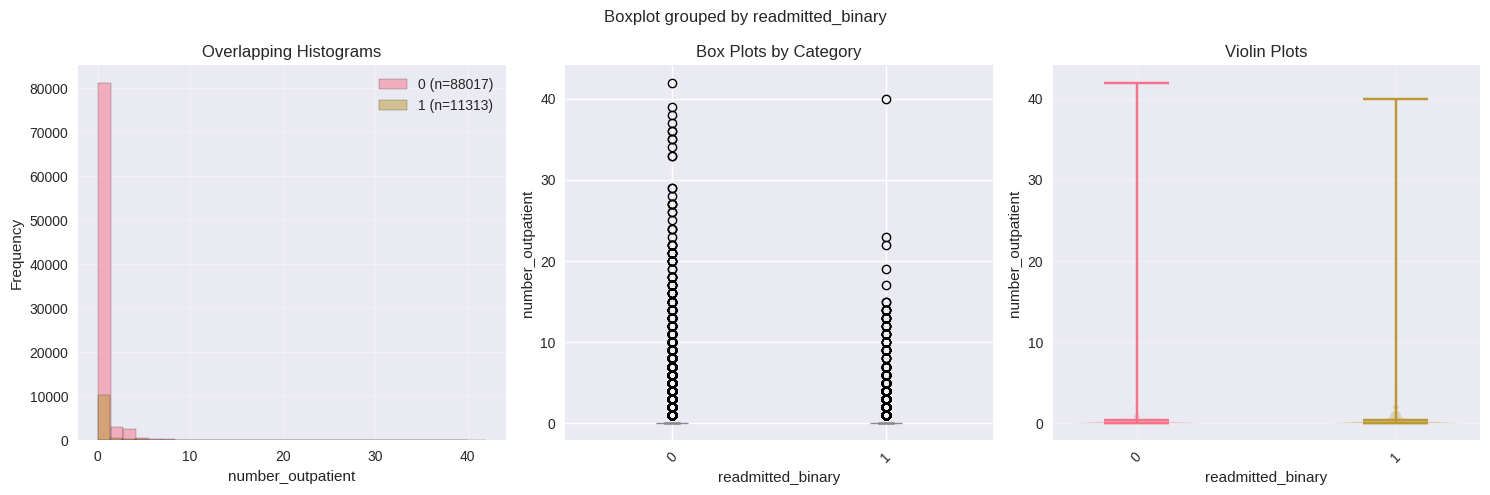


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%   max
readmitted_binary                                                       
0                  88017.0  0.360567  1.260355  0.0  0.0  0.0  0.0  42.0
1                  11313.0  0.436931  1.300271  0.0  0.0  0.0  0.0  40.0

Mann-Whitney U test:
  Test Statistic: 477604242.0000
  P-value: 7.4596e-28
  Cohen's d: -0.0596
  Significant at α=0.05: Yes

Analyzing: number_emergency


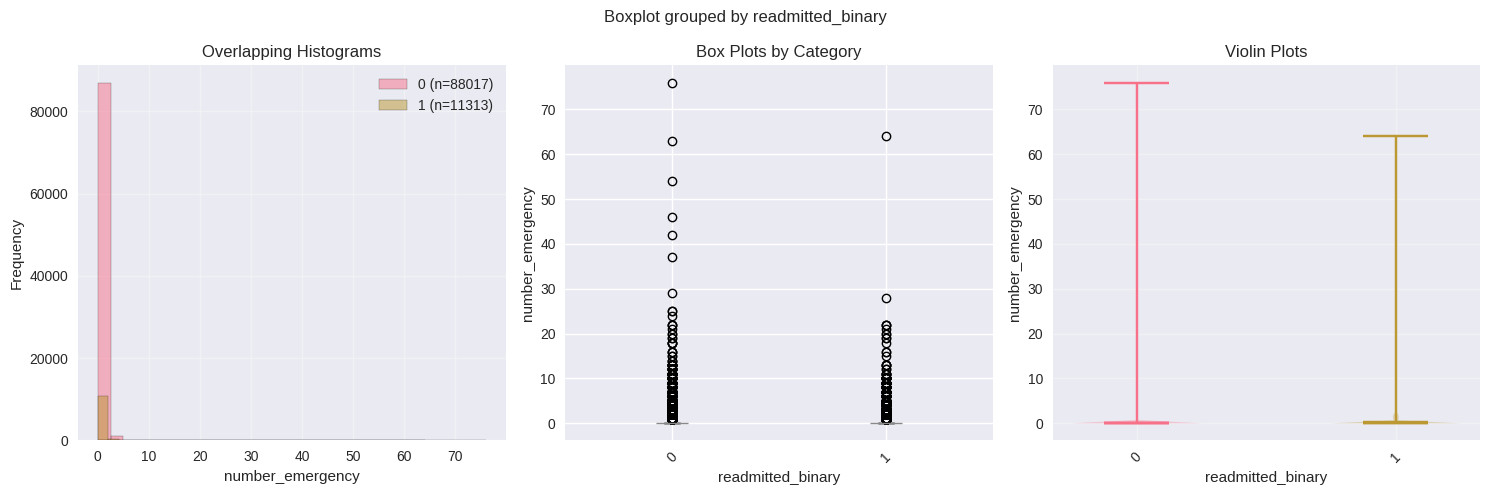


Descriptive Statistics:
                     count     mean       std  min  25%  50%  75%   max
readmitted_binary                                                      
0                  88017.0  0.17800  0.864162  0.0  0.0  0.0  0.0  76.0
1                  11313.0  0.35773  1.372314  0.0  0.0  0.0  0.0  64.0

Mann-Whitney U test:
  Test Statistic: 466019510.0000
  P-value: 1.2551e-91
  Cohen's d: -0.1567
  Significant at α=0.05: Yes

Analyzing: number_inpatient


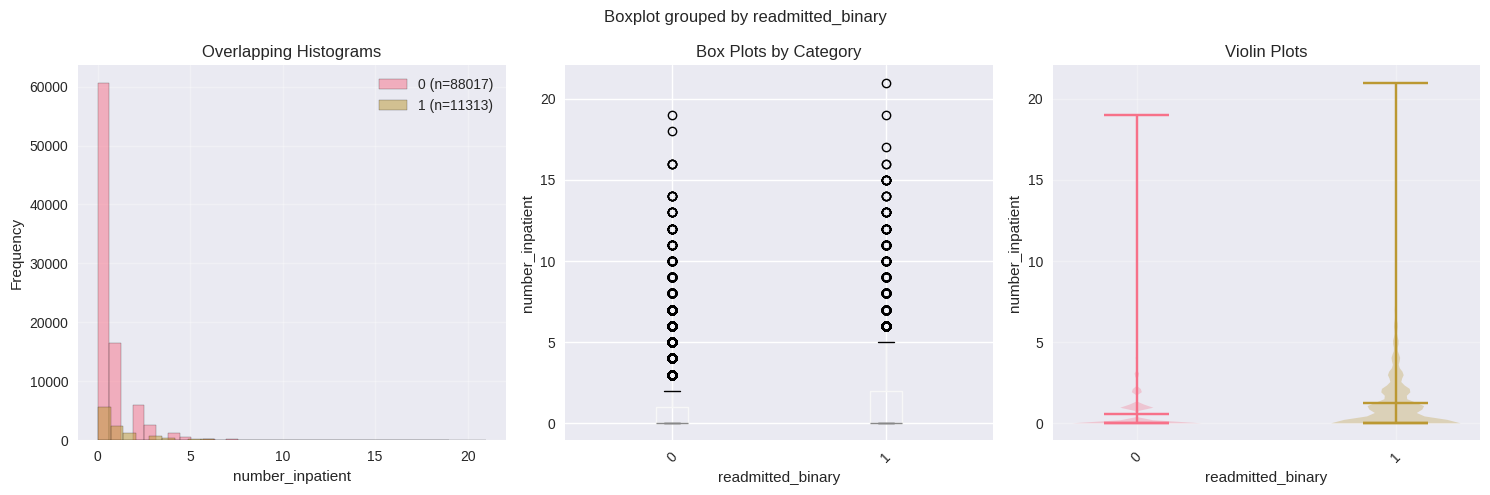


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%   max
readmitted_binary                                                       
0                  88017.0  0.554938  1.118342  0.0  0.0  0.0  1.0  19.0
1                  11313.0  1.222841  1.955689  0.0  0.0  0.0  2.0  21.0

Mann-Whitney U test:
  Test Statistic: 391048778.5000
  P-value: 0.0000e+00
  Cohen's d: -0.4193
  Significant at α=0.05: Yes

Analyzing: diag_1
⚠️  SKIPPING: Feature has 715 unique values (> 100)
   This feature likely represents IDs or has too many categories for meaningful analysis.

Analyzing: diag_2
⚠️  SKIPPING: Feature has 748 unique values (> 100)
   This feature likely represents IDs or has too many categories for meaningful analysis.

Analyzing: diag_3
⚠️  SKIPPING: Feature has 787 unique values (> 100)
   This feature likely represents IDs or has too many categories for meaningful analysis.

Analyzing: number_diagnoses


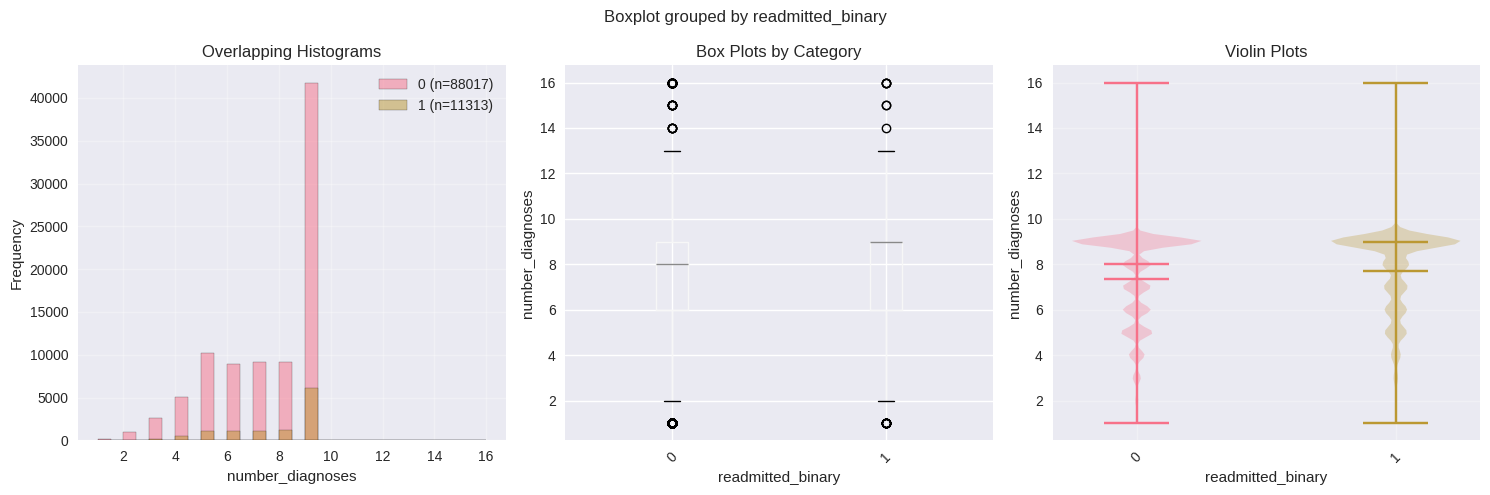


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%   max
readmitted_binary                                                       
0                  88017.0  7.364532  1.958239  1.0  6.0  8.0  9.0  16.0
1                  11313.0  7.691682  1.774868  1.0  6.0  9.0  9.0  16.0

Mann-Whitney U test:
  Test Statistic: 454072139.5000
  P-value: 3.1734e-59
  Cohen's d: -0.1751
  Significant at α=0.05: Yes

Analyzing: max_glu_serum


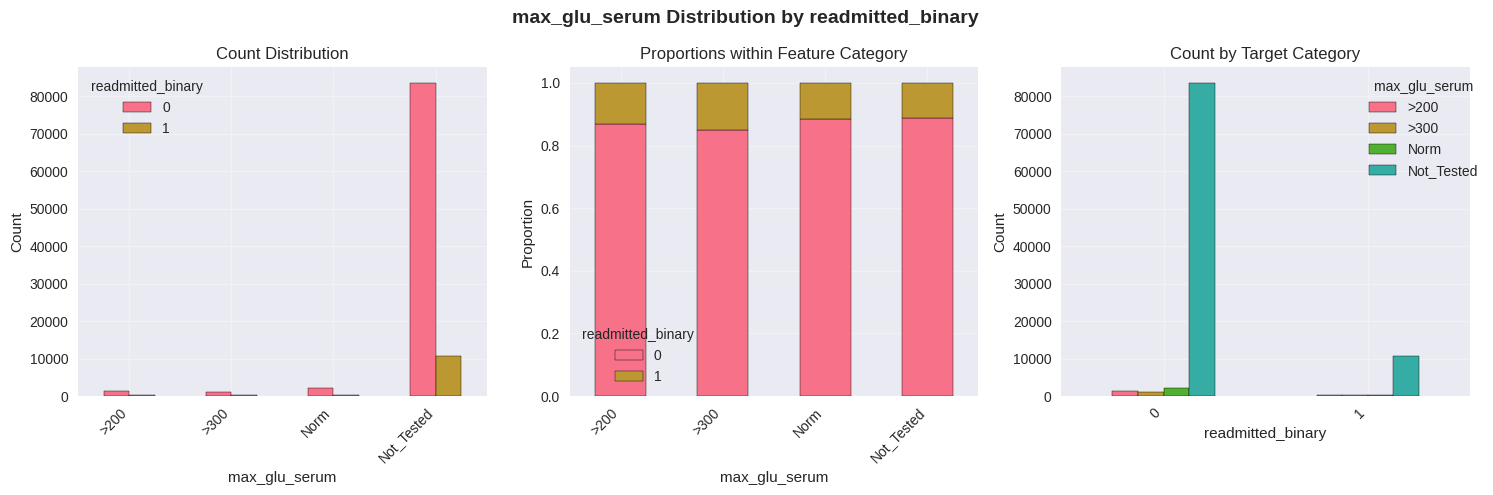


Contingency Table:
readmitted_binary      0      1
max_glu_serum                  
>200                1235    184
>300                1009    179
Norm                2251    294
Not_Tested         83522  10656

Proportions:
readmitted_binary         0         1
max_glu_serum                        
>200               0.870331  0.129669
>300               0.849327  0.150673
Norm               0.884479  0.115521
Not_Tested         0.886853  0.113147

Chi-square test:
  Test Statistic: 20.0093
  P-value: 1.6899e-04
  Cramér's V: 0.0142
  Significant at α=0.05: Yes

Analyzing: A1Cresult


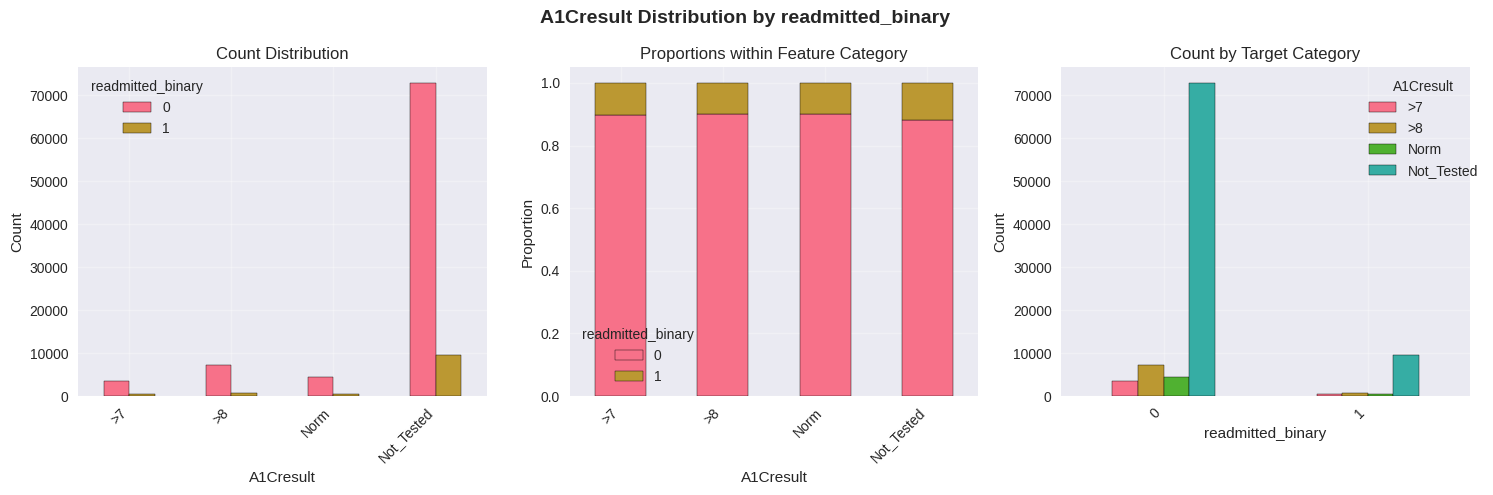


Contingency Table:
readmitted_binary      0     1
A1Cresult                     
>7                  3390   383
>8                  7328   809
Norm                4441   481
Not_Tested         72858  9640

Proportions:
readmitted_binary         0         1
A1Cresult                            
>7                 0.898489  0.101511
>8                 0.900578  0.099422
Norm               0.902275  0.097725
Not_Tested         0.883149  0.116851

Chi-square test:
  Test Statistic: 42.5188
  P-value: 3.1136e-09
  Cramér's V: 0.0207
  Significant at α=0.05: Yes

Analyzing: metformin


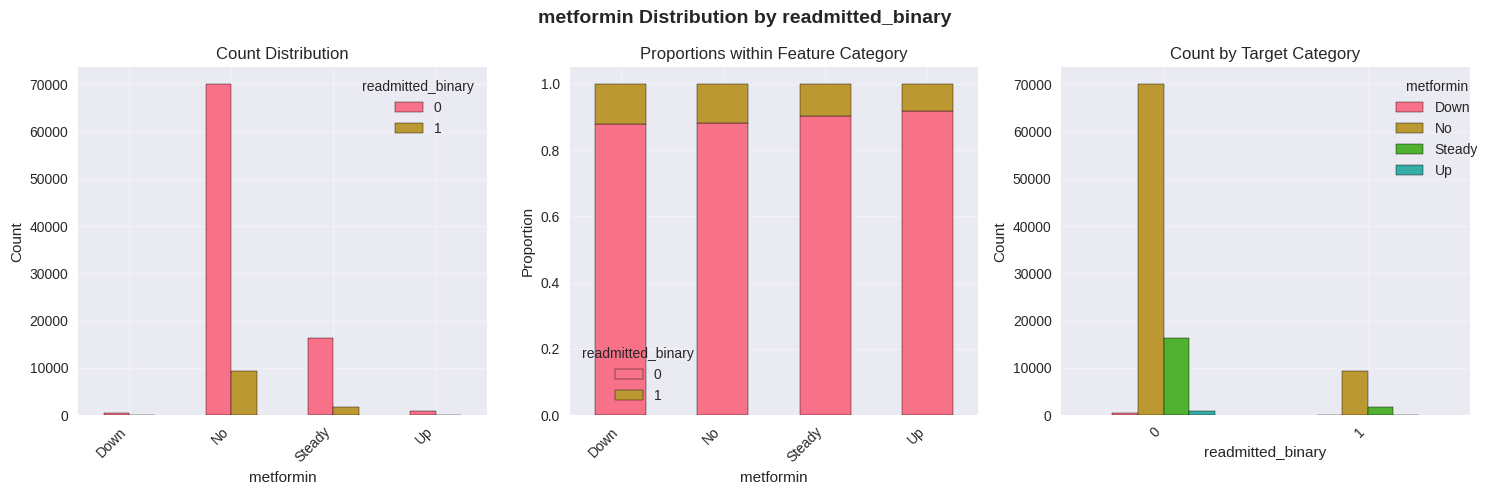


Contingency Table:
readmitted_binary      0     1
metformin                     
Down                 505    69
No                 70113  9375
Steady             16424  1781
Up                   975    88

Proportions:
readmitted_binary         0         1
metformin                            
Down               0.879791  0.120209
No                 0.882058  0.117942
Steady             0.902170  0.097830
Up                 0.917215  0.082785

Chi-square test:
  Test Statistic: 69.8768
  P-value: 4.5356e-15
  Cramér's V: 0.0265
  Significant at α=0.05: Yes

Analyzing: repaglinide


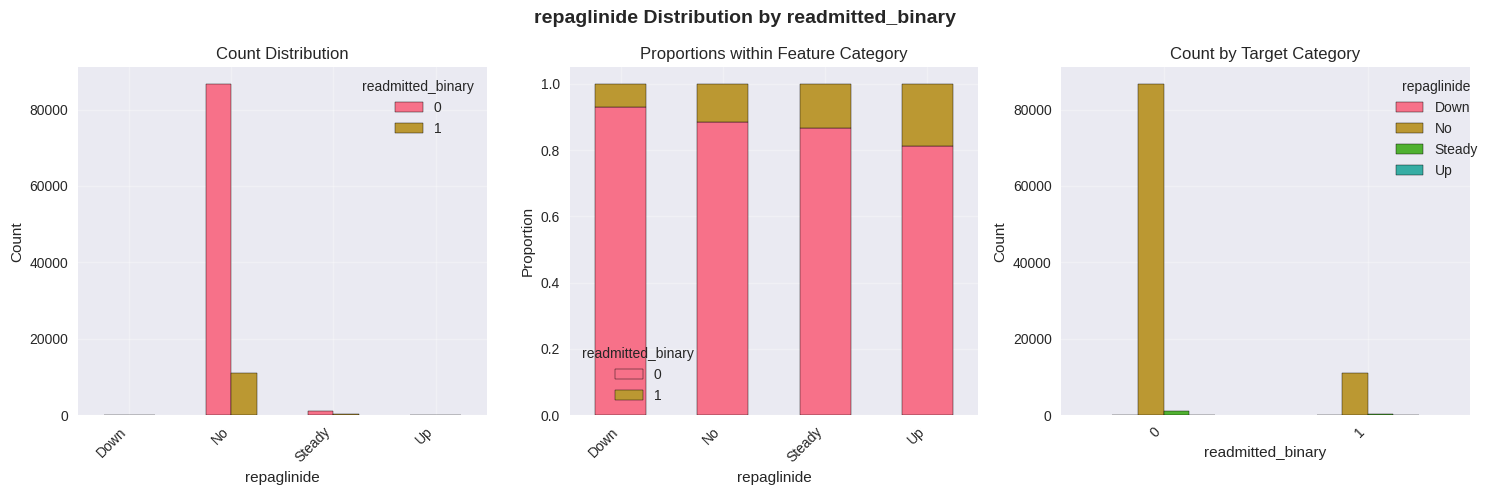


Contingency Table:
readmitted_binary      0      1
repaglinide                    
Down                  40      3
No                 86704  11108
Steady              1186    182
Up                    87     20

Proportions:
readmitted_binary         0         1
repaglinide                          
Down               0.930233  0.069767
No                 0.886435  0.113565
Steady             0.866959  0.133041
Up                 0.813084  0.186916

Chi-square test:
  Test Statistic: 11.5574
  P-value: 9.0639e-03
  Cramér's V: 0.0108
  Significant at α=0.05: Yes

Analyzing: nateglinide


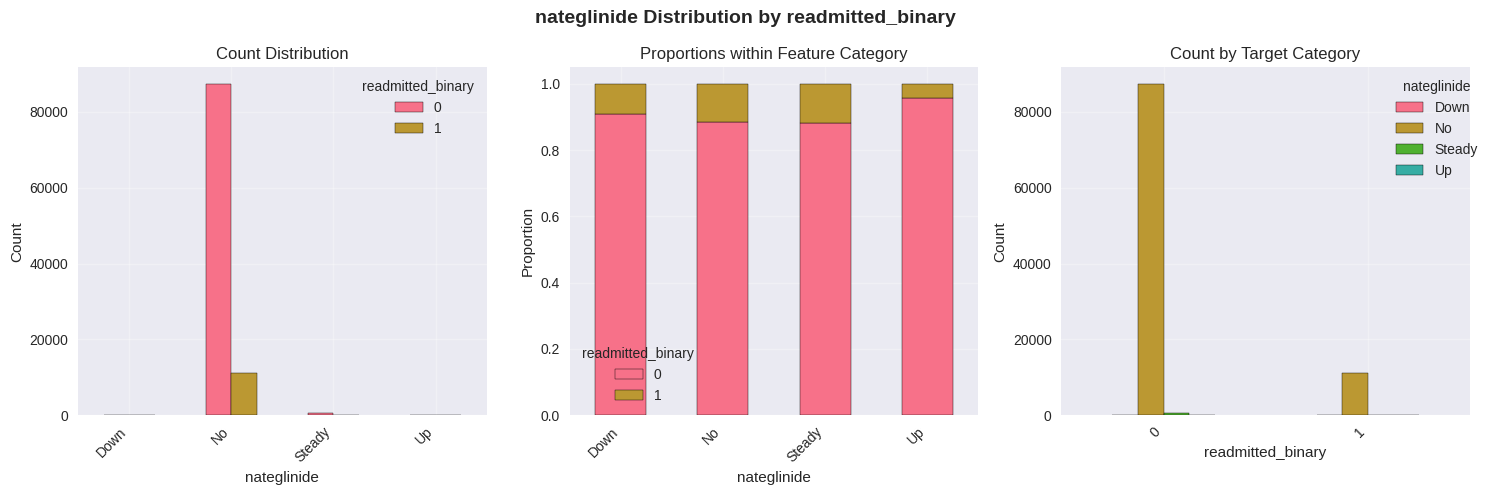


Contingency Table:
readmitted_binary      0      1
nateglinide                    
Down                  10      1
No                 87408  11233
Steady               576     78
Up                    23      1

Proportions:
readmitted_binary         0         1
nateglinide                          
Down               0.909091  0.090909
No                 0.886122  0.113878
Steady             0.880734  0.119266
Up                 0.958333  0.041667

Chi-square test:
  Test Statistic: 1.4855
  P-value: 6.8563e-01
  Cramér's V: 0.0039
  Significant at α=0.05: No

Analyzing: chlorpropamide


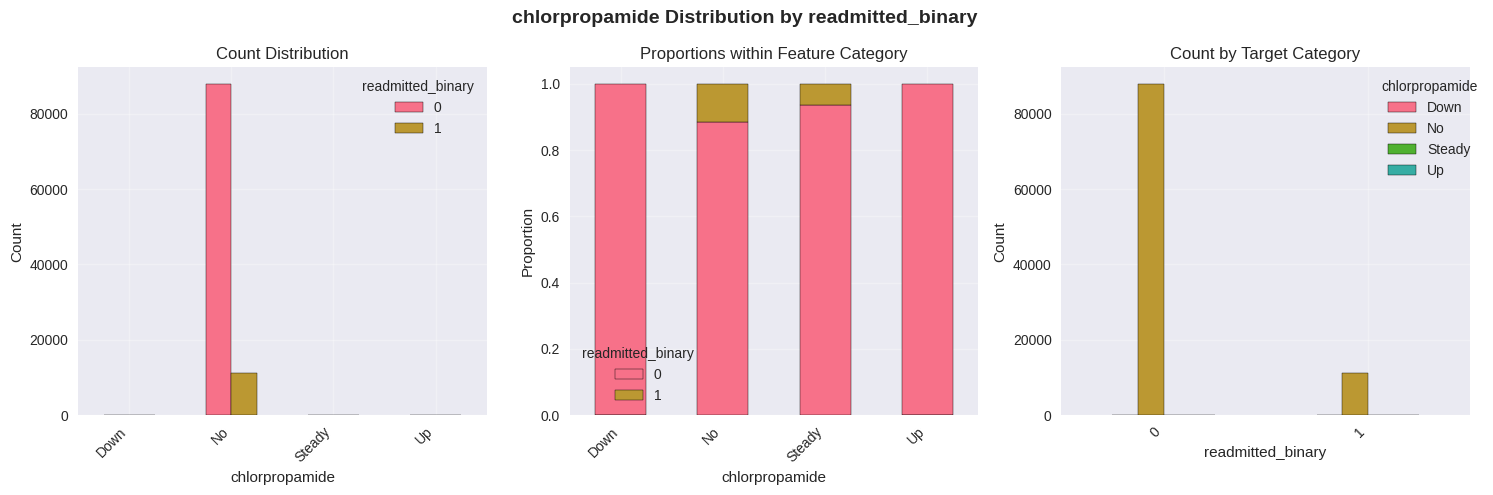


Contingency Table:
readmitted_binary      0      1
chlorpropamide                 
Down                   1      0
No                 87937  11308
Steady                73      5
Up                     6      0

Proportions:
readmitted_binary         0         1
chlorpropamide                       
Down               1.000000  0.000000
No                 0.886060  0.113940
Steady             0.935897  0.064103
Up                 1.000000  0.000000

Chi-square test:
  Test Statistic: 2.8180
  P-value: 4.2055e-01
  Cramér's V: 0.0053
  Significant at α=0.05: No

Analyzing: glimepiride


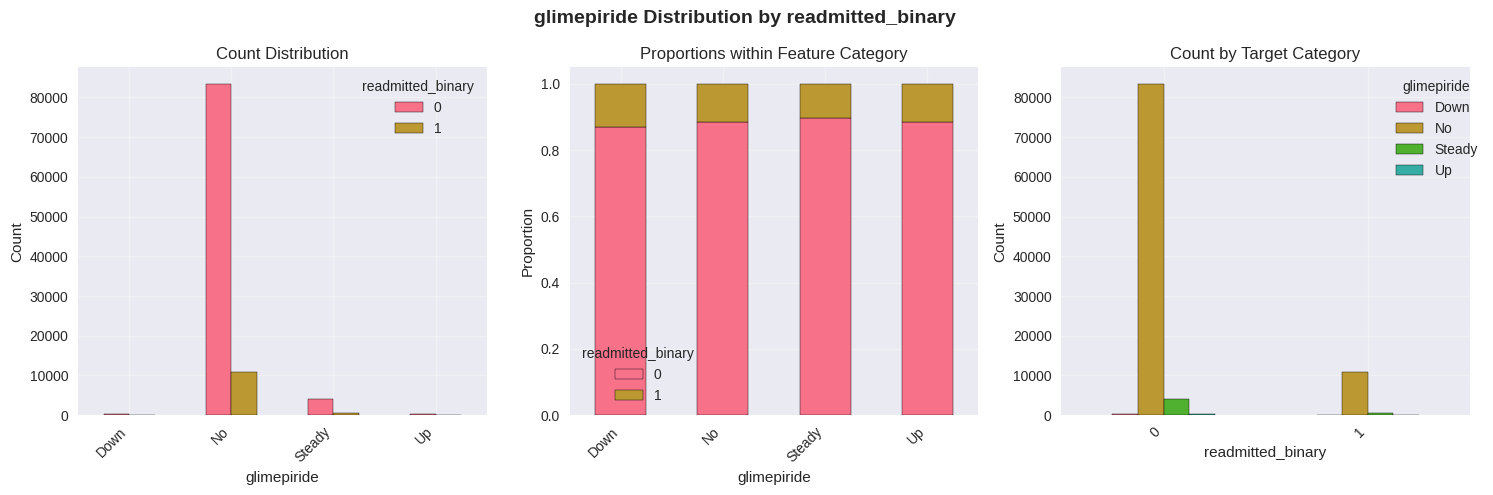


Contingency Table:
readmitted_binary      0      1
glimepiride                    
Down                 166     25
No                 83426  10783
Steady              4140    468
Up                   285     37

Proportions:
readmitted_binary         0         1
glimepiride                          
Down               0.869110  0.130890
No                 0.885542  0.114458
Steady             0.898438  0.101562
Up                 0.885093  0.114907

Chi-square test:
  Test Statistic: 7.7904
  P-value: 5.0548e-02
  Cramér's V: 0.0089
  Significant at α=0.05: No

Analyzing: acetohexamide


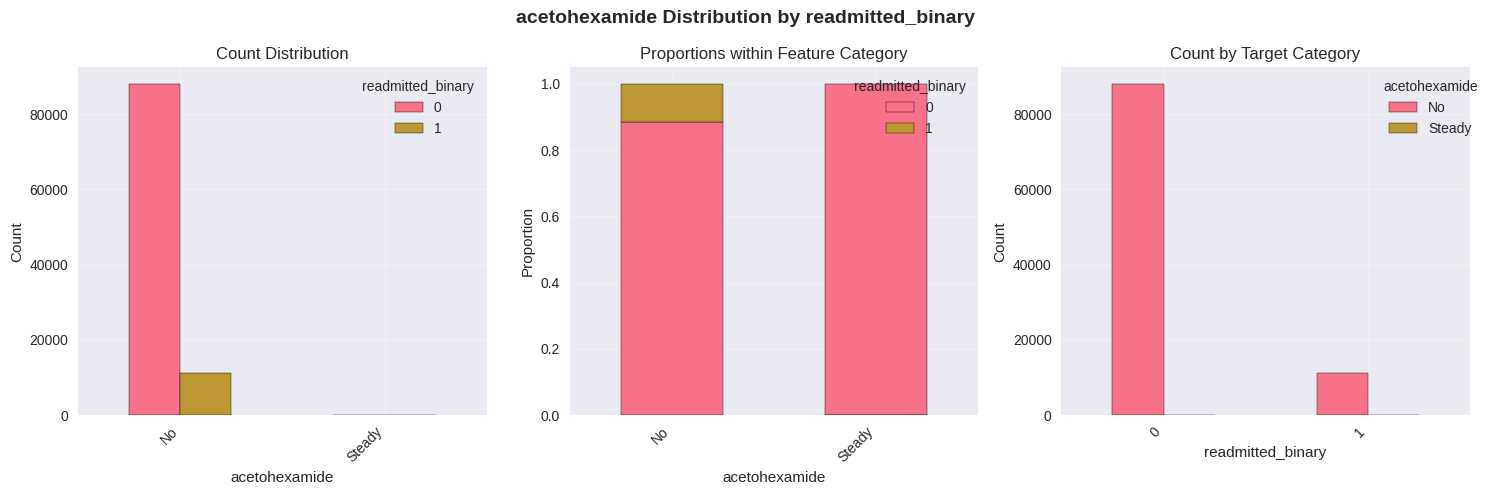


Contingency Table:
readmitted_binary      0      1
acetohexamide                  
No                 88016  11313
Steady                 1      0

Proportions:
readmitted_binary         0         1
acetohexamide                        
No                 0.886106  0.113894
Steady             1.000000  0.000000

Chi-square test:
  Test Statistic: 0.0000
  P-value: 1.0000e+00
  Cramér's V: 0.0000
  Significant at α=0.05: No

Analyzing: glipizide


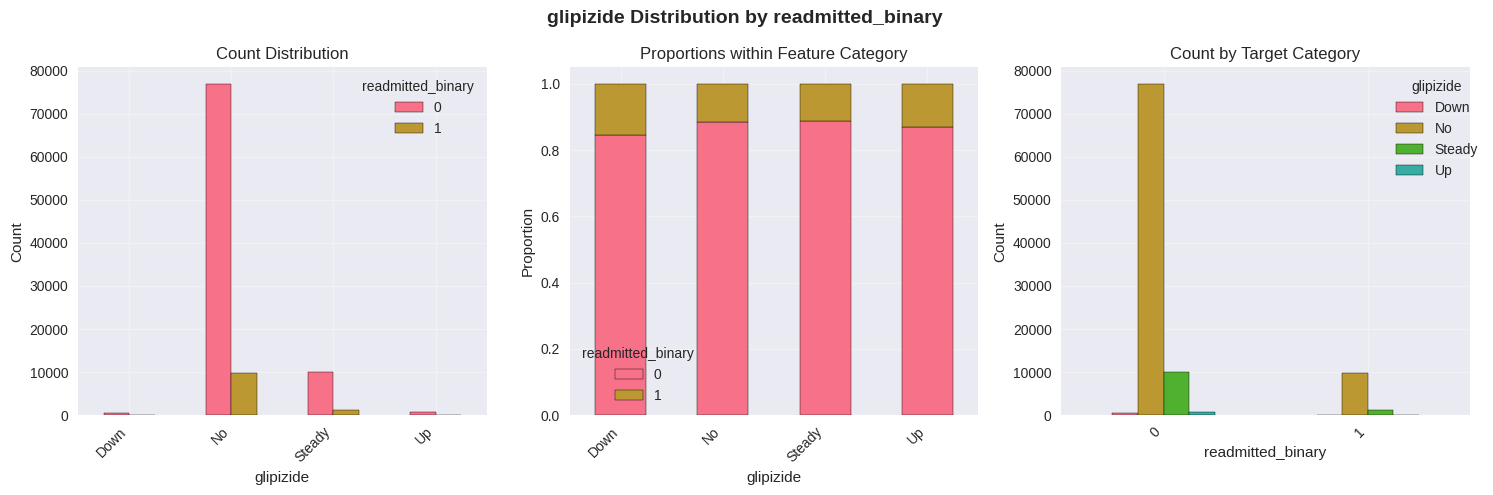


Contingency Table:
readmitted_binary      0     1
glipizide                     
Down                 463    85
No                 76933  9867
Steady              9956  1262
Up                   665    99

Proportions:
readmitted_binary         0         1
glipizide                            
Down               0.844891  0.155109
No                 0.886325  0.113675
Steady             0.887502  0.112498
Up                 0.870419  0.129581

Chi-square test:
  Test Statistic: 11.3448
  P-value: 1.0000e-02
  Cramér's V: 0.0107
  Significant at α=0.05: Yes

Analyzing: glyburide


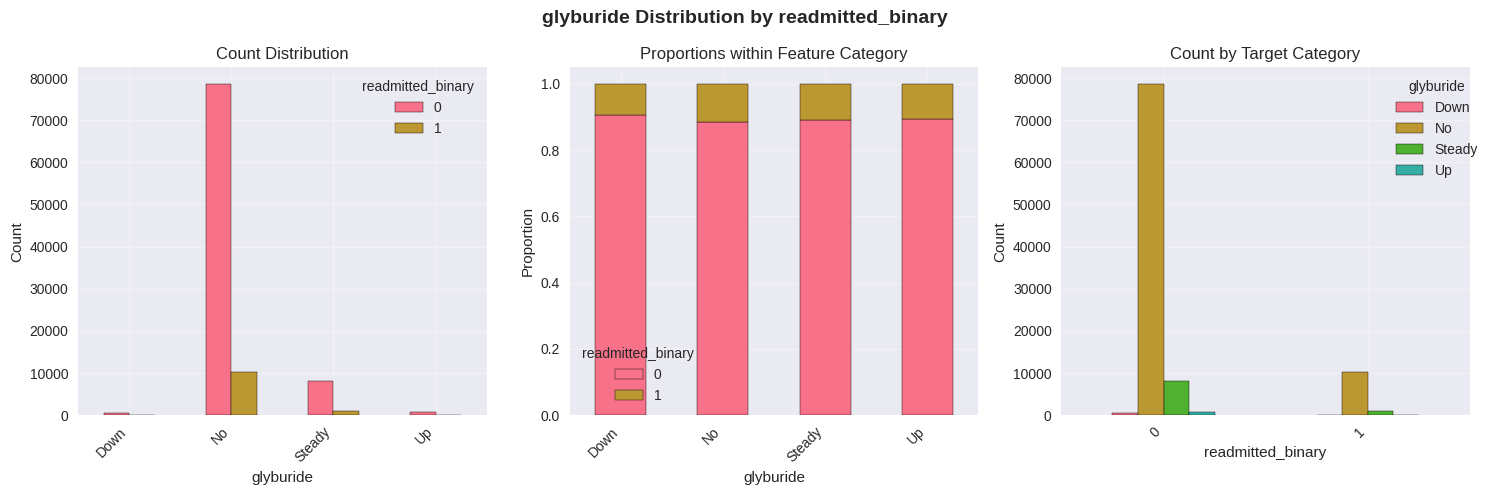


Contingency Table:
readmitted_binary      0      1
glyburide                      
Down                 508     52
No                 78622  10185
Steady              8171    991
Up                   716     85

Proportions:
readmitted_binary         0         1
glyburide                            
Down               0.907143  0.092857
No                 0.885313  0.114687
Steady             0.891836  0.108164
Up                 0.893883  0.106117

Chi-square test:
  Test Statistic: 6.4694
  P-value: 9.0877e-02
  Cramér's V: 0.0081
  Significant at α=0.05: No

Analyzing: tolbutamide


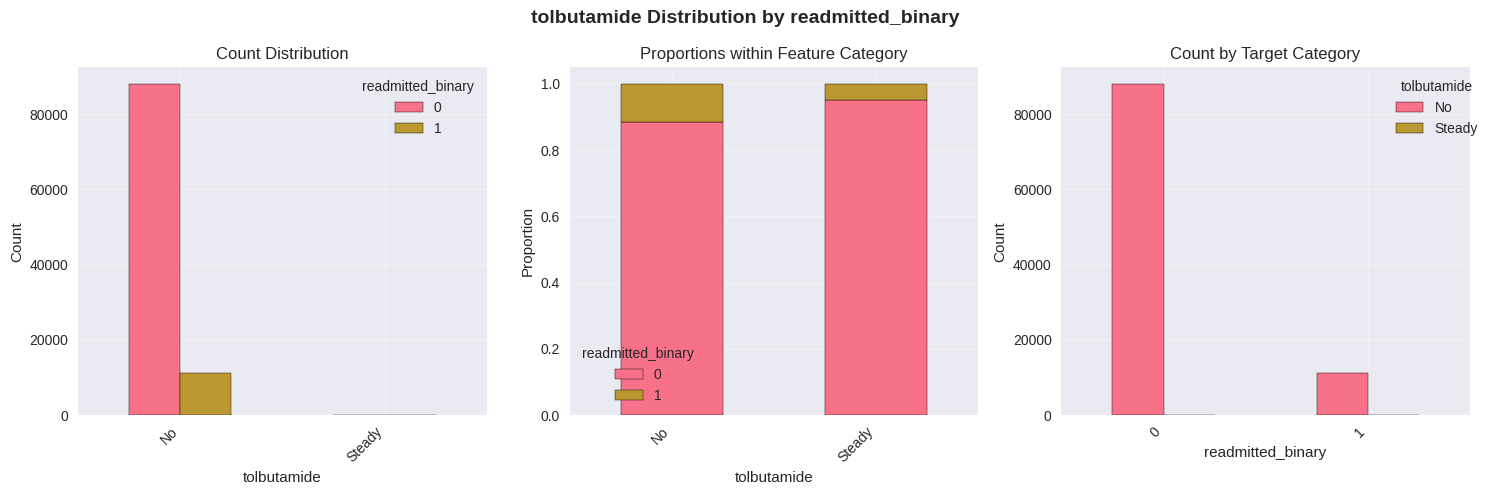


Contingency Table:
readmitted_binary      0      1
tolbutamide                    
No                 87997  11312
Steady                20      1

Proportions:
readmitted_binary         0         1
tolbutamide                          
No                 0.886093  0.113907
Steady             0.952381  0.047619

Chi-square test:
  Test Statistic: 0.3753
  P-value: 5.4013e-01
  Cramér's V: 0.0019
  Significant at α=0.05: No

Analyzing: pioglitazone


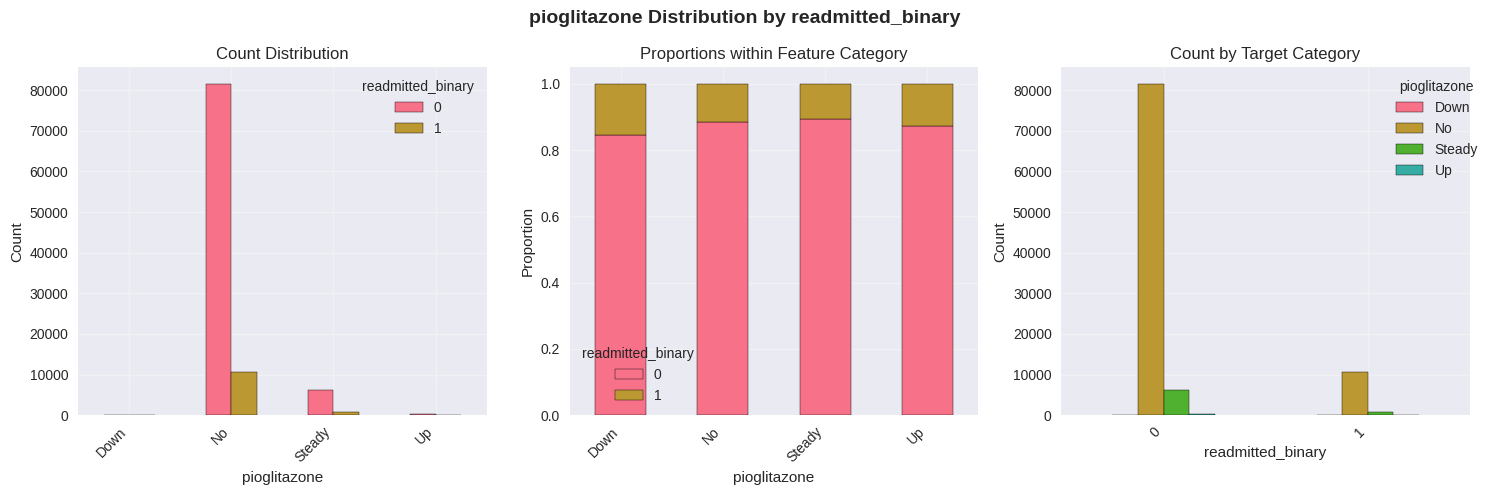


Contingency Table:
readmitted_binary      0      1
pioglitazone                   
Down                  99     18
No                 81536  10541
Steady              6181    725
Up                   201     29

Proportions:
readmitted_binary         0         1
pioglitazone                         
Down               0.846154  0.153846
No                 0.885520  0.114480
Steady             0.895019  0.104981
Up                 0.873913  0.126087

Chi-square test:
  Test Statistic: 7.9388
  P-value: 4.7293e-02
  Cramér's V: 0.0089
  Significant at α=0.05: Yes

Analyzing: rosiglitazone


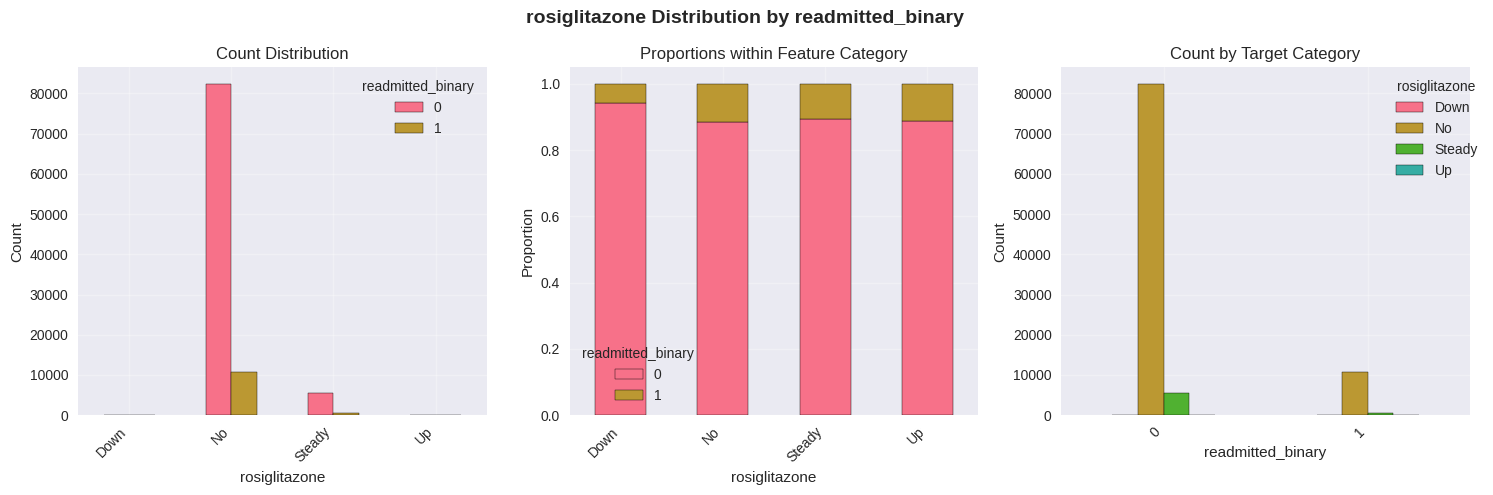


Contingency Table:
readmitted_binary      0      1
rosiglitazone                  
Down                  80      5
No                 82378  10649
Steady              5407    640
Up                   152     19

Proportions:
readmitted_binary         0         1
rosiglitazone                        
Down               0.941176  0.058824
No                 0.885528  0.114472
Steady             0.894162  0.105838
Up                 0.888889  0.111111

Chi-square test:
  Test Statistic: 6.7645
  P-value: 7.9794e-02
  Cramér's V: 0.0083
  Significant at α=0.05: No

Analyzing: acarbose


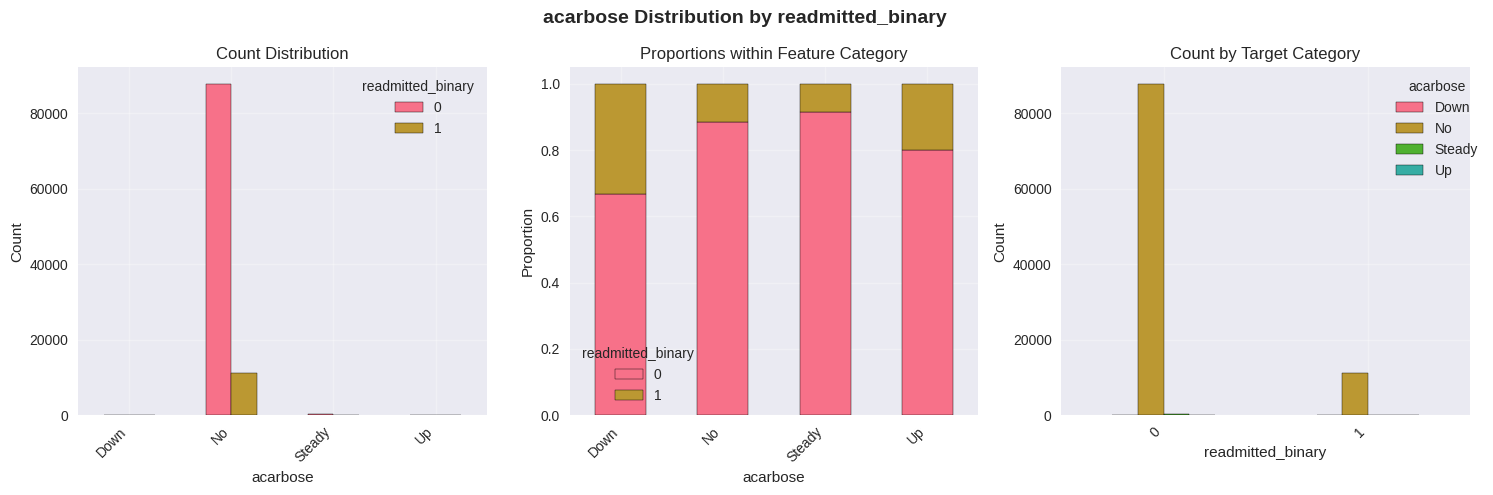


Contingency Table:
readmitted_binary      0      1
acarbose                       
Down                   2      1
No                 87740  11285
Steady               267     25
Up                     8      2

Proportions:
readmitted_binary         0         1
acarbose                             
Down               0.666667  0.333333
No                 0.886039  0.113961
Steady             0.914384  0.085616
Up                 0.800000  0.200000

Chi-square test:
  Test Statistic: 4.4841
  P-value: 2.1372e-01
  Cramér's V: 0.0067
  Significant at α=0.05: No

Analyzing: miglitol


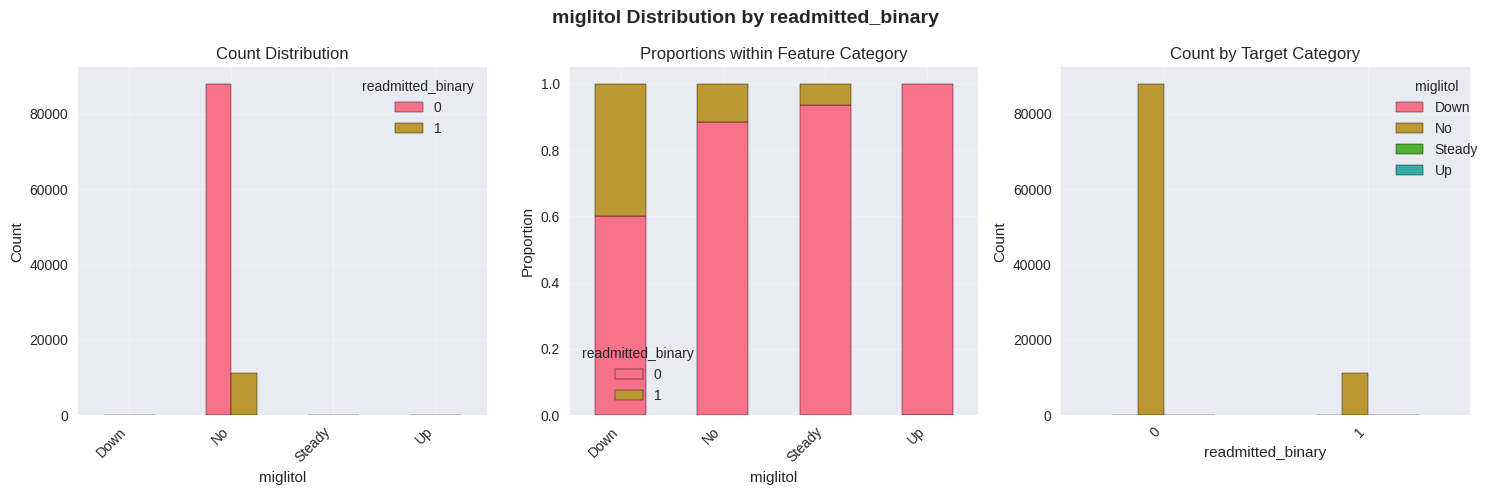


Contingency Table:
readmitted_binary      0      1
miglitol                       
Down                   3      2
No                 87983  11309
Steady                29      2
Up                     2      0

Proportions:
readmitted_binary         0         1
miglitol                             
Down               0.600000  0.400000
No                 0.886104  0.113896
Steady             0.935484  0.064516
Up                 1.000000  0.000000

Chi-square test:
  Test Statistic: 5.0615
  P-value: 1.6735e-01
  Cramér's V: 0.0071
  Significant at α=0.05: No

Analyzing: troglitazone


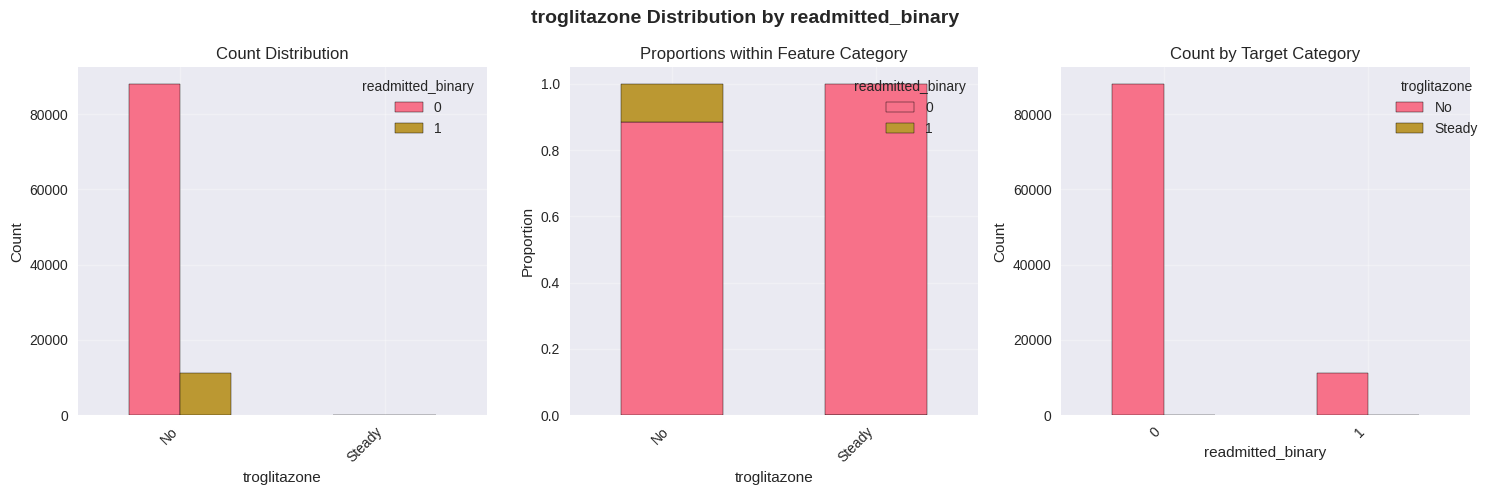


Contingency Table:
readmitted_binary      0      1
troglitazone                   
No                 88014  11313
Steady                 3      0

Proportions:
readmitted_binary         0         1
troglitazone                         
No                 0.886103  0.113897
Steady             1.000000  0.000000

Chi-square test:
  Test Statistic: 0.0000
  P-value: 1.0000e+00
  Cramér's V: 0.0000
  Significant at α=0.05: No

Analyzing: tolazamide


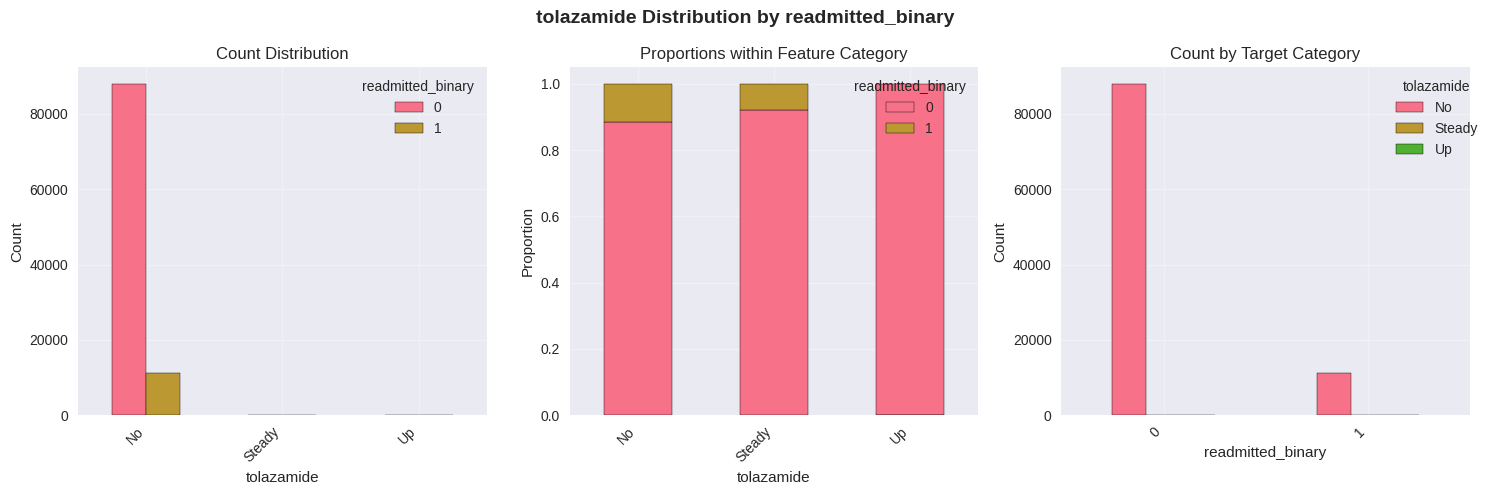


Contingency Table:
readmitted_binary      0      1
tolazamide                     
No                 87981  11310
Steady                35      3
Up                     1      0

Proportions:
readmitted_binary         0         1
tolazamide                           
No                 0.886092  0.113908
Steady             0.921053  0.078947
Up                 1.000000  0.000000

Chi-square test:
  Test Statistic: 0.5886
  P-value: 7.4507e-01
  Cramér's V: 0.0024
  Significant at α=0.05: No

Analyzing: insulin


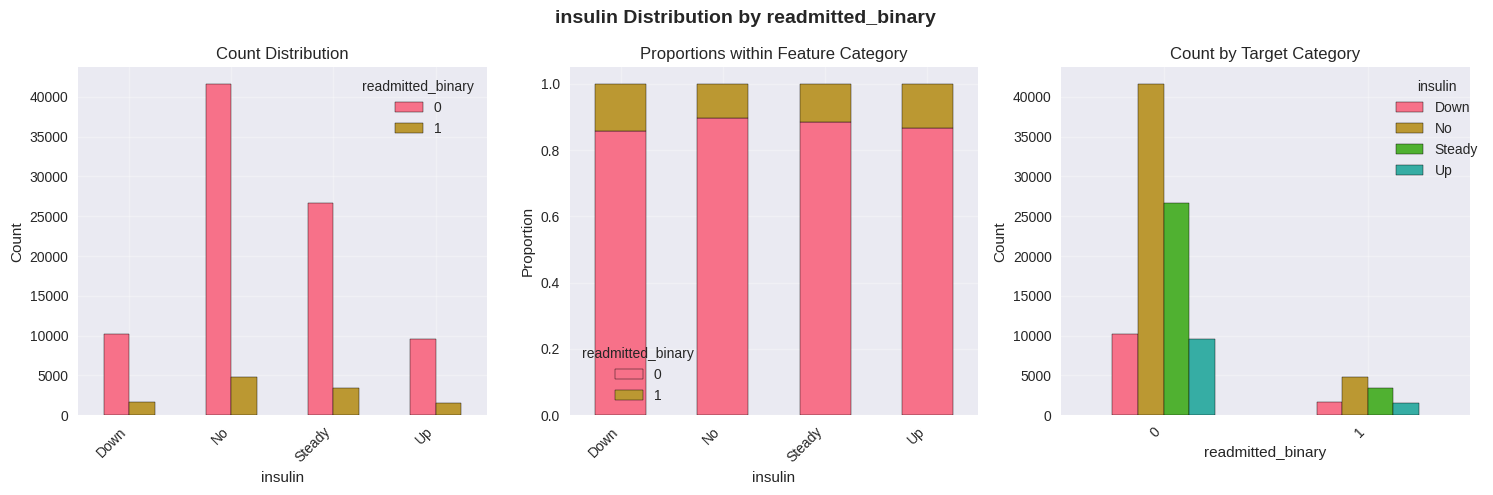


Contingency Table:
readmitted_binary      0     1
insulin                       
Down               10215  1693
No                 41636  4736
Steady             26645  3419
Up                  9521  1465

Proportions:
readmitted_binary         0         1
insulin                              
Down               0.857827  0.142173
No                 0.897869  0.102131
Steady             0.886276  0.113724
Up                 0.866648  0.133352

Chi-square test:
  Test Statistic: 199.1652
  P-value: 6.3905e-43
  Cramér's V: 0.0448
  Significant at α=0.05: Yes

Analyzing: change


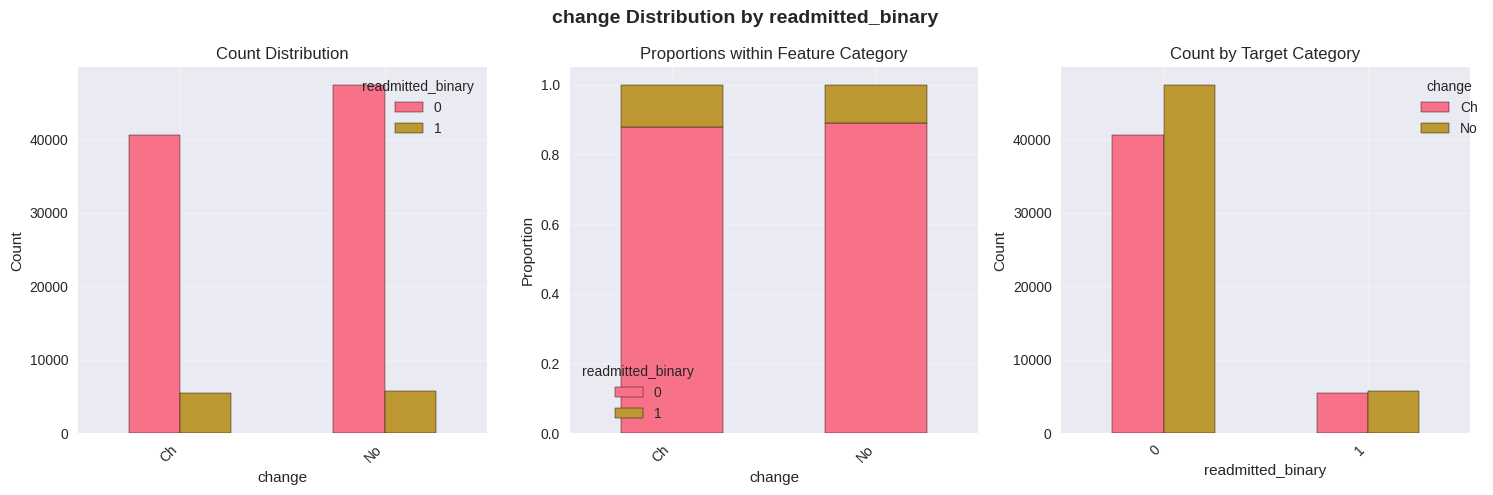


Contingency Table:
readmitted_binary      0     1
change                        
Ch                 40572  5545
No                 47445  5768

Proportions:
readmitted_binary         0         1
change                               
Ch                 0.879762  0.120238
No                 0.891605  0.108395

Chi-square test:
  Test Statistic: 34.2184
  P-value: 4.9261e-09
  Cramér's V: 0.0186
  Significant at α=0.05: Yes

Analyzing: diabetesMed


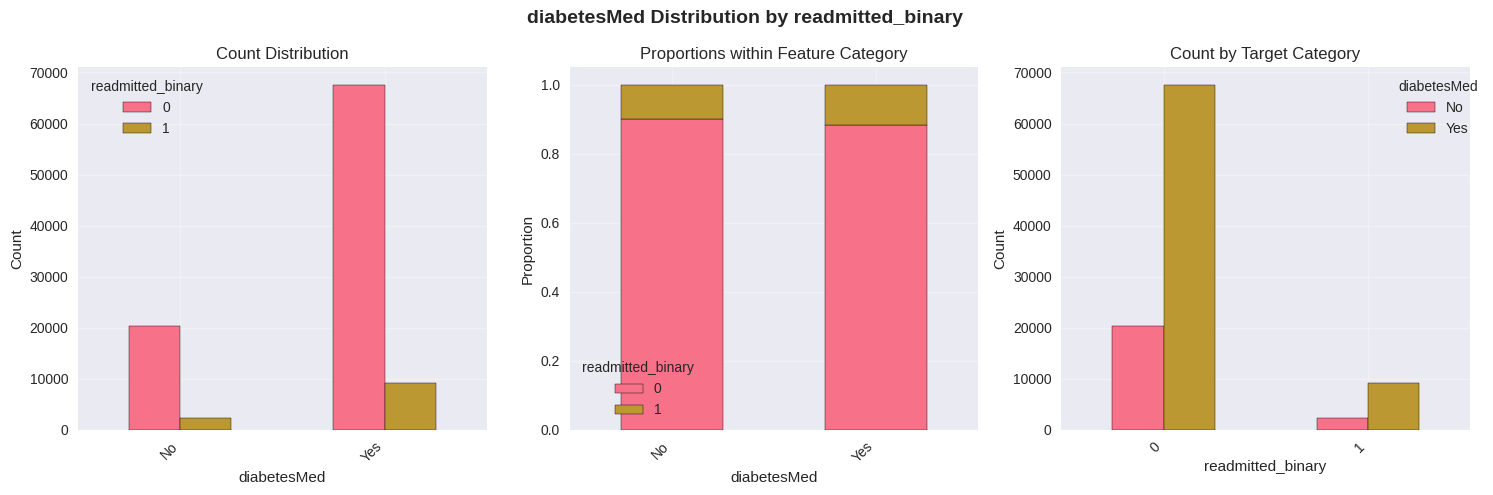


Contingency Table:
readmitted_binary      0     1
diabetesMed                   
No                 20388  2233
Yes                67629  9080

Proportions:
readmitted_binary         0         1
diabetesMed                          
No                 0.901286  0.098714
Yes                0.881631  0.118369

Chi-square test:
  Test Statistic: 66.6825
  P-value: 3.1896e-16
  Cramér's V: 0.0259
  Significant at α=0.05: Yes

Analyzing: readmitted


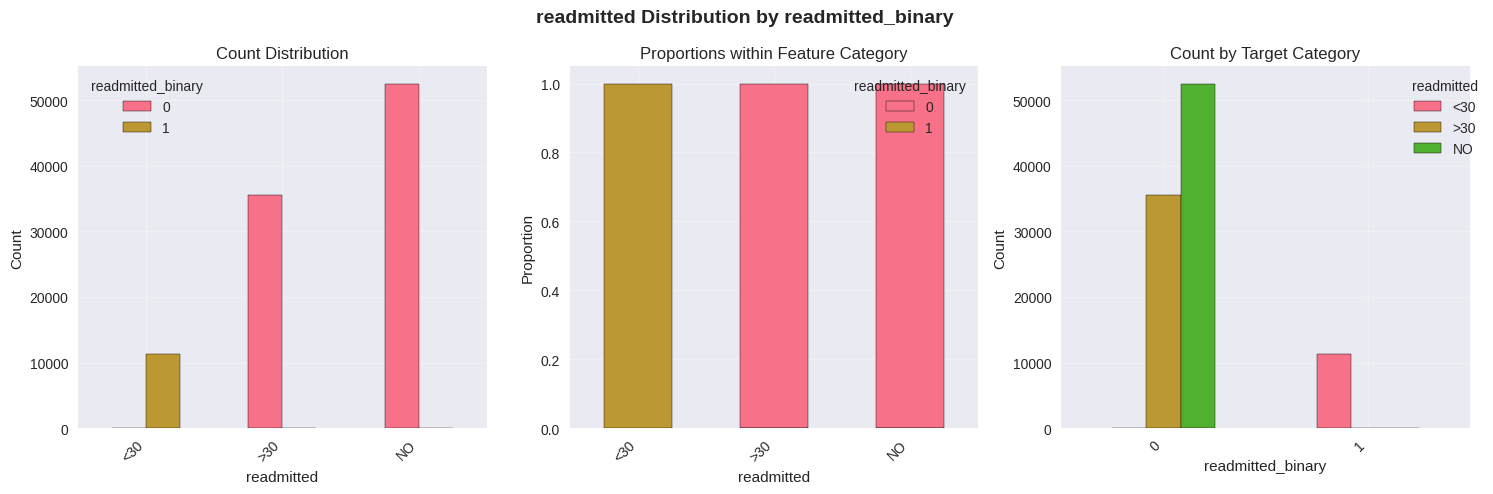


Contingency Table:
readmitted_binary      0      1
readmitted                     
<30                    0  11313
>30                35500      0
NO                 52517      0

Proportions:
readmitted_binary    0    1
readmitted                 
<30                0.0  1.0
>30                1.0  0.0
NO                 1.0  0.0

Chi-square test:
  Test Statistic: 99330.0000
  P-value: 0.0000e+00
  Cramér's V: 1.0000
  Significant at α=0.05: Yes

Analyzing: admission_type_group


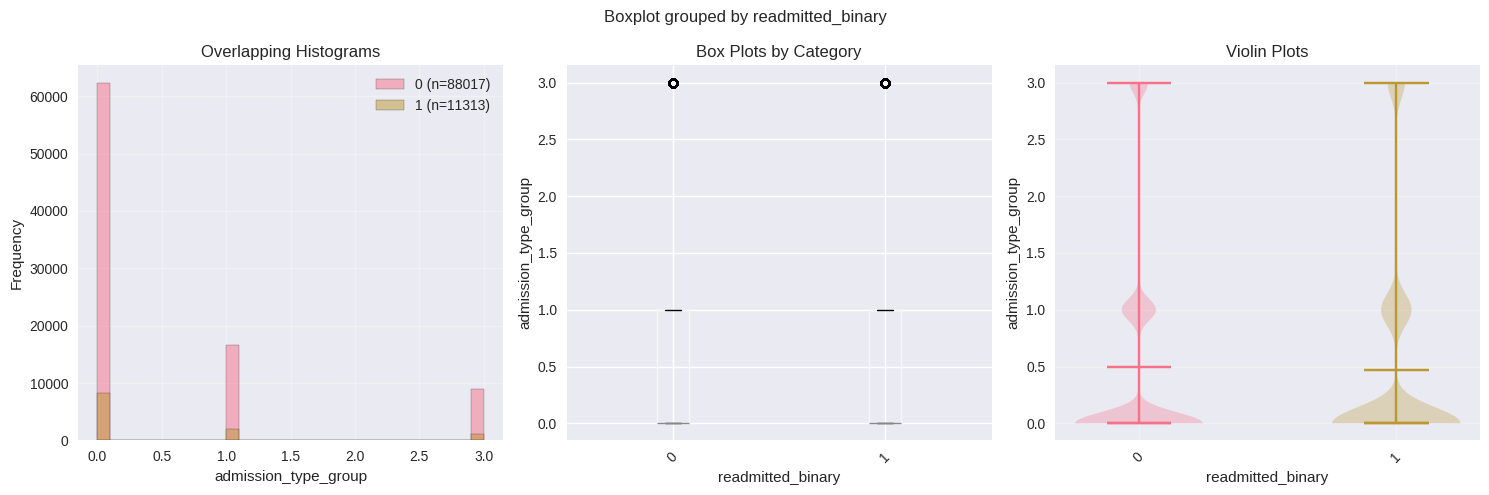


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.497995  0.930762  0.0  0.0  0.0  1.0  3.0
1                  11313.0  0.465571  0.913170  0.0  0.0  0.0  1.0  3.0

Mann-Whitney U test:
  Test Statistic: 508449142.5000
  P-value: 3.7104e-06
  Cohen's d: 0.0352
  Significant at α=0.05: Yes

Analyzing: discharge_disposition_group


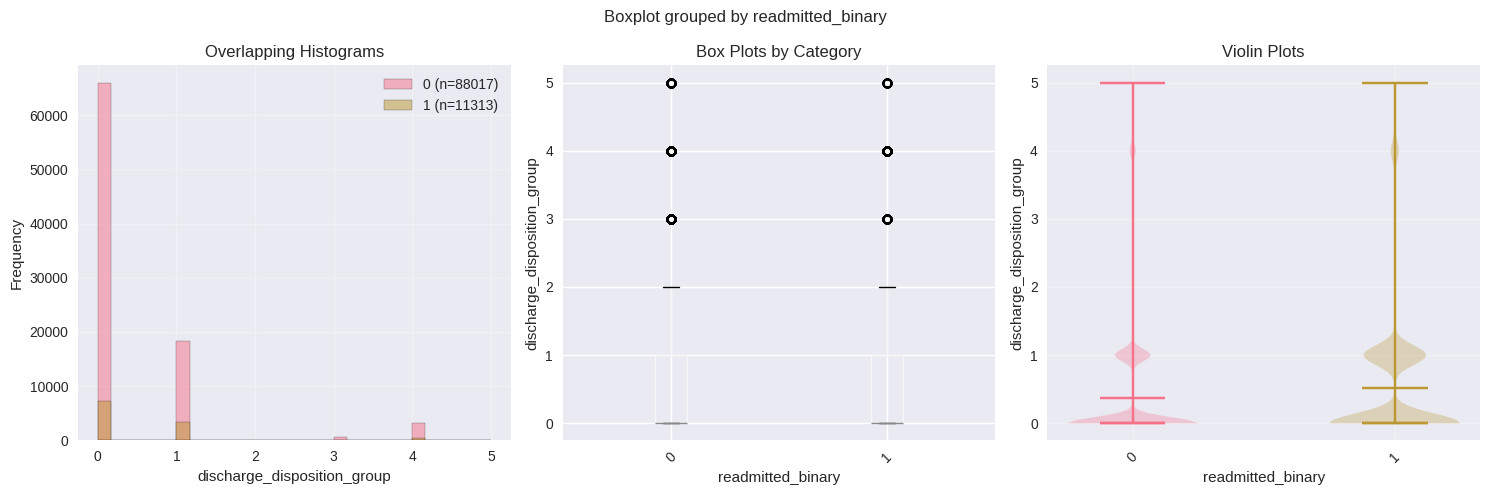


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.377961  0.856298  0.0  0.0  0.0  1.0  5.0
1                  11313.0  0.515955  0.935385  0.0  0.0  0.0  1.0  5.0

Mann-Whitney U test:
  Test Statistic: 444922436.0000
  P-value: 2.8181e-127
  Cohen's d: -0.1539
  Significant at α=0.05: Yes

Analyzing: admission_source_group


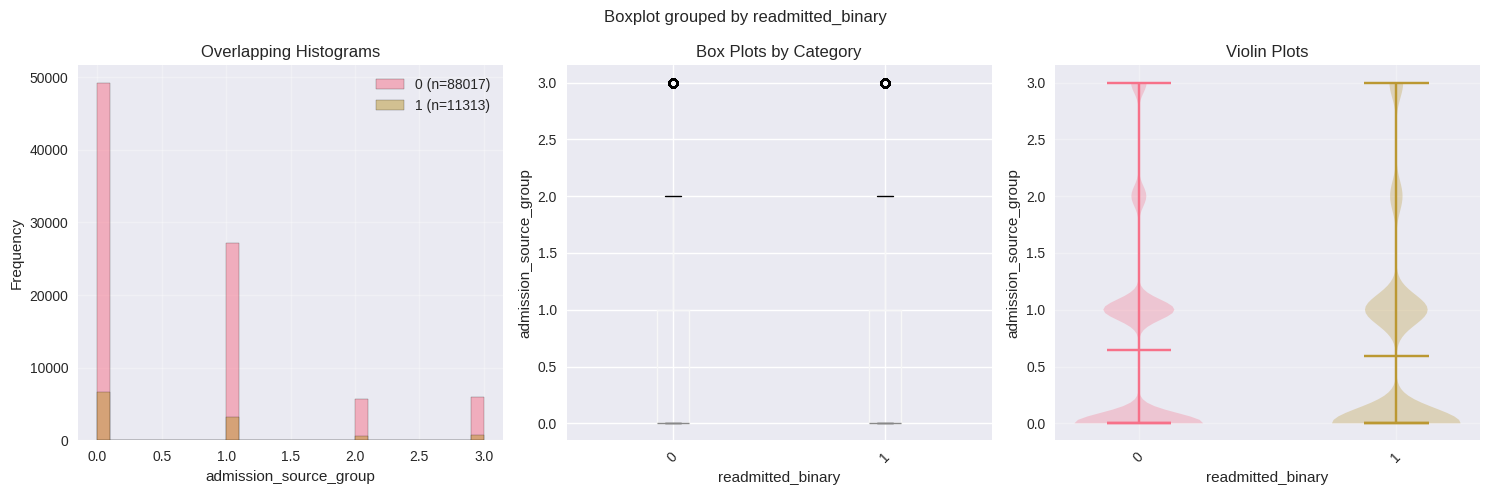


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.642251  0.875830  0.0  0.0  0.0  1.0  3.0
1                  11313.0  0.592504  0.857895  0.0  0.0  0.0  1.0  3.0

Mann-Whitney U test:
  Test Statistic: 514654917.0000
  P-value: 5.1596e-11
  Cohen's d: 0.0574
  Significant at α=0.05: Yes

Analyzing: prior_year_visits


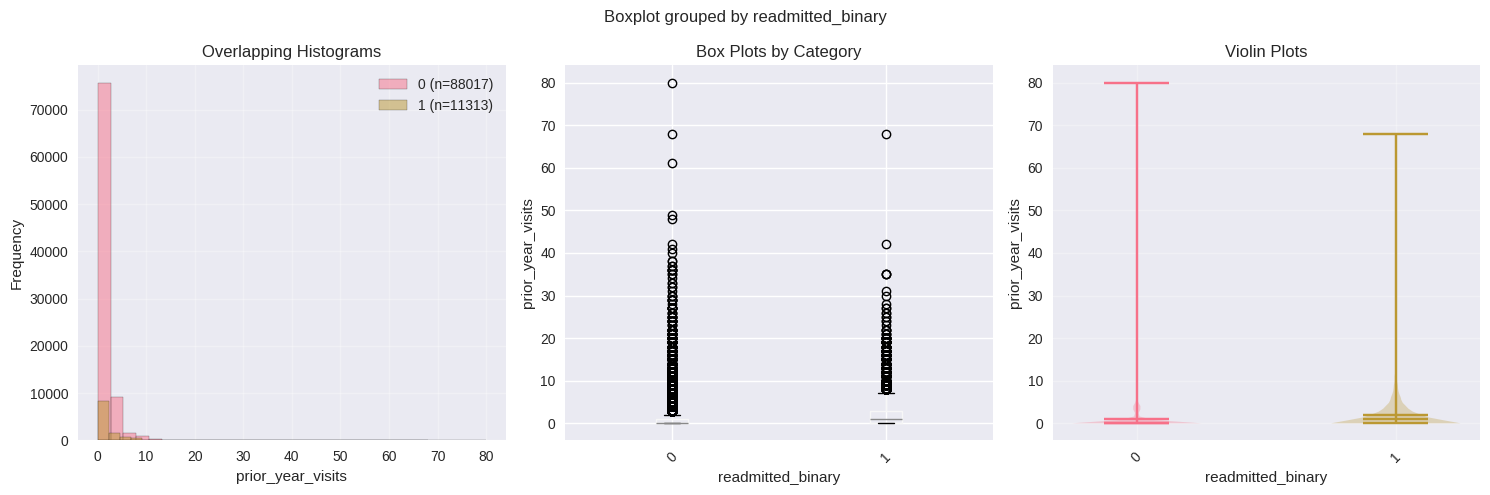


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%   max
readmitted_binary                                                       
0                  88017.0  1.093505  2.134834  0.0  0.0  0.0  1.0  80.0
1                  11313.0  2.017502  3.162928  0.0  0.0  1.0  3.0  68.0

Mann-Whitney U test:
  Test Statistic: 394095606.5000
  P-value: 0.0000e+00
  Cohen's d: -0.3424
  Significant at α=0.05: Yes

Analyzing: insulin_change_flag


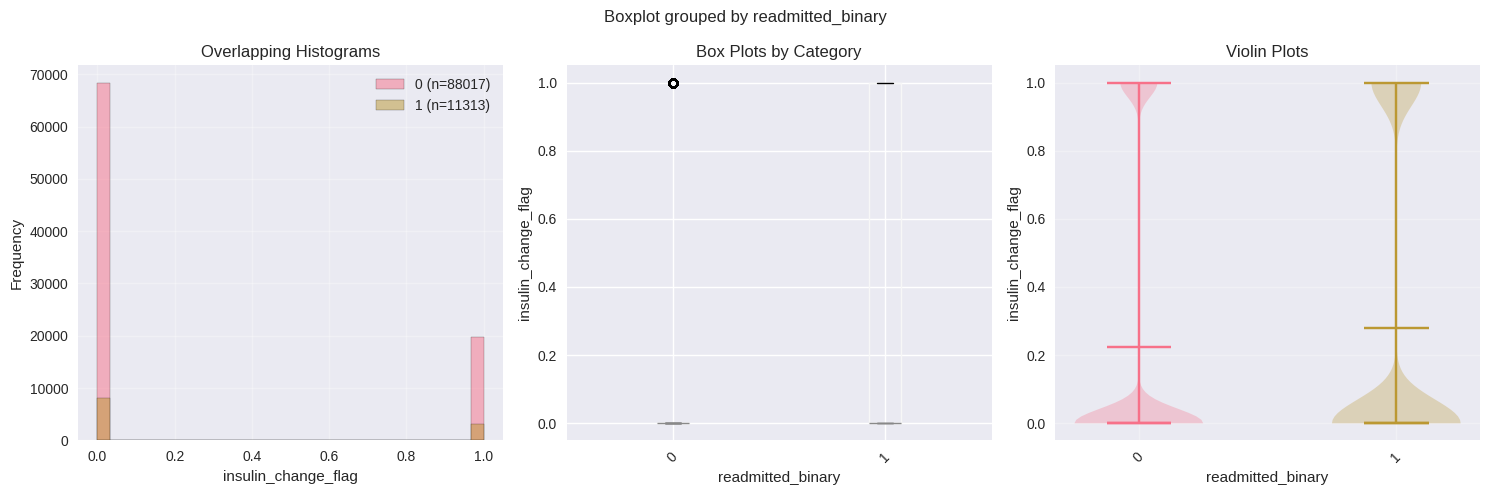


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.224229  0.417076  0.0  0.0  0.0  0.0  1.0
1                  11313.0  0.279148  0.448600  0.0  0.0  0.0  1.0  1.0

Mann-Whitney U test:
  Test Statistic: 470526001.5000
  P-value: 5.8532e-39
  Cohen's d: -0.1268
  Significant at α=0.05: Yes

Analyzing: metformin_change_flag


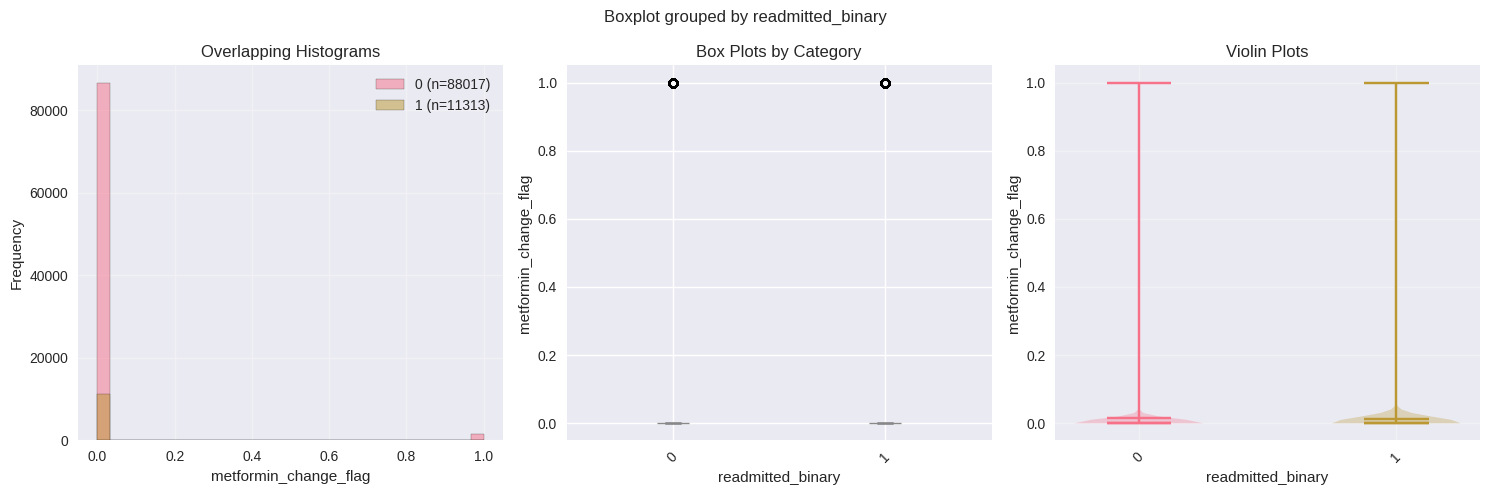


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.016815  0.128578  0.0  0.0  0.0  0.0  1.0
1                  11313.0  0.013878  0.116989  0.0  0.0  0.0  0.0  1.0

Mann-Whitney U test:
  Test Statistic: 499330446.0000
  P-value: 2.0900e-02
  Cohen's d: 0.0239
  Significant at α=0.05: Yes

Analyzing: glipizide_change_flag


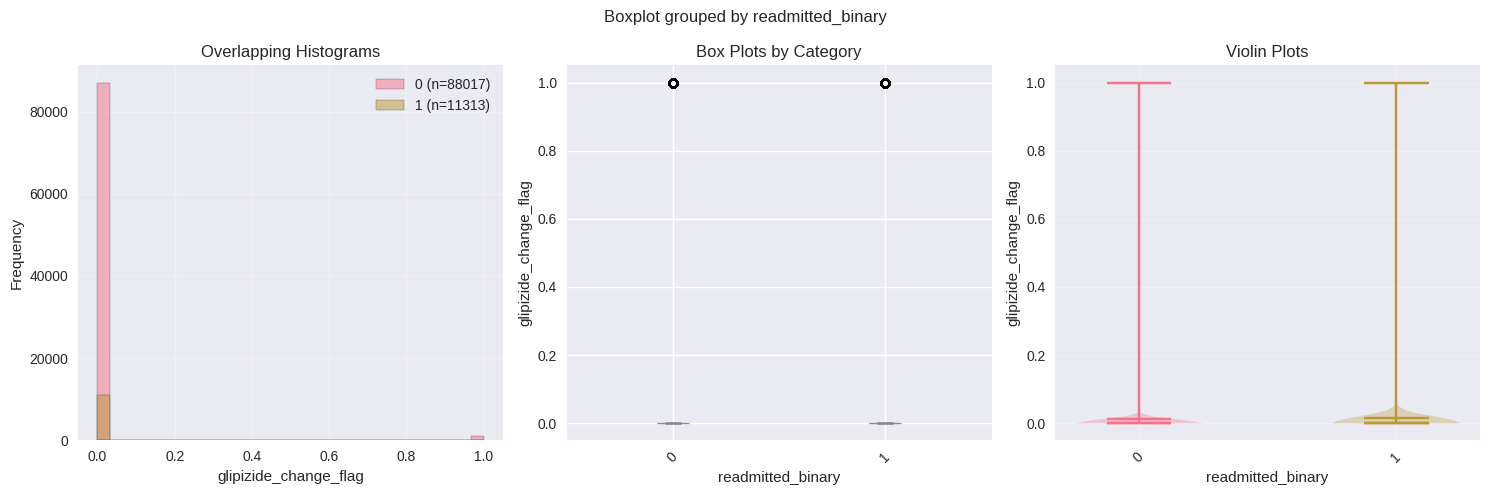


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.012816  0.112479  0.0  0.0  0.0  0.0  1.0
1                  11313.0  0.016264  0.126496  0.0  0.0  0.0  0.0  1.0

Mann-Whitney U test:
  Test Statistic: 496151128.5000
  P-value: 2.4904e-03
  Cohen's d: -0.0288
  Significant at α=0.05: Yes

Analyzing: glyburide_change_flag


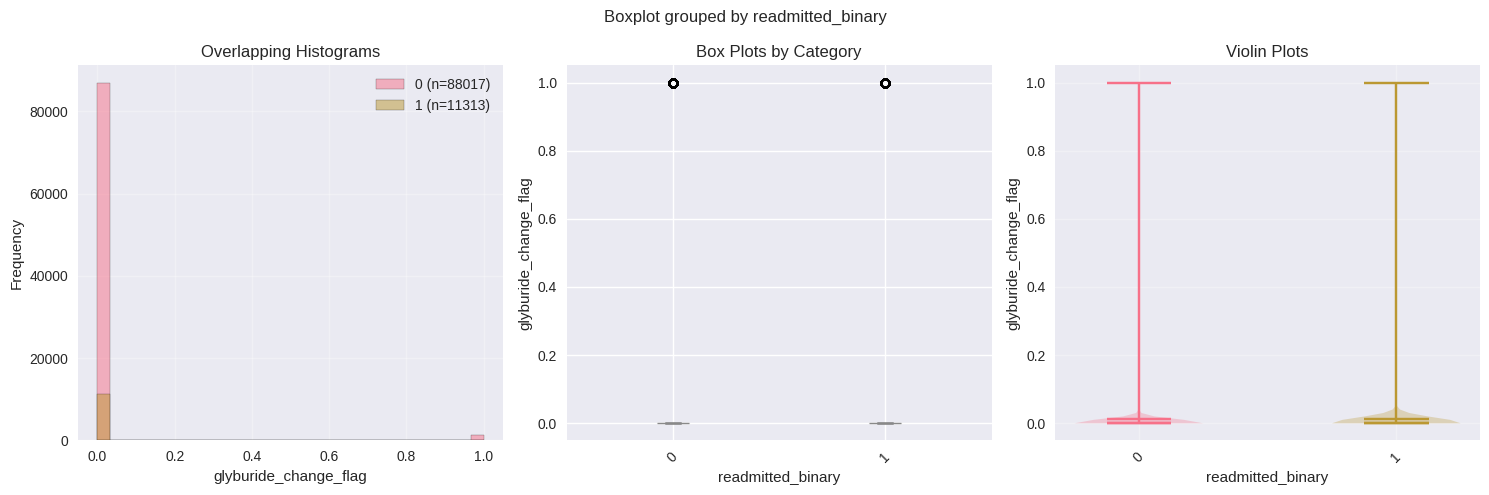


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.013906  0.117103  0.0  0.0  0.0  0.0  1.0
1                  11313.0  0.012110  0.109382  0.0  0.0  0.0  0.0  1.0

Mann-Whitney U test:
  Test Statistic: 498762552.0000
  P-value: 1.2181e-01
  Cohen's d: 0.0159
  Significant at α=0.05: No

Analyzing: A1Cresult_ord


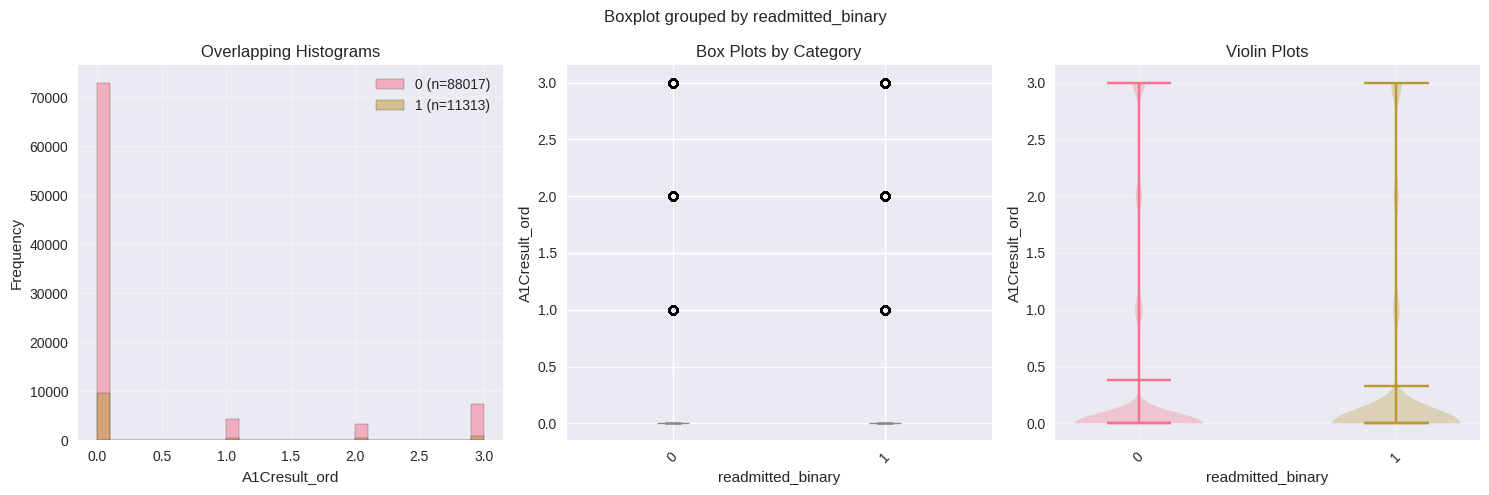


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.377257  0.900841  0.0  0.0  0.0  0.0  3.0
1                  11313.0  0.324759  0.846243  0.0  0.0  0.0  0.0  3.0

Mann-Whitney U test:
  Test Statistic: 509951723.5000
  P-value: 1.1493e-10
  Cohen's d: 0.0601
  Significant at α=0.05: Yes

Analyzing: max_glu_serum_ord


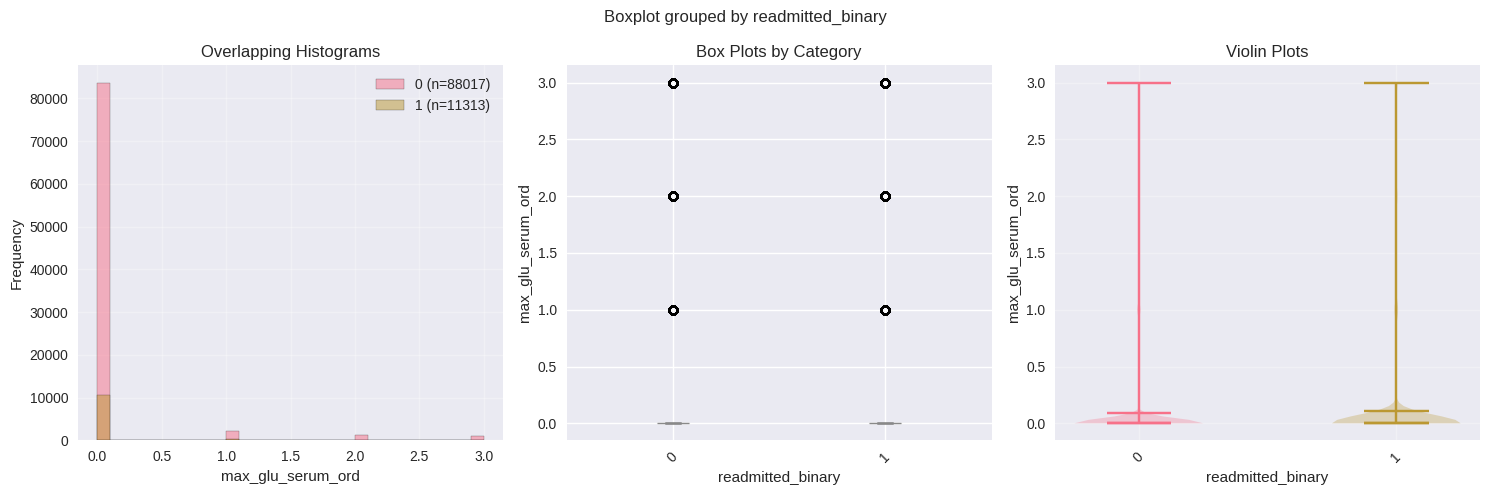


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.088028  0.420864  0.0  0.0  0.0  0.0  3.0
1                  11313.0  0.105984  0.471418  0.0  0.0  0.0  0.0  3.0

Mann-Whitney U test:
  Test Statistic: 494284150.5000
  P-value: 1.1588e-03
  Cohen's d: -0.0402
  Significant at α=0.05: Yes

Analyzing: change_flag


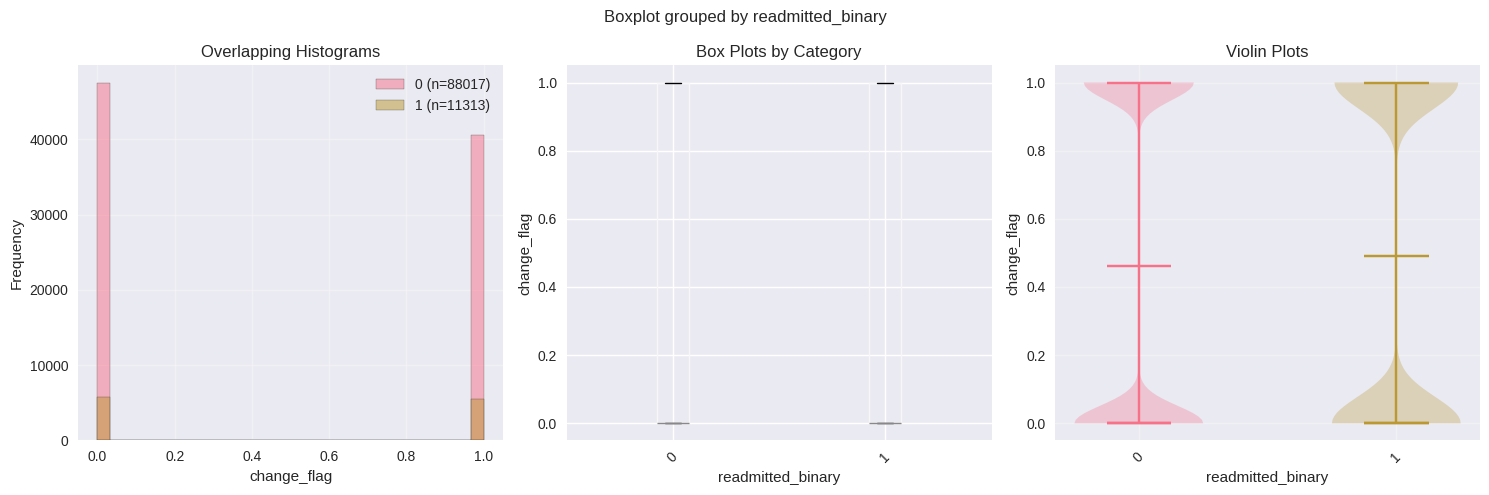


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.460956  0.498476  0.0  0.0  0.0  1.0  1.0
1                  11313.0  0.490144  0.499925  0.0  0.0  0.0  1.0  1.0

Mann-Whitney U test:
  Test Statistic: 483336546.0000
  P-value: 4.6390e-09
  Cohen's d: -0.0585
  Significant at α=0.05: Yes

Analyzing: diabetesMed_flag


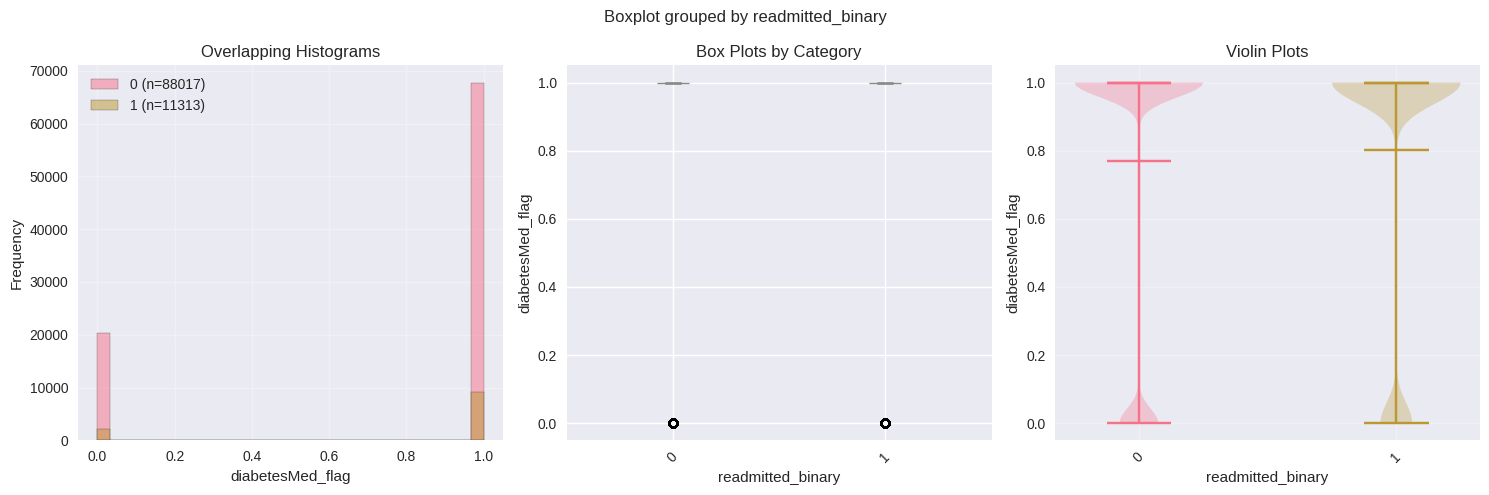


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.768363  0.421881  0.0  1.0  1.0  1.0  1.0
1                  11313.0  0.802616  0.398042  0.0  1.0  1.0  1.0  1.0

Mann-Whitney U test:
  Test Statistic: 480814419.0000
  P-value: 2.8907e-16
  Cohen's d: -0.0835
  Significant at α=0.05: Yes

Analyzing: gender_flag


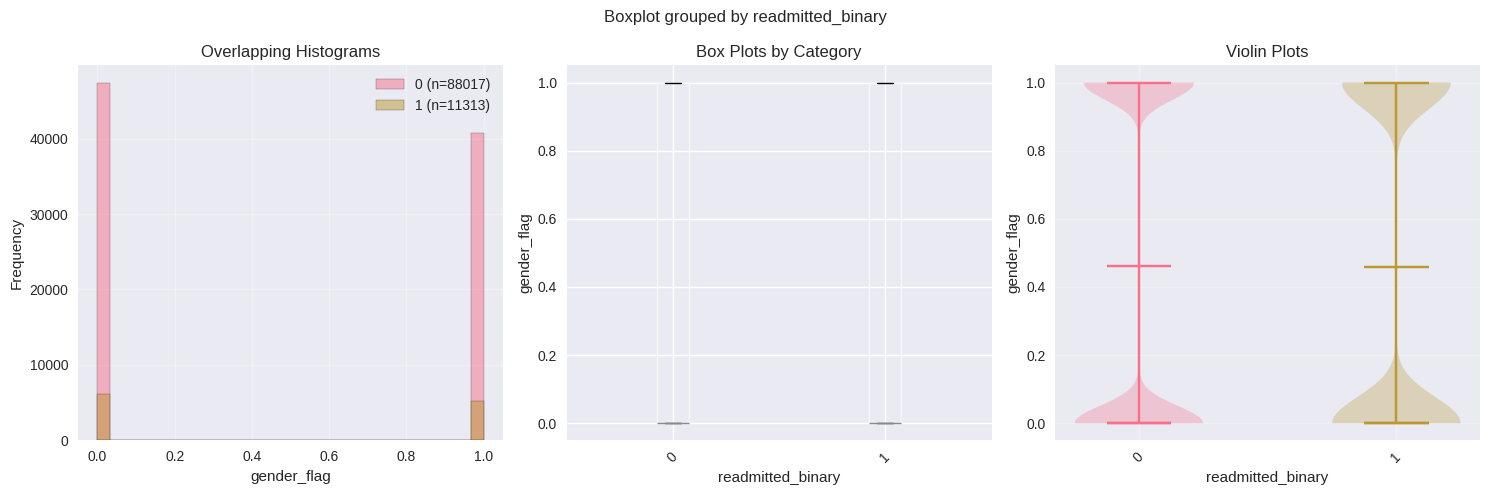


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.462331  0.498582  0.0  0.0  0.0  1.0  1.0
1                  11313.0  0.458411  0.498289  0.0  0.0  0.0  1.0  1.0

Mann-Whitney U test:
  Test Statistic: 499820034.0000
  P-value: 4.3108e-01
  Cohen's d: 0.0079
  Significant at α=0.05: No

Analyzing: race_ord


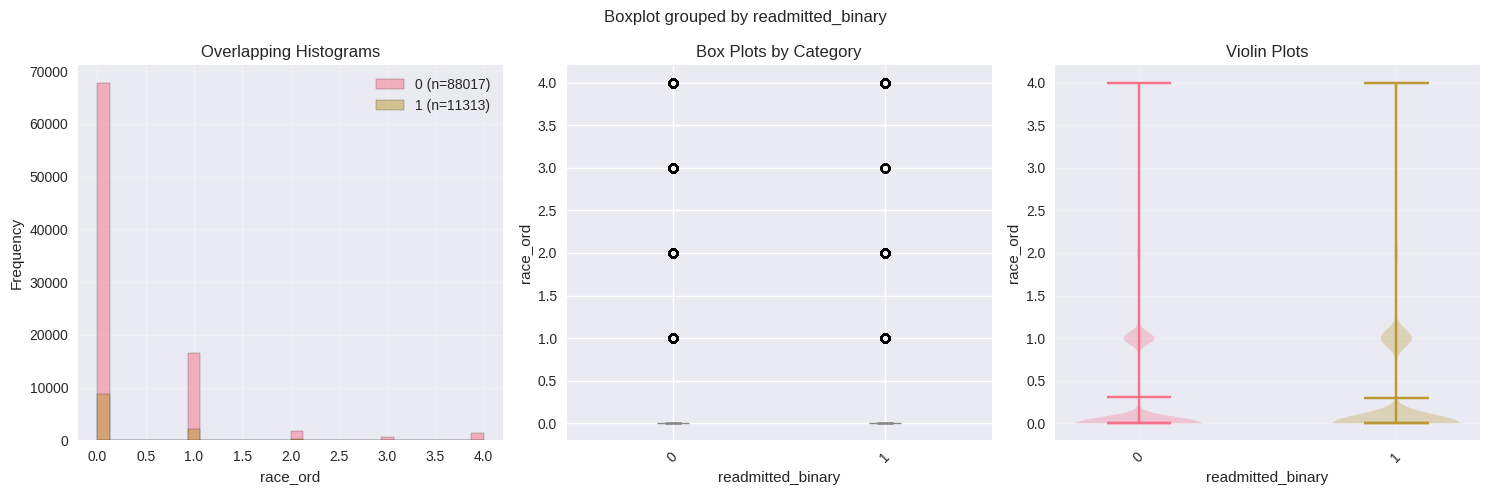


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.309270  0.688351  0.0  0.0  0.0  0.0  4.0
1                  11313.0  0.295589  0.657991  0.0  0.0  0.0  0.0  4.0

Mann-Whitney U test:
  Test Statistic: 500149617.5000
  P-value: 2.7834e-01
  Cohen's d: 0.0203
  Significant at α=0.05: No

Analyzing: age_numeric


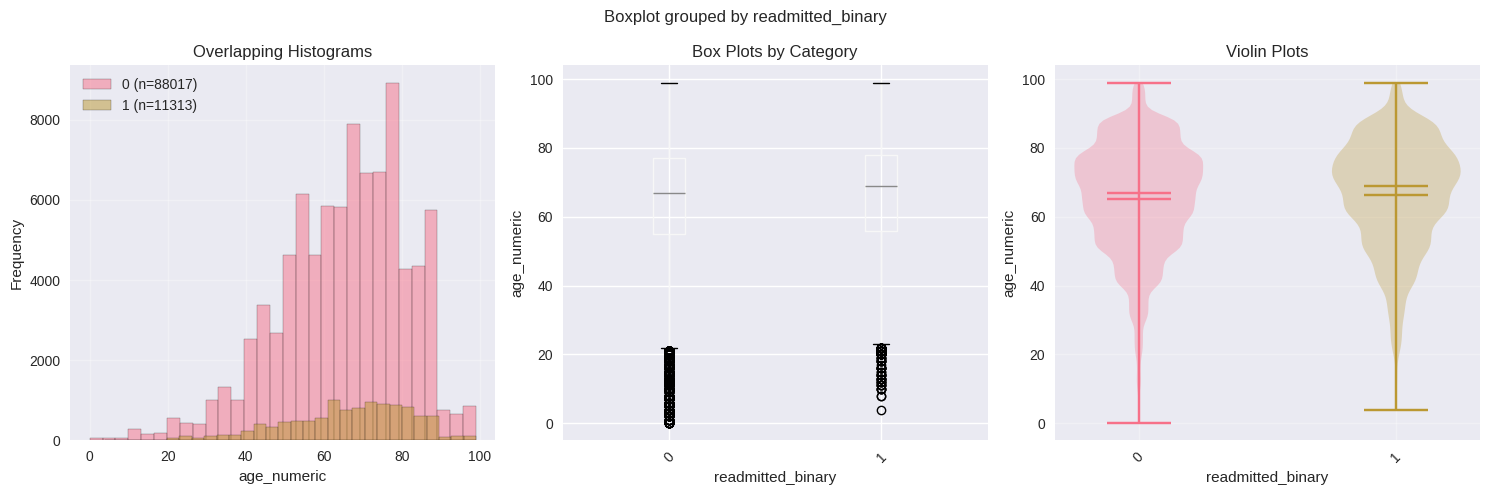


Descriptive Statistics:
                     count       mean        std  min   25%   50%   75%   max
readmitted_binary                                                            
0                  88017.0  65.122011  16.202316  0.0  55.0  67.0  77.0  99.0
1                  11313.0  66.200831  16.023894  4.0  56.0  69.0  78.0  99.0

Mann-Whitney U test:
  Test Statistic: 477172715.5000
  P-value: 5.5963e-13
  Cohen's d: -0.0670
  Significant at α=0.05: Yes

Analyzing: diag_1_group


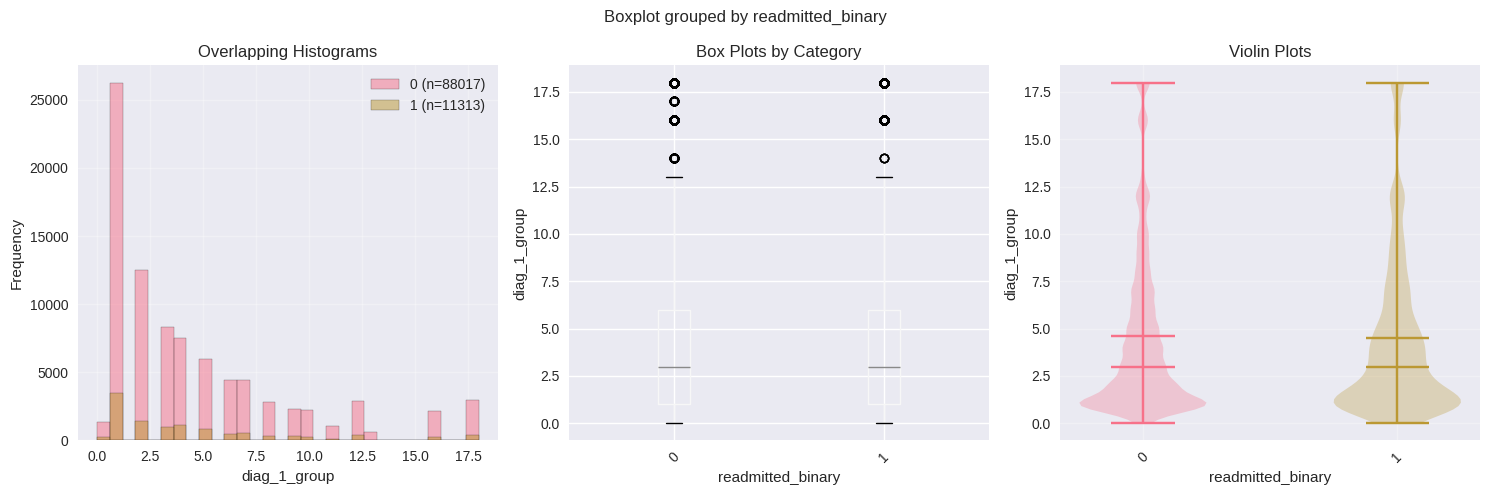


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%   max
readmitted_binary                                                       
0                  88017.0  4.585103  4.424074  0.0  1.0  3.0  6.0  18.0
1                  11313.0  4.525590  4.429102  0.0  1.0  3.0  6.0  18.0

Mann-Whitney U test:
  Test Statistic: 504313948.5000
  P-value: 2.2513e-02
  Cohen's d: 0.0134
  Significant at α=0.05: Yes

Analyzing: diag_2_group


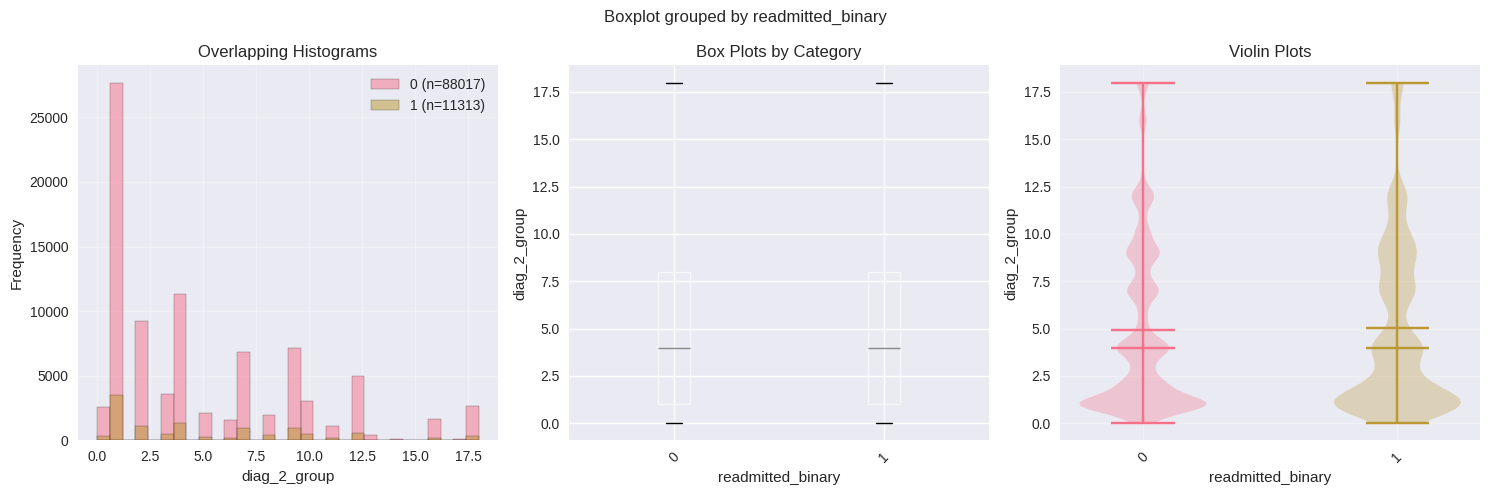


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%   max
readmitted_binary                                                       
0                  88017.0  4.942659  4.569831  0.0  1.0  4.0  8.0  18.0
1                  11313.0  5.016618  4.561218  0.0  1.0  4.0  8.0  18.0

Mann-Whitney U test:
  Test Statistic: 492754876.0000
  P-value: 6.9754e-02
  Cohen's d: -0.0162
  Significant at α=0.05: No

Analyzing: diag_3_group


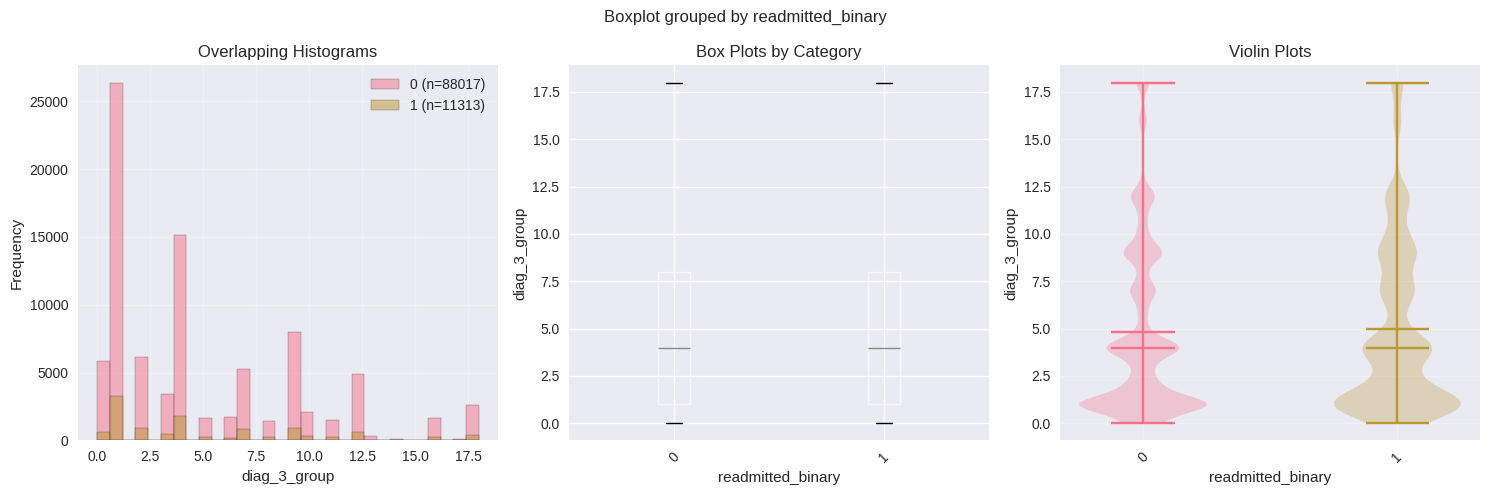


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%   max
readmitted_binary                                                       
0                  88017.0  4.812968  4.568779  0.0  1.0  4.0  8.0  18.0
1                  11313.0  4.985150  4.592052  0.0  1.0  4.0  8.0  18.0

Mann-Whitney U test:
  Test Statistic: 484475264.5000
  P-value: 2.0883e-06
  Cohen's d: -0.0376
  Significant at α=0.05: Yes

Analyzing: total_healthcare_encounters


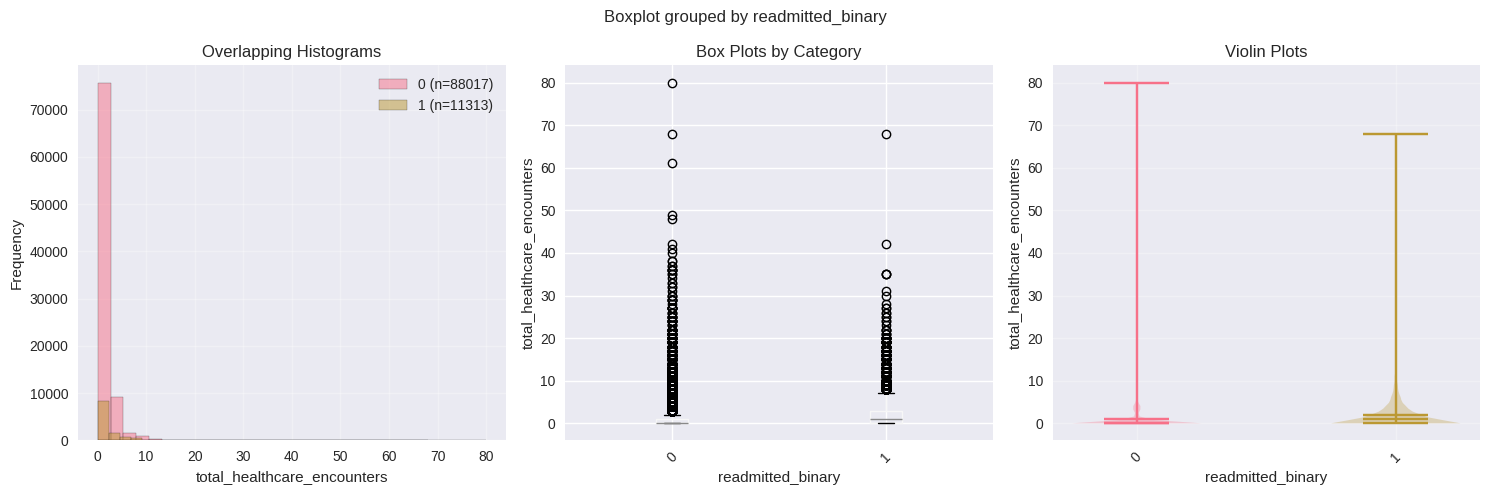


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%   max
readmitted_binary                                                       
0                  88017.0  1.093505  2.134834  0.0  0.0  0.0  1.0  80.0
1                  11313.0  2.017502  3.162928  0.0  0.0  1.0  3.0  68.0

Mann-Whitney U test:
  Test Statistic: 394095606.5000
  P-value: 0.0000e+00
  Cohen's d: -0.3424
  Significant at α=0.05: Yes

Analyzing: emergency_ratio
⚠️  SKIPPING: Feature has 159 unique values (> 100)
   This feature likely represents IDs or has too many categories for meaningful analysis.

Analyzing: inpatient_ratio
⚠️  SKIPPING: Feature has 160 unique values (> 100)
   This feature likely represents IDs or has too many categories for meaningful analysis.

Analyzing: outpatient_ratio
⚠️  SKIPPING: Feature has 145 unique values (> 100)
   This feature likely represents IDs or has too many categories for meaningful analysis.

Analyzing: clinical_complexity_score


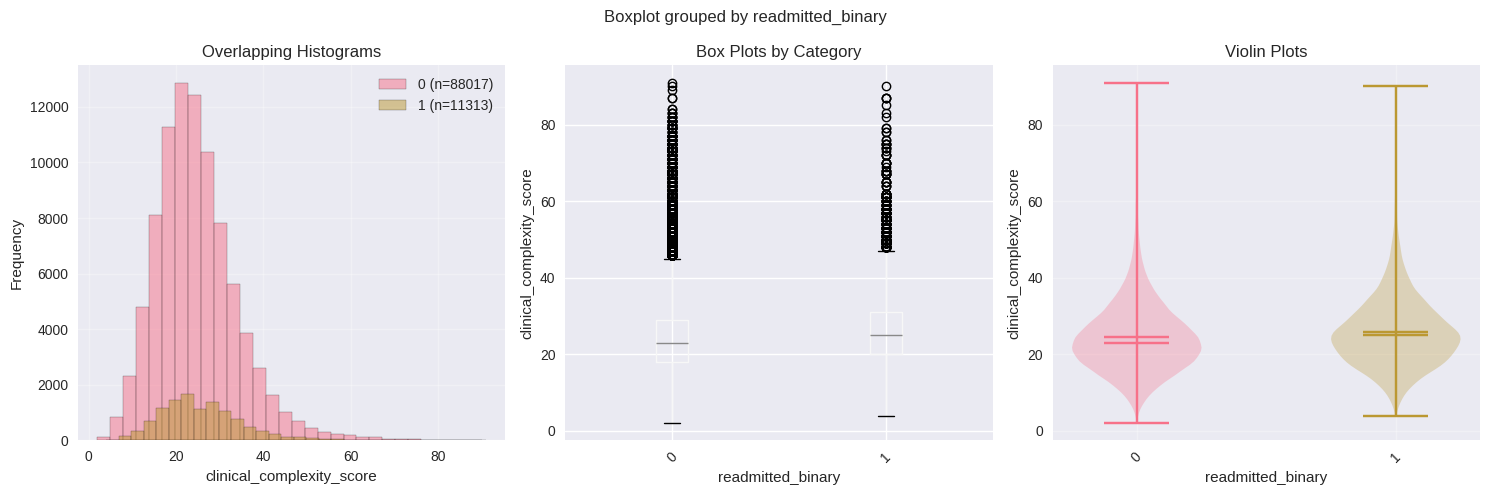


Descriptive Statistics:
                     count       mean       std  min   25%   50%   75%   max
readmitted_binary                                                           
0                  88017.0  24.565243  9.562275  2.0  18.0  23.0  29.0  91.0
1                  11313.0  25.884292  9.471592  4.0  20.0  25.0  31.0  90.0

Mann-Whitney U test:
  Test Statistic: 453183294.5000
  P-value: 1.0806e-54
  Cohen's d: -0.1386
  Significant at α=0.05: Yes

Analyzing: medication_intensity
⚠️  SKIPPING: Feature has 525 unique values (> 100)
   This feature likely represents IDs or has too many categories for meaningful analysis.

Analyzing: lab_intensity
⚠️  SKIPPING: Feature has 874 unique values (> 100)
   This feature likely represents IDs or has too many categories for meaningful analysis.

Analyzing: procedure_intensity


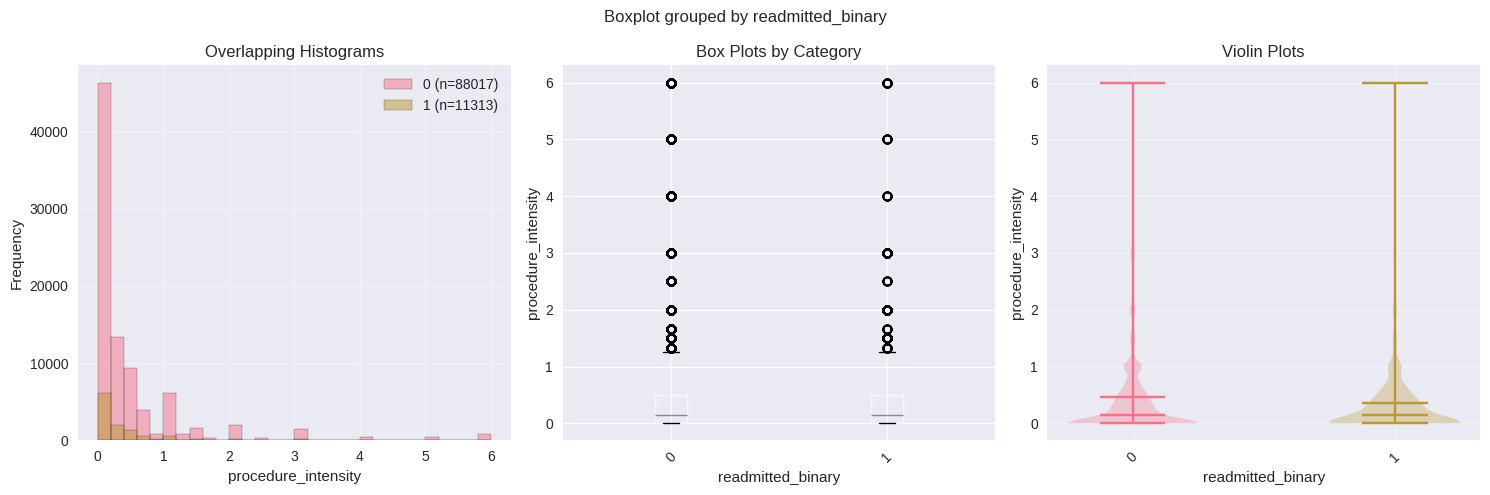


Descriptive Statistics:
                     count      mean       std  min  25%       50%  75%  max
readmitted_binary                                                           
0                  88017.0  0.462615  0.889229  0.0  0.0  0.142857  0.5  6.0
1                  11313.0  0.363363  0.708417  0.0  0.0  0.142857  0.5  6.0

Mann-Whitney U test:
  Test Statistic: 513416265.0000
  P-value: 1.1813e-08
  Cohen's d: 0.1235
  Significant at α=0.05: Yes

Analyzing: medication_per_diagnosis
⚠️  SKIPPING: Feature has 353 unique values (> 100)
   This feature likely represents IDs or has too many categories for meaningful analysis.

Analyzing: lab_per_diagnosis
⚠️  SKIPPING: Feature has 592 unique values (> 100)
   This feature likely represents IDs or has too many categories for meaningful analysis.

Analyzing: procedures_per_diagnosis


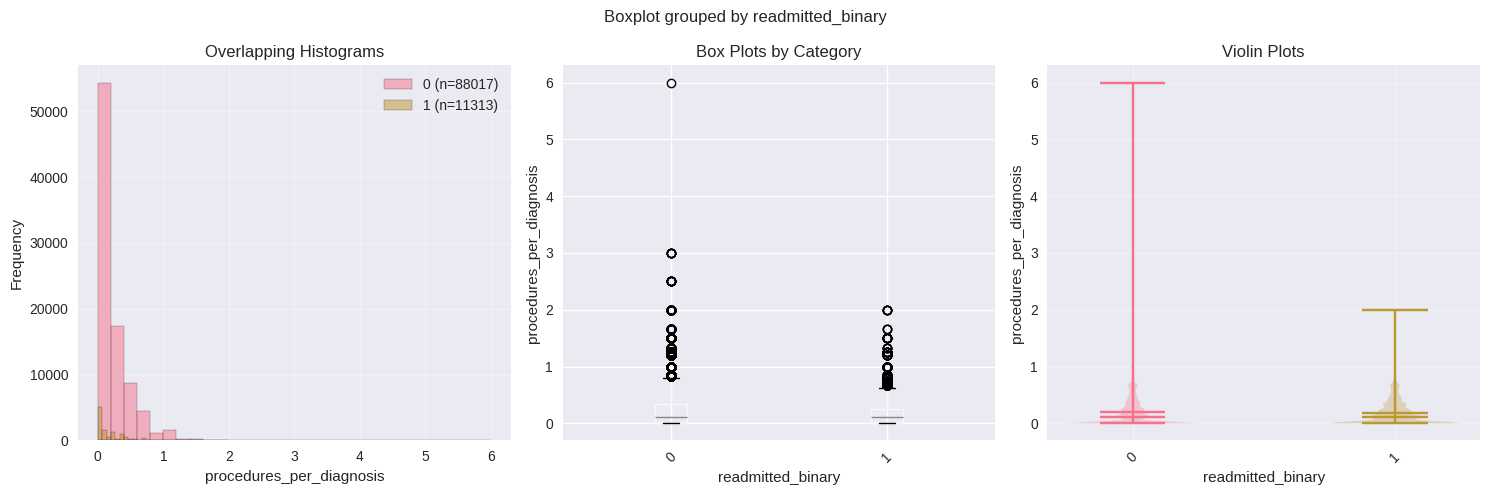


Descriptive Statistics:
                     count      mean       std  min  25%       50%       75%  \
readmitted_binary                                                              
0                  88017.0  0.194855  0.268381  0.0  0.0  0.111111  0.333333   
1                  11313.0  0.173132  0.231894  0.0  0.0  0.111111  0.250000   

                   max  
readmitted_binary       
0                  6.0  
1                  2.0  

Mann-Whitney U test:
  Test Statistic: 507944321.0000
  P-value: 2.1803e-04
  Cohen's d: 0.0866
  Significant at α=0.05: Yes

Analyzing: diabetes_med_change_count


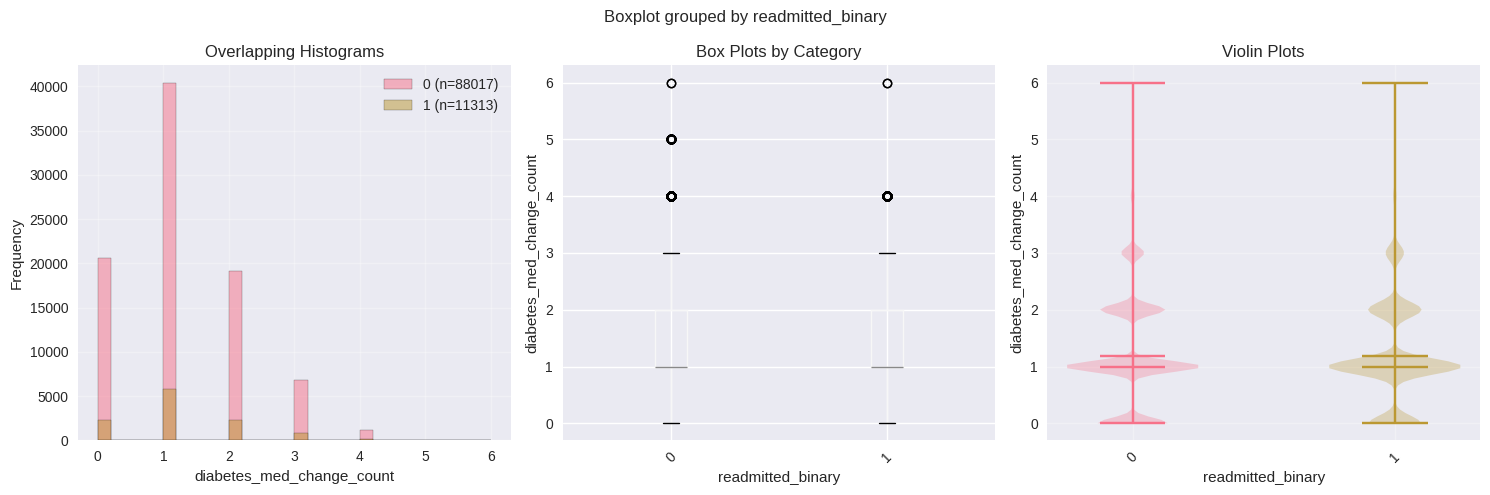


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  1.179863  0.925546  0.0  1.0  1.0  2.0  6.0
1                  11313.0  1.182799  0.873444  0.0  1.0  1.0  2.0  6.0

Mann-Whitney U test:
  Test Statistic: 494290322.0000
  P-value: 1.8331e-01
  Cohen's d: -0.0033
  Significant at α=0.05: No

Analyzing: any_diabetes_med_change


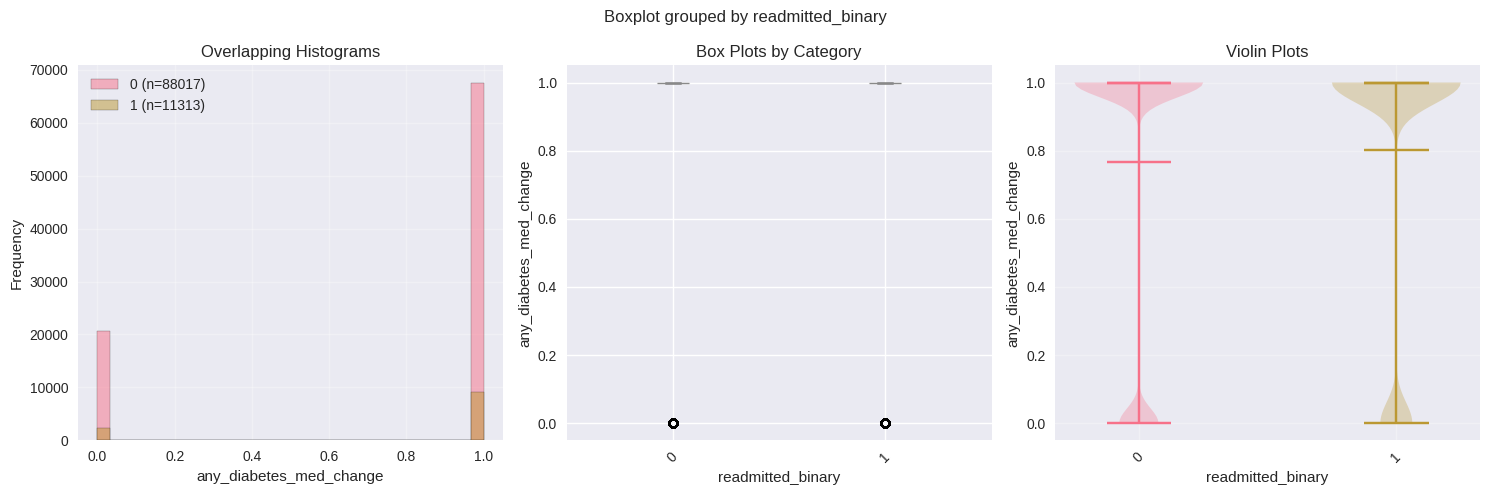


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.766261  0.423210  0.0  1.0  1.0  1.0  1.0
1                  11313.0  0.800760  0.399446  0.0  1.0  1.0  1.0  1.0

Mann-Whitney U test:
  Test Statistic: 480692145.0000
  P-value: 2.2079e-16
  Cohen's d: -0.0838
  Significant at α=0.05: Yes

Analyzing: has_diabetes_meds


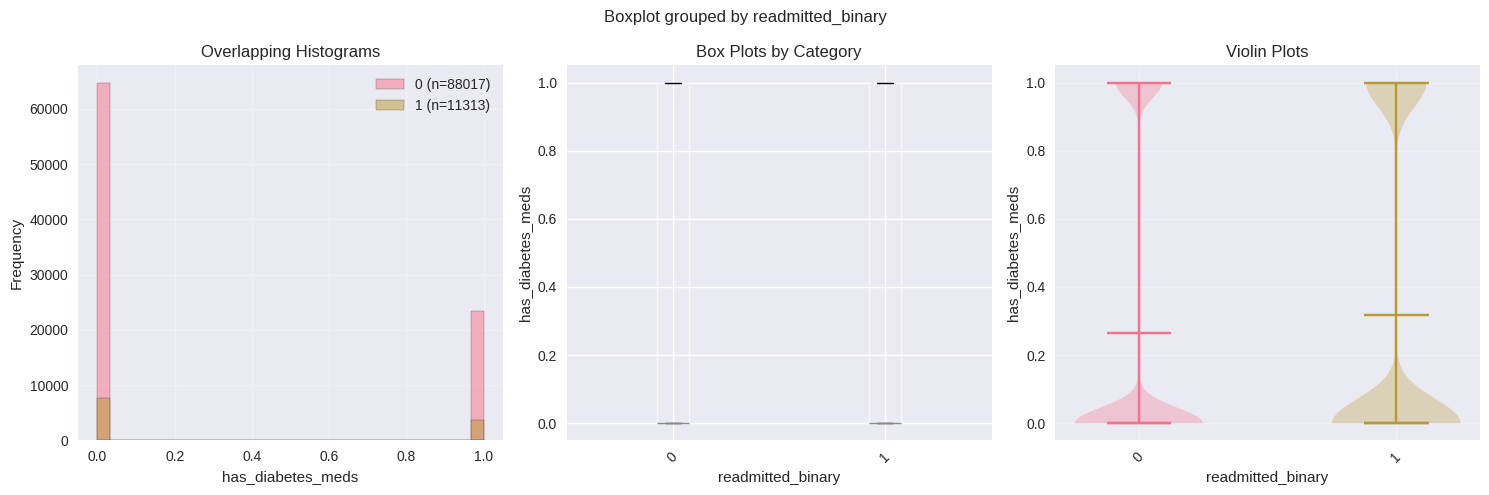


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.265824  0.441773  0.0  0.0  0.0  1.0  1.0
1                  11313.0  0.318925  0.466081  0.0  0.0  0.0  1.0  1.0

Mann-Whitney U test:
  Test Statistic: 471430623.0000
  P-value: 6.5300e-33
  Cohen's d: -0.1169
  Significant at α=0.05: Yes

Analyzing: high_risk_med_combo


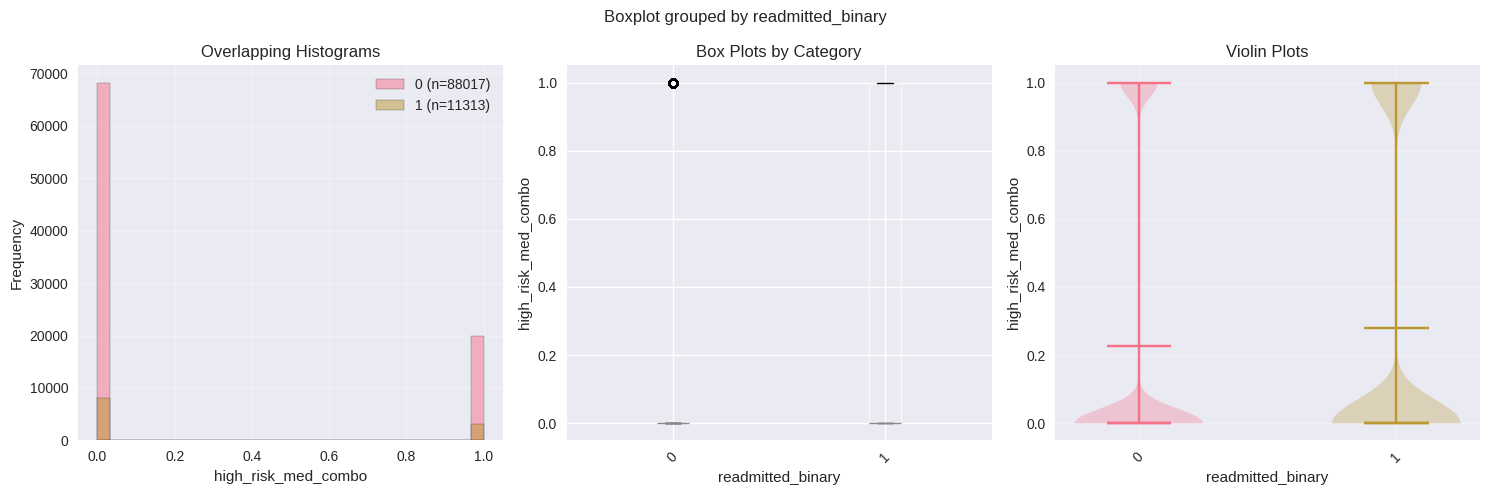


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.226002  0.418243  0.0  0.0  0.0  0.0  1.0
1                  11313.0  0.280916  0.449466  0.0  0.0  0.0  1.0  1.0

Mann-Whitney U test:
  Test Statistic: 470528245.5000
  P-value: 9.3808e-39
  Cohen's d: -0.1265
  Significant at α=0.05: Yes

Analyzing: insulin_changed


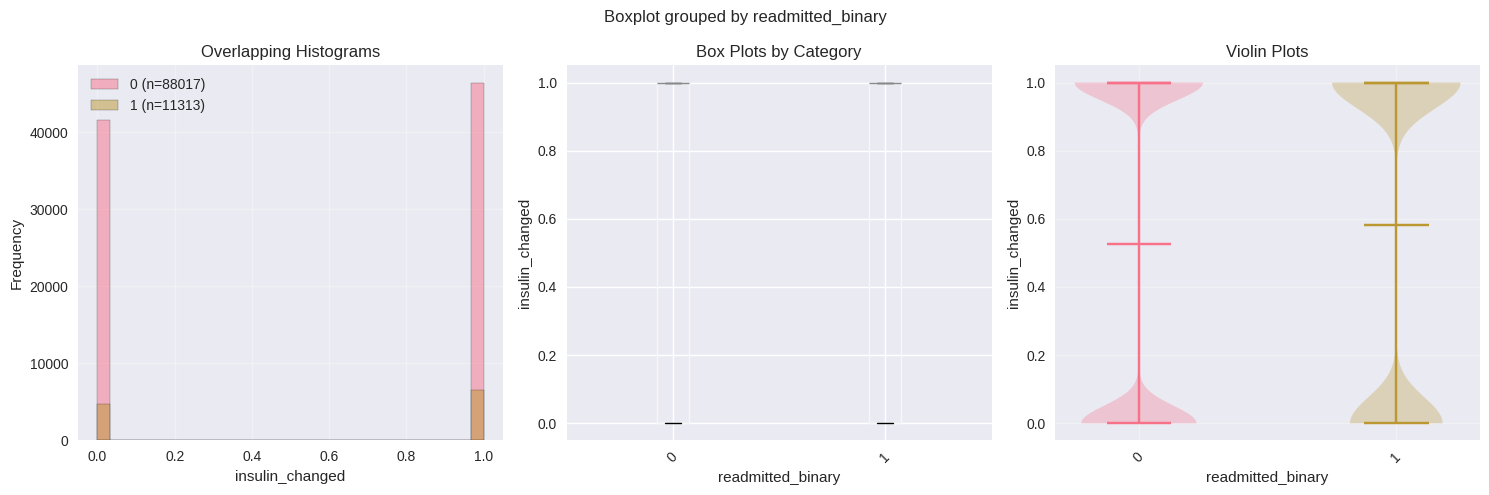


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.526955  0.499276  0.0  0.0  1.0  1.0  1.0
1                  11313.0  0.581367  0.493357  0.0  0.0  1.0  1.0  1.0

Mann-Whitney U test:
  Test Statistic: 470778382.5000
  P-value: 9.2882e-28
  Cohen's d: -0.1096
  Significant at α=0.05: Yes

Analyzing: is_child


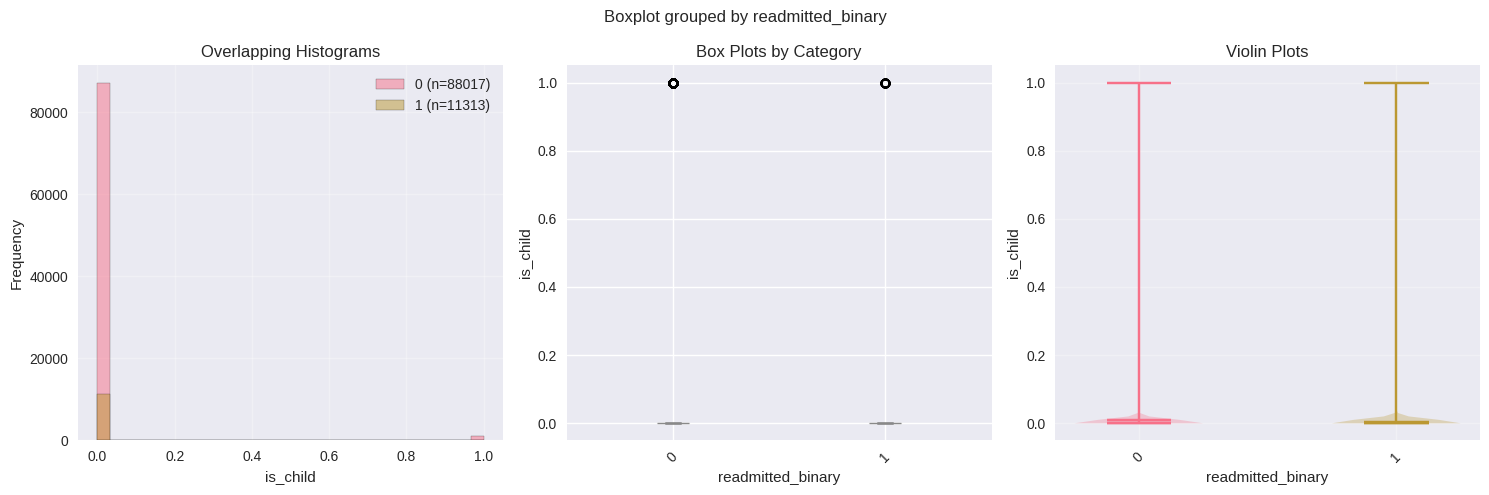


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.010748  0.103114  0.0  0.0  0.0  0.0  1.0
1                  11313.0  0.005215  0.072031  0.0  0.0  0.0  0.0  1.0

Mann-Whitney U test:
  Test Statistic: 500622708.0000
  P-value: 3.1093e-08
  Cohen's d: 0.0622
  Significant at α=0.05: Yes

Analyzing: is_elderly


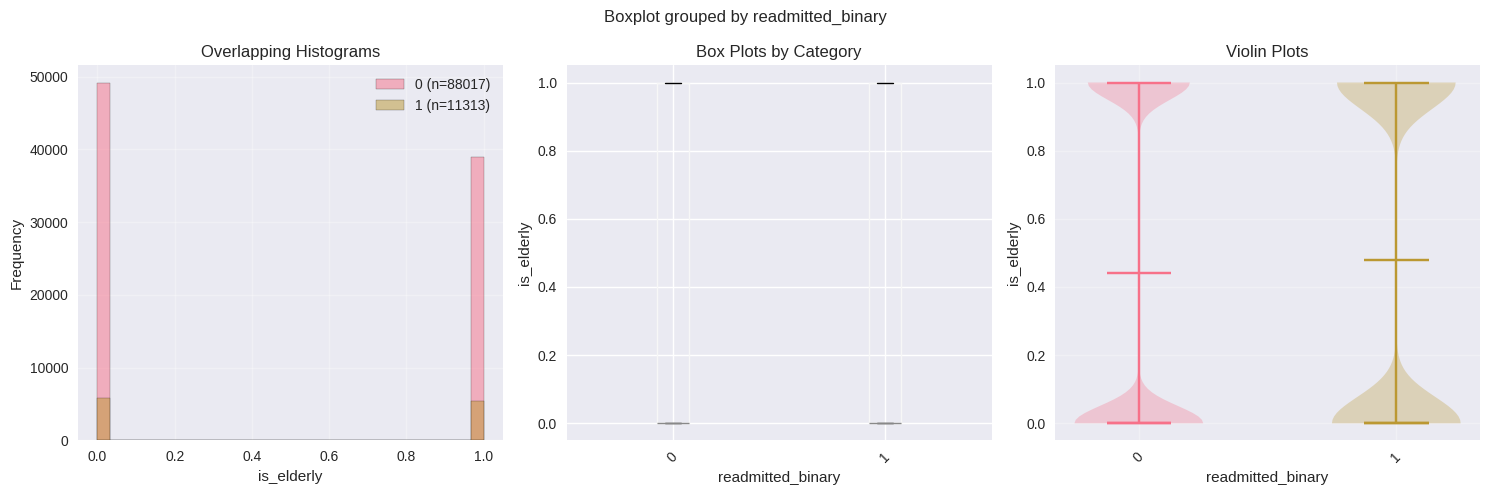


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.442199  0.496651  0.0  0.0  0.0  1.0  1.0
1                  11313.0  0.479714  0.499610  0.0  0.0  0.0  1.0  1.0

Mann-Whitney U test:
  Test Statistic: 479190667.5000
  P-value: 4.1703e-14
  Cohen's d: -0.0753
  Significant at α=0.05: Yes

Analyzing: age_complexity_interaction
⚠️  SKIPPING: Feature has 2105 unique values (> 100)
   This feature likely represents IDs or has too many categories for meaningful analysis.

Analyzing: age_medication_interaction
⚠️  SKIPPING: Feature has 1871 unique values (> 100)
   This feature likely represents IDs or has too many categories for meaningful analysis.

Analyzing: is_emergency_admission


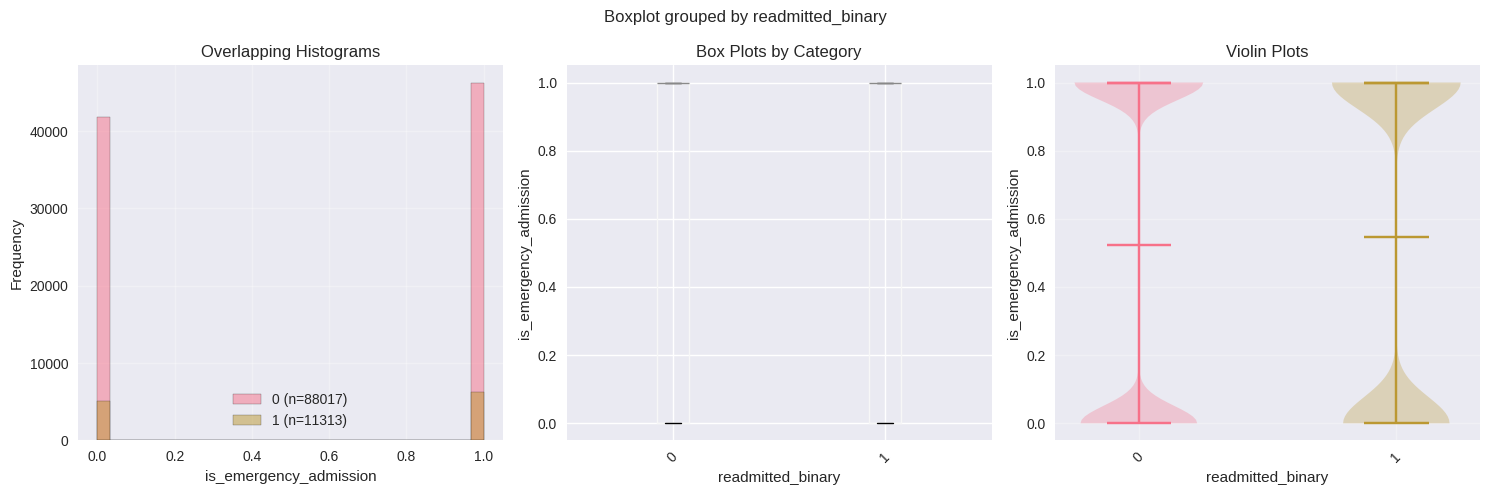


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.524615  0.499397  0.0  0.0  1.0  1.0  1.0
1                  11313.0  0.547512  0.497760  0.0  0.0  1.0  1.0  1.0

Mann-Whitney U test:
  Test Statistic: 486468399.0000
  P-value: 4.3938e-06
  Cohen's d: -0.0459
  Significant at α=0.05: Yes

Analyzing: high_risk_discharge


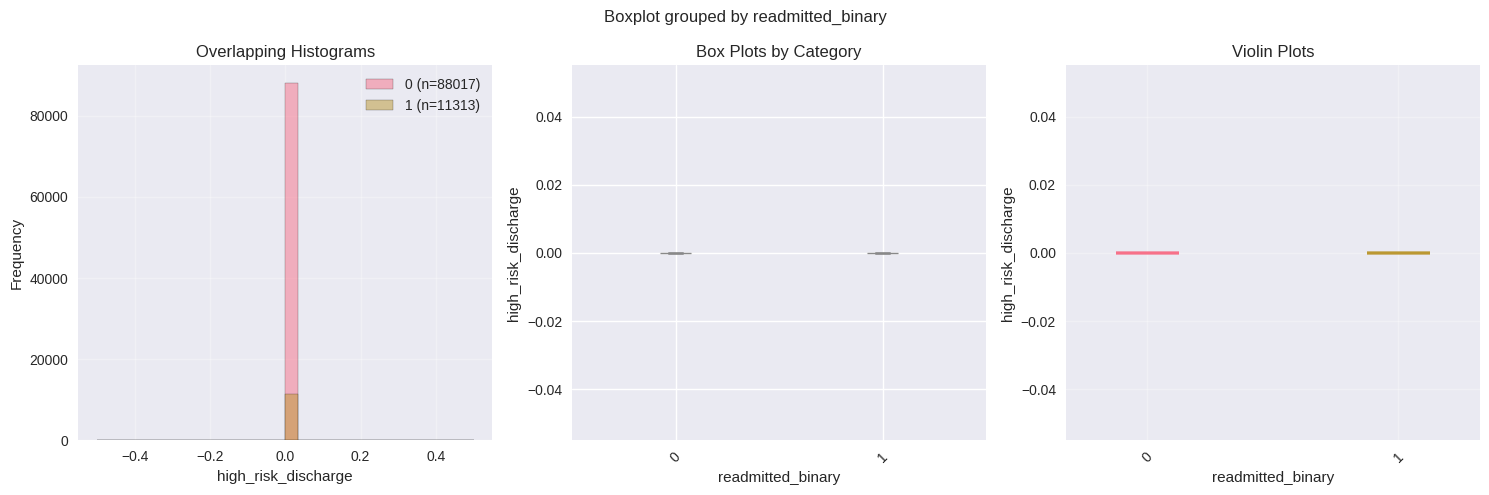


Descriptive Statistics:
                     count  mean  std  min  25%  50%  75%  max
readmitted_binary                                             
0                  88017.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1                  11313.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

Independent t-test:
  Test Statistic: nan
  P-value: nan
  Cohen's d: 0.0000
  Significant at α=0.05: No

Analyzing: long_hospital_stay


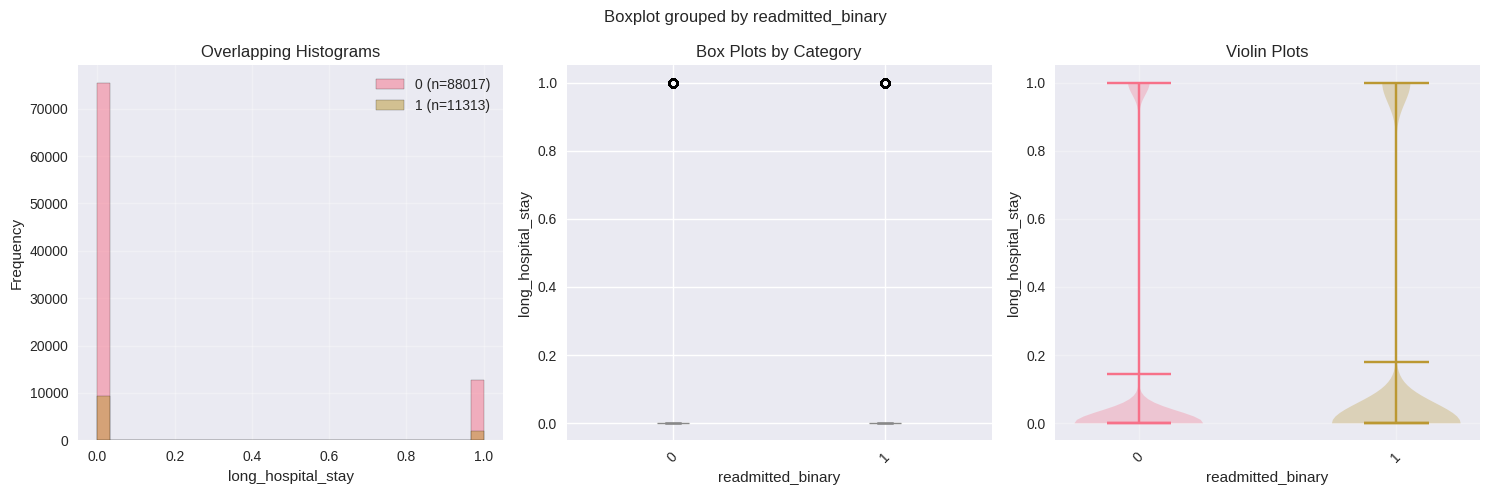


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.143995  0.351087  0.0  0.0  0.0  0.0  1.0
1                  11313.0  0.180058  0.384253  0.0  0.0  0.0  0.0  1.0

Mann-Whitney U test:
  Test Statistic: 479913327.0000
  P-value: 2.8311e-24
  Cohen's d: -0.0980
  Significant at α=0.05: Yes

Analyzing: low_risk_profile


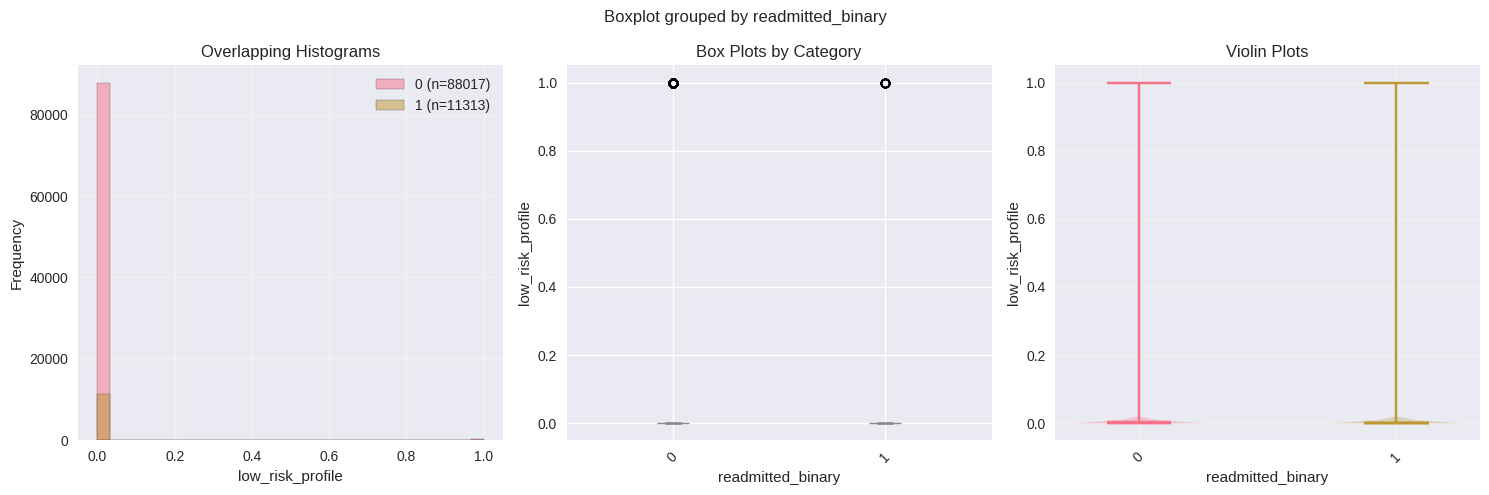


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.003727  0.060932  0.0  0.0  0.0  0.0  1.0
1                  11313.0  0.001679  0.040949  0.0  0.0  0.0  0.0  1.0

Mann-Whitney U test:
  Test Statistic: 498887331.0000
  P-value: 5.1326e-04
  Cohen's d: 0.0394
  Significant at α=0.05: Yes

Analyzing: polypharmacy_risk


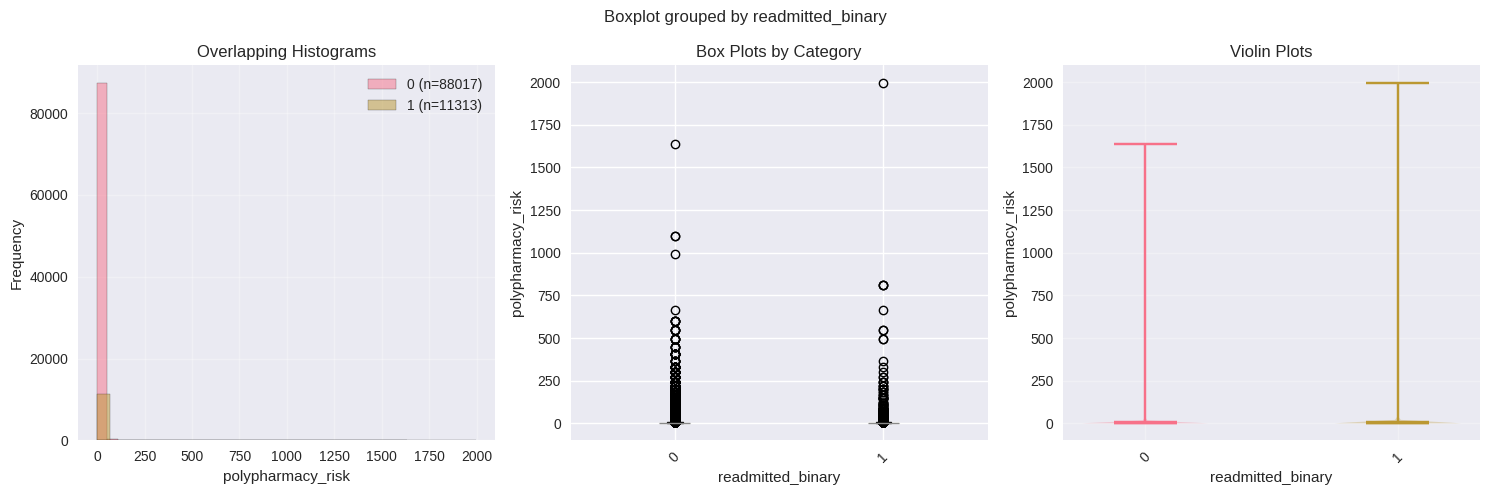


Descriptive Statistics:
                     count      mean        std  min       25%       50%  \
readmitted_binary                                                          
0                  88017.0  5.098234  17.792219  0.0  1.648721  2.718282   
1                  11313.0  5.885852  28.558810  0.0  1.822119  3.004166   

                        75%          max  
readmitted_binary                         
0                  4.481689  1635.984430  
1                  4.953032  1998.195895  

Mann-Whitney U test:
  Test Statistic: 454442135.0000
  P-value: 8.5983e-52
  Cohen's d: -0.0331
  Significant at α=0.05: Yes

Analyzing: log_num_medications


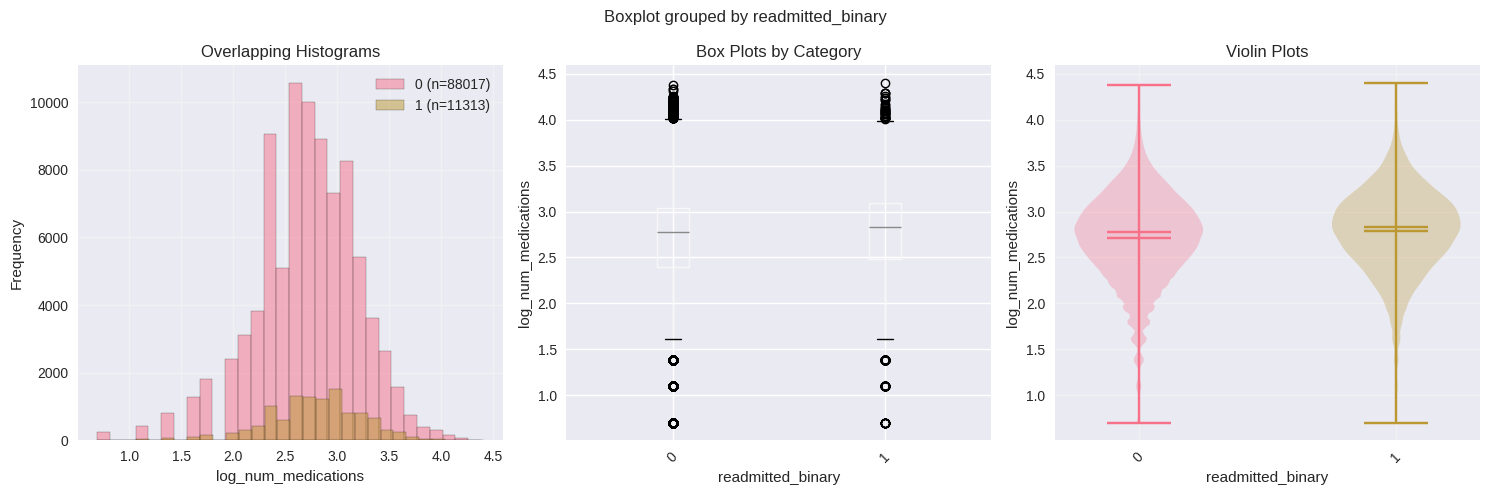


Descriptive Statistics:
                     count      mean       std       min       25%       50%  \
readmitted_binary                                                              
0                  88017.0  2.712017  0.490985  0.693147  2.397895  2.772589   
1                  11313.0  2.785177  0.460790  0.693147  2.484907  2.833213   

                        75%       max  
readmitted_binary                      
0                  3.044522  4.382027  
1                  3.091042  4.406719  

Mann-Whitney U test:
  Test Statistic: 454431734.5000
  P-value: 8.2423e-52
  Cohen's d: -0.1537
  Significant at α=0.05: Yes

Analyzing: medication_burden_score
⚠️  SKIPPING: Feature has 790 unique values (> 100)
   This feature likely represents IDs or has too many categories for meaningful analysis.

Analyzing: log_num_procedures


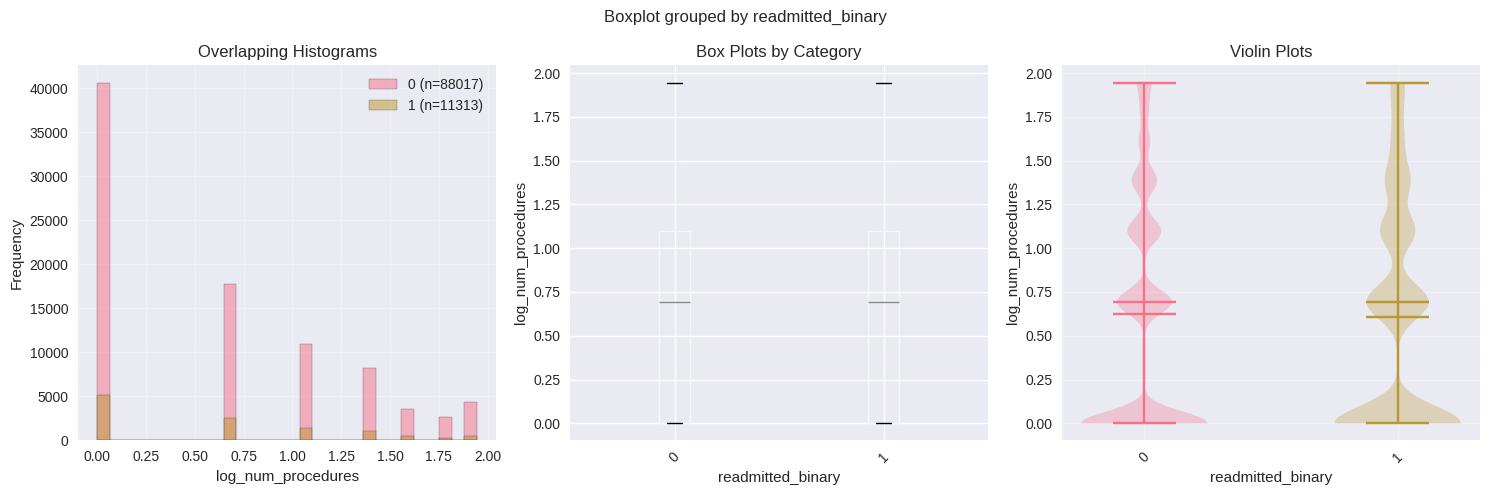


Descriptive Statistics:
                     count      mean       std  min  25%       50%       75%  \
readmitted_binary                                                              
0                  88017.0  0.621535  0.655499  0.0  0.0  0.693147  1.098612   
1                  11313.0  0.608584  0.636702  0.0  0.0  0.693147  1.098612   

                       max  
readmitted_binary           
0                  1.94591  
1                  1.94591  

Mann-Whitney U test:
  Test Statistic: 501717903.5000
  P-value: 1.5552e-01
  Cohen's d: 0.0200
  Significant at α=0.05: No

Analyzing: log_time_in_hospital


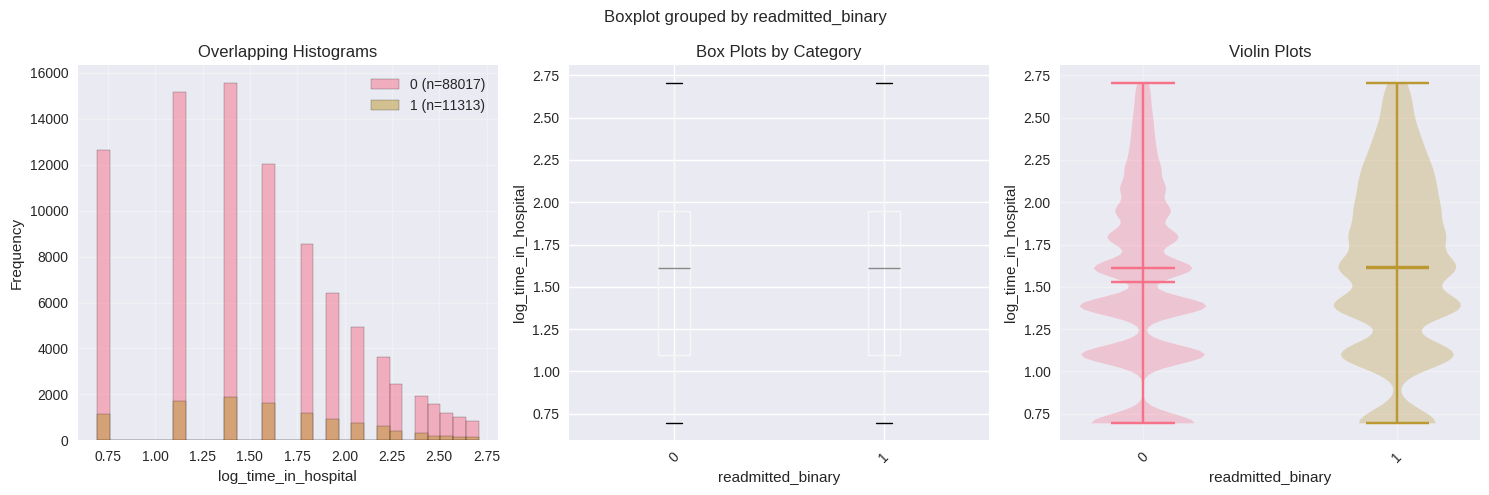


Descriptive Statistics:
                     count      mean       std       min       25%       50%  \
readmitted_binary                                                              
0                  88017.0  1.530871  0.532622  0.693147  1.098612  1.609438   
1                  11313.0  1.618523  0.522397  0.693147  1.098612  1.609438   

                       75%      max  
readmitted_binary                    
0                  1.94591  2.70805  
1                  1.94591  2.70805  

Mann-Whitney U test:
  Test Statistic: 450354610.0000
  P-value: 1.4302e-62
  Cohen's d: -0.1662
  Significant at α=0.05: Yes

Analyzing: log_total_healthcare_encounters


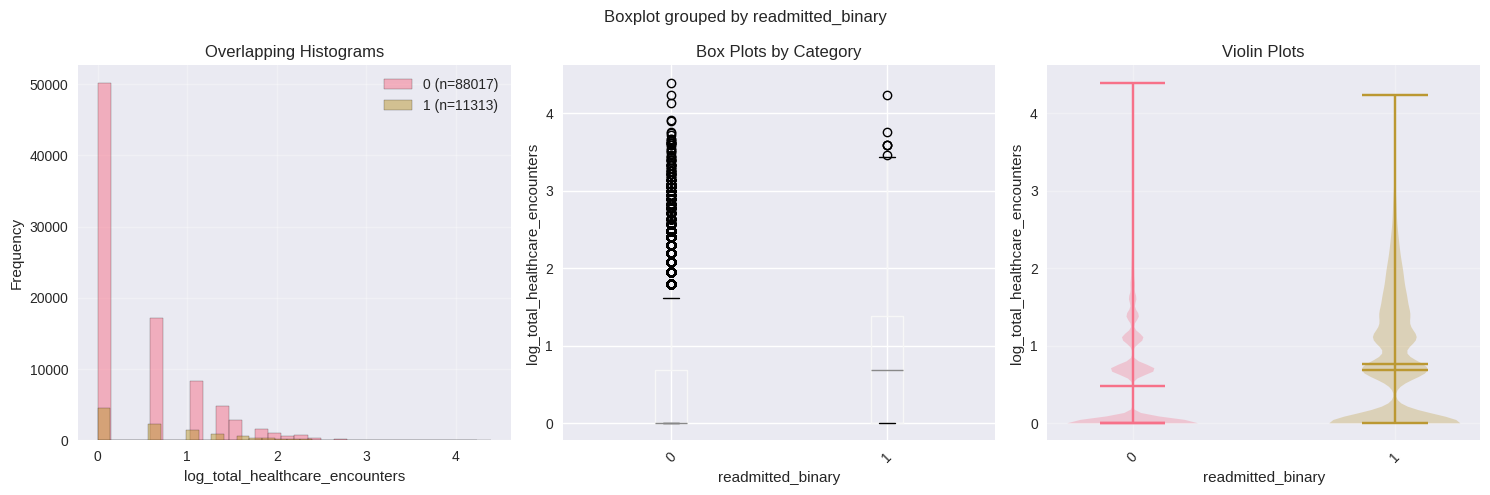


Descriptive Statistics:
                     count      mean       std  min  25%       50%       75%  \
readmitted_binary                                                              
0                  88017.0  0.480235  0.639779  0.0  0.0  0.000000  0.693147   
1                  11313.0  0.764923  0.770696  0.0  0.0  0.693147  1.386294   

                        max  
readmitted_binary            
0                  4.394449  
1                  4.234107  

Mann-Whitney U test:
  Test Statistic: 394095606.5000
  P-value: 0.0000e+00
  Cohen's d: -0.4020
  Significant at α=0.05: Yes

Analyzing: a1c_abnormal_flag


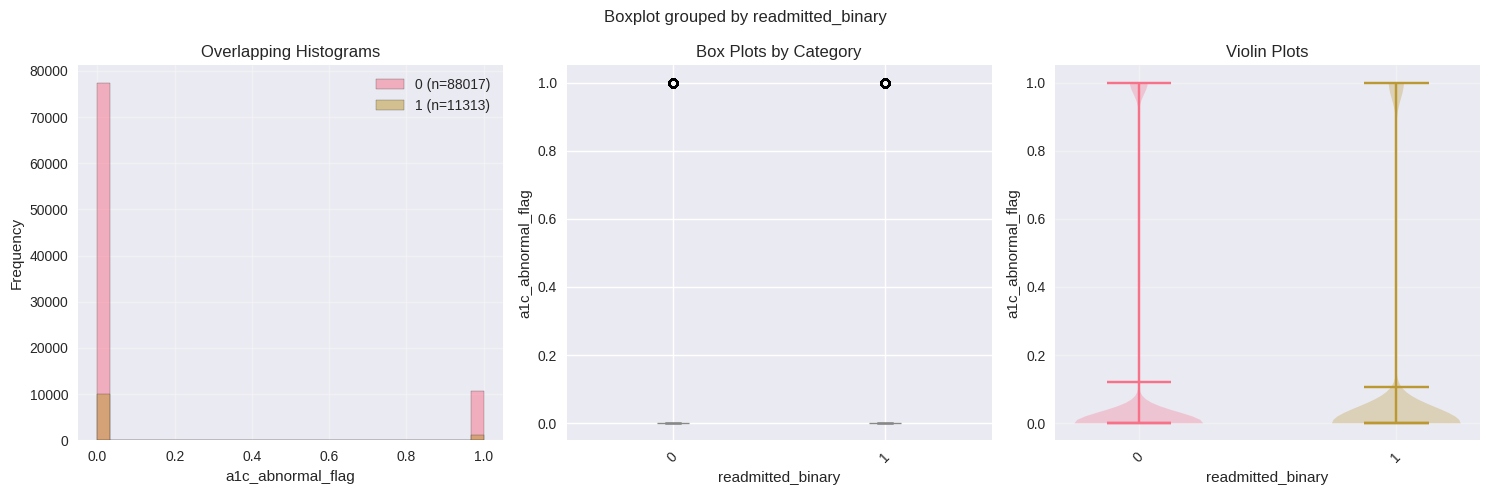


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.121772  0.327024  0.0  0.0  0.0  0.0  1.0
1                  11313.0  0.105366  0.307037  0.0  0.0  0.0  0.0  1.0

Mann-Whitney U test:
  Test Statistic: 506036395.5000
  P-value: 4.2669e-07
  Cohen's d: 0.0517
  Significant at α=0.05: Yes

Analyzing: glu_lab_flag


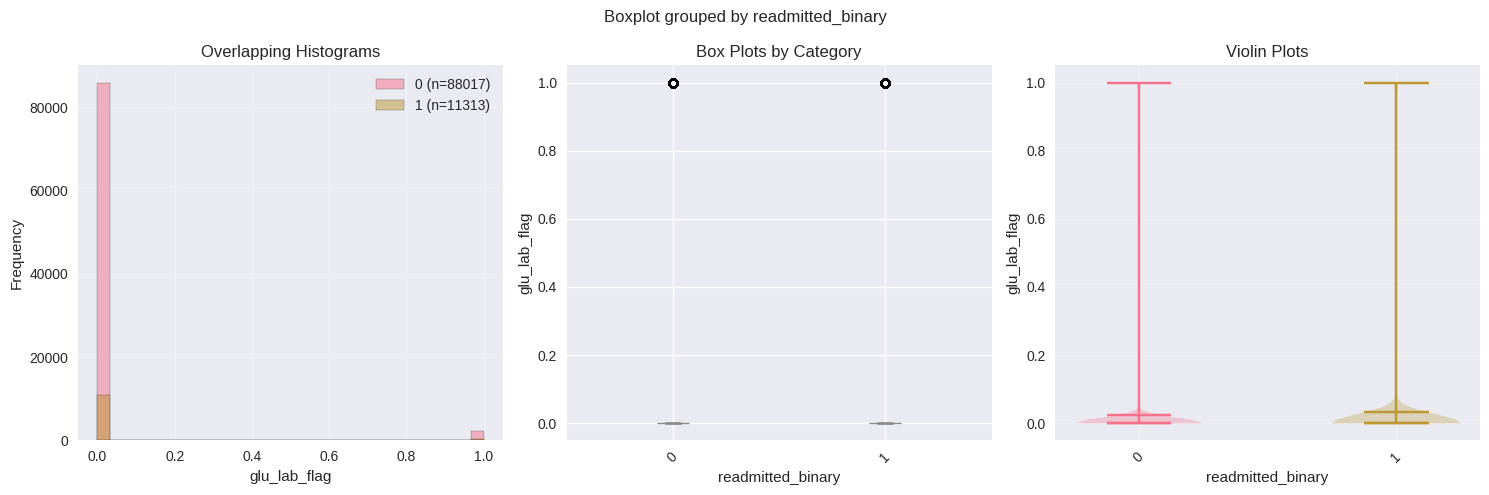


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.025495  0.157624  0.0  0.0  0.0  0.0  1.0
1                  11313.0  0.032087  0.176239  0.0  0.0  0.0  0.0  1.0

Mann-Whitney U test:
  Test Statistic: 494586261.0000
  P-value: 3.6524e-05
  Cohen's d: -0.0394
  Significant at α=0.05: Yes

Analyzing: max_glu_serum_missing


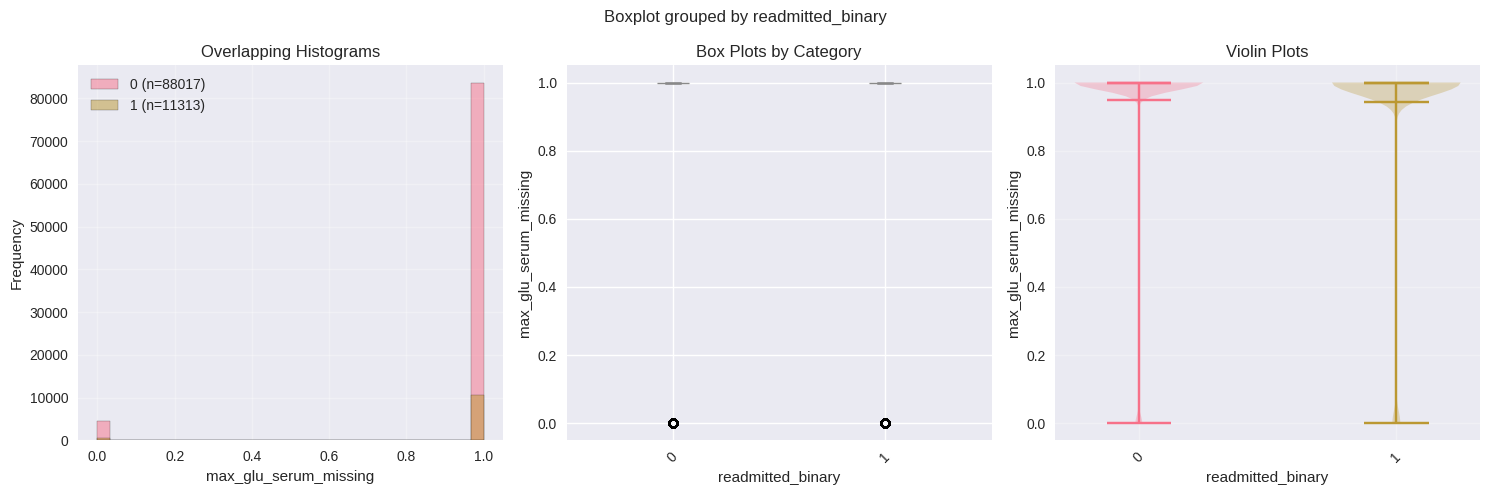


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.948930  0.220141  0.0  1.0  1.0  1.0  1.0
1                  11313.0  0.941925  0.233895  0.0  1.0  1.0  1.0  1.0

Mann-Whitney U test:
  Test Statistic: 501355777.5000
  P-value: 1.5630e-03
  Cohen's d: 0.0308
  Significant at α=0.05: Yes

Analyzing: A1Cresult_missing


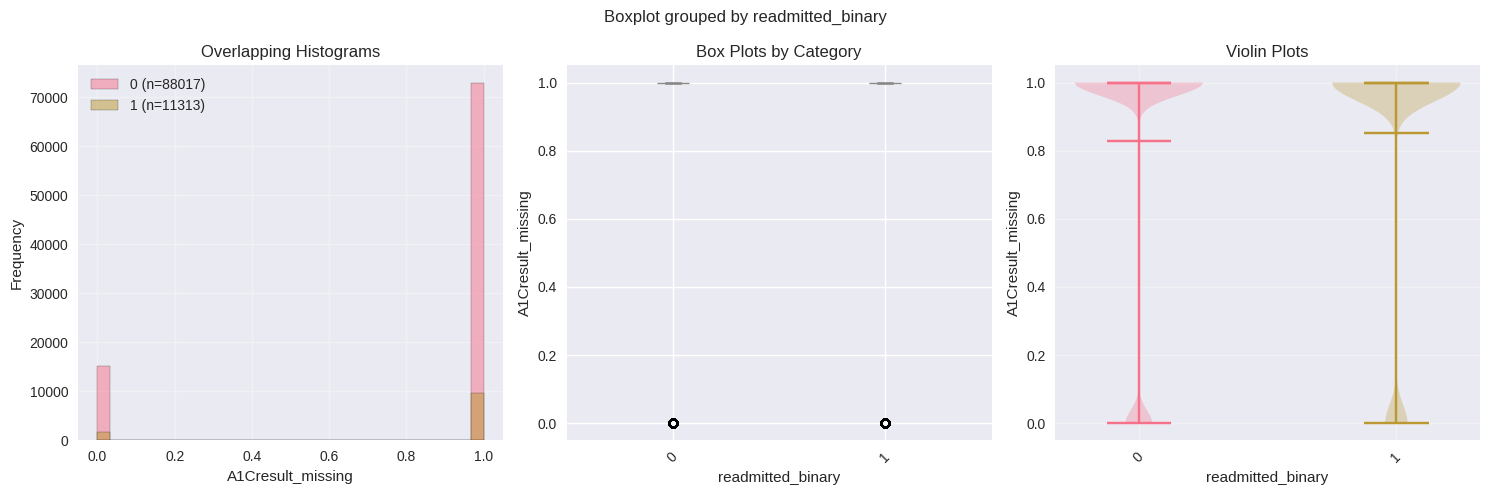


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.827772  0.377581  0.0  1.0  1.0  1.0  1.0
1                  11313.0  0.852117  0.355000  0.0  1.0  1.0  1.0  1.0

Mann-Whitney U test:
  Test Statistic: 485747497.5000
  P-value: 8.1777e-11
  Cohen's d: -0.0664
  Significant at α=0.05: Yes

Analyzing: time_in_hospital_bin


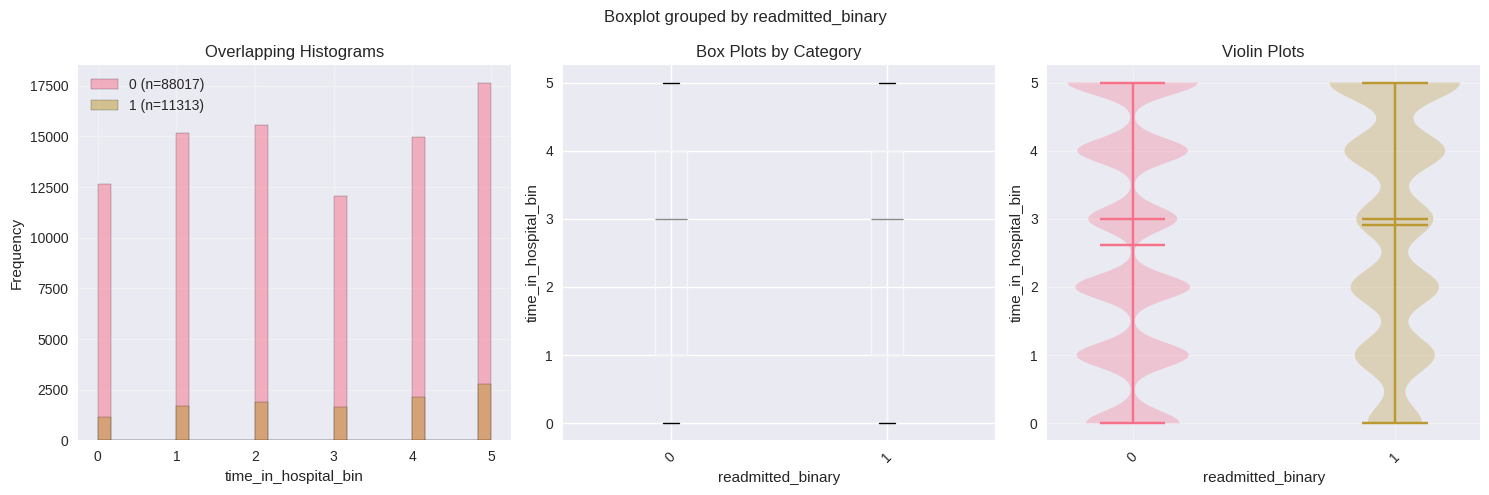


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  2.617188  1.727931  0.0  1.0  3.0  4.0  5.0
1                  11313.0  2.906391  1.690148  0.0  1.0  3.0  4.0  5.0

Mann-Whitney U test:
  Test Statistic: 450472589.0000
  P-value: 5.0425e-63
  Cohen's d: -0.1692
  Significant at α=0.05: Yes

Analyzing: num_medications_bin


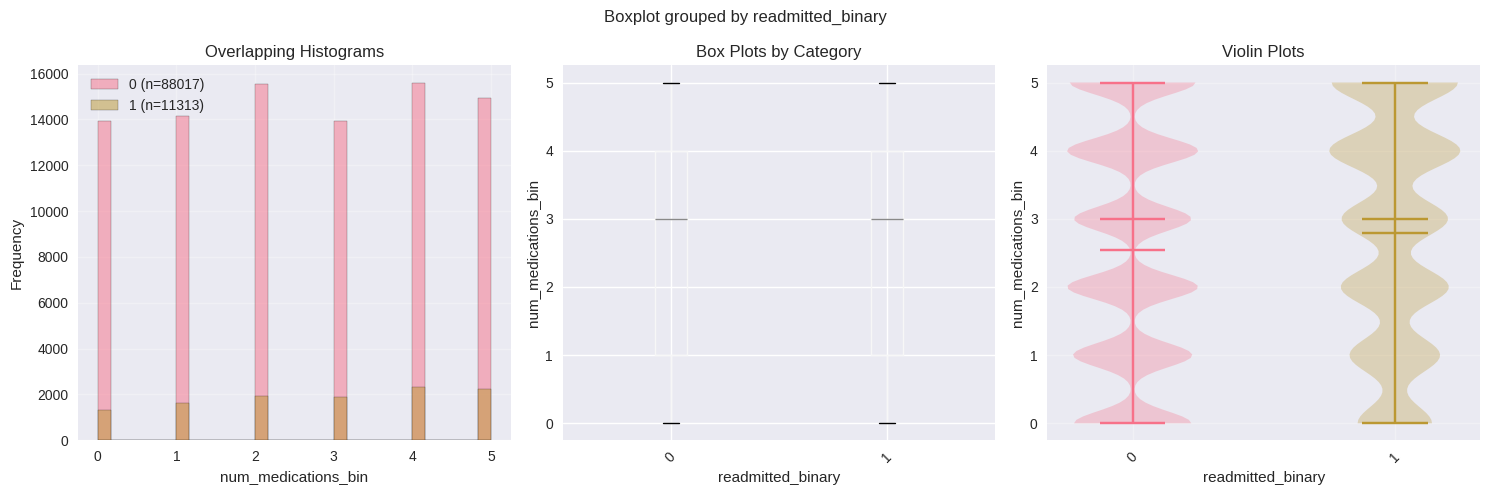


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  2.543372  1.699594  0.0  1.0  3.0  4.0  5.0
1                  11313.0  2.797490  1.657754  0.0  1.0  3.0  4.0  5.0

Mann-Whitney U test:
  Test Statistic: 455586324.5000
  P-value: 1.8445e-50
  Cohen's d: -0.1514
  Significant at α=0.05: Yes

Analyzing: num_lab_procedures_bin


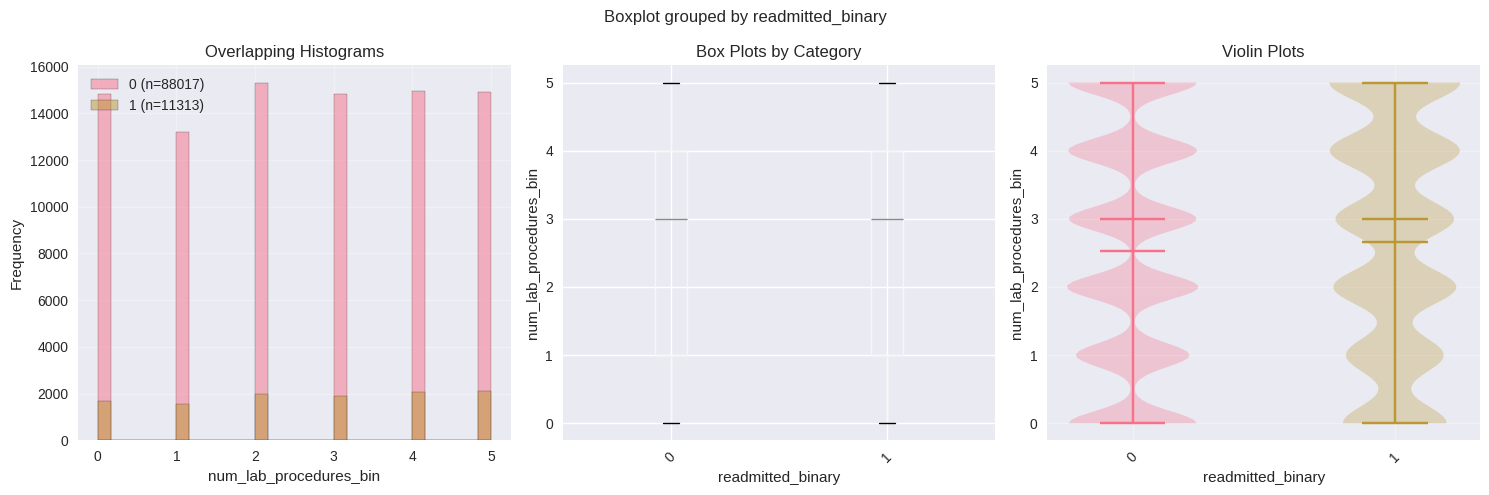


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  2.530602  1.707288  0.0  1.0  3.0  4.0  5.0
1                  11313.0  2.661540  1.694566  0.0  1.0  3.0  4.0  5.0

Mann-Whitney U test:
  Test Statistic: 476175936.0000
  P-value: 1.8052e-14
  Cohen's d: -0.0770
  Significant at α=0.05: Yes

Analyzing: number_diagnoses_bin


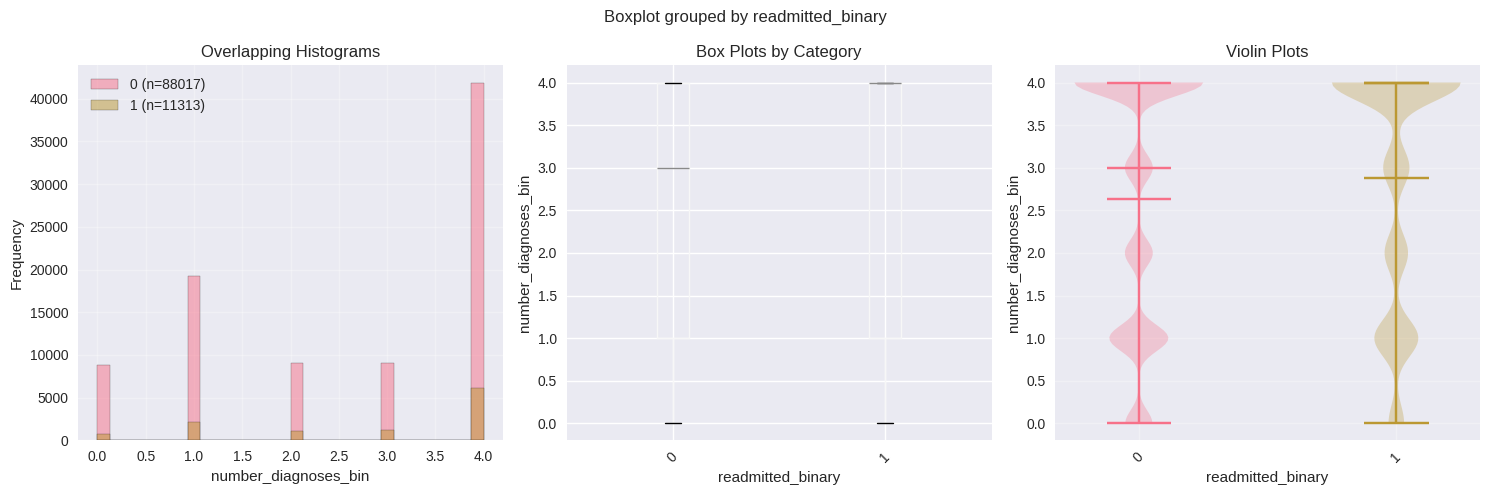


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  2.634786  1.489622  0.0  1.0  3.0  4.0  4.0
1                  11313.0  2.875983  1.397456  0.0  1.0  4.0  4.0  4.0

Mann-Whitney U test:
  Test Statistic: 455051877.5000
  P-value: 3.0811e-57
  Cohen's d: -0.1670
  Significant at α=0.05: Yes

Analyzing: num_procedures_bin


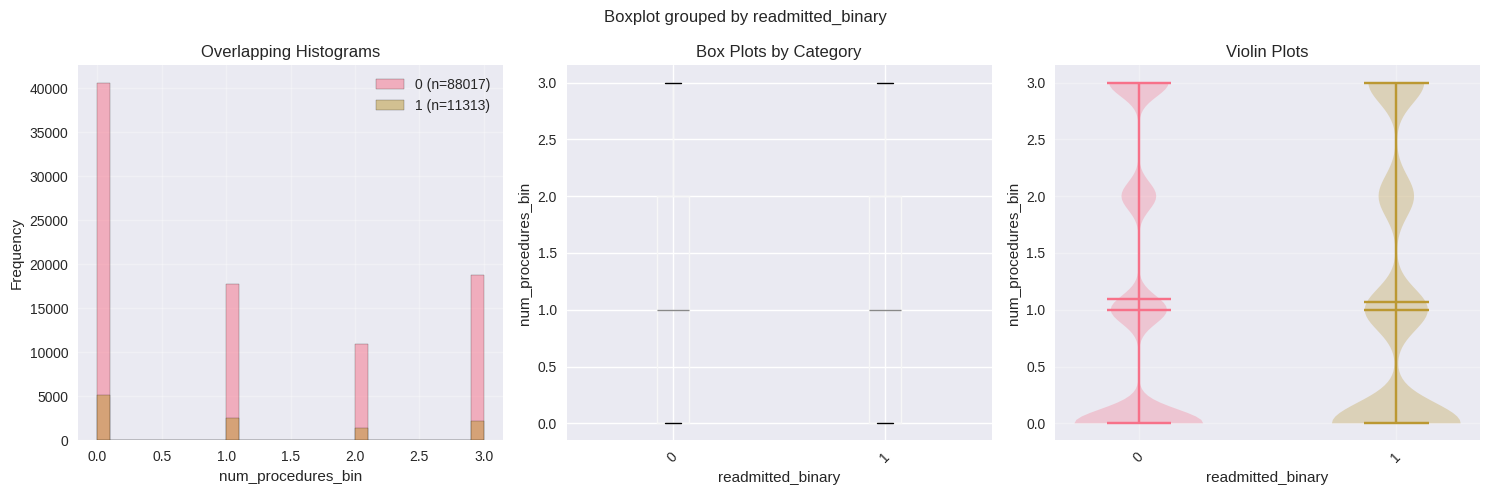


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  1.091266  1.196372  0.0  0.0  1.0  2.0  3.0
1                  11313.0  1.065411  1.168208  0.0  0.0  1.0  2.0  3.0

Mann-Whitney U test:
  Test Statistic: 501145133.5000
  P-value: 2.2445e-01
  Cohen's d: 0.0219
  Significant at α=0.05: No

Analyzing: clinical_complexity_score_bin


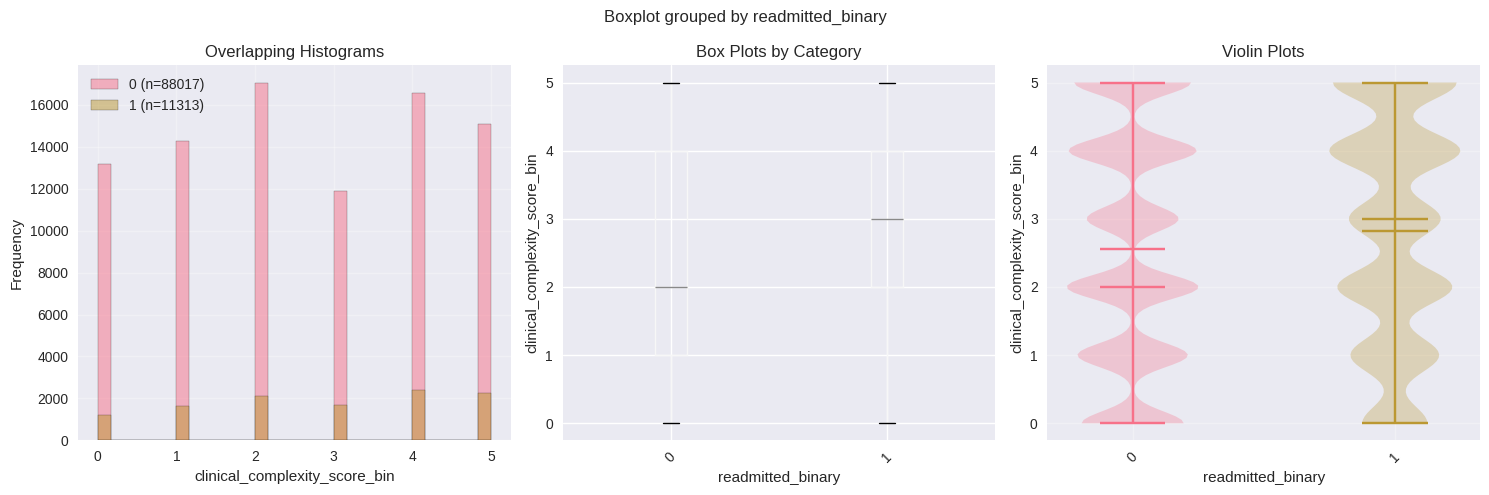


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  2.563652  1.694985  0.0  1.0  2.0  4.0  5.0
1                  11313.0  2.822063  1.643502  0.0  2.0  3.0  4.0  5.0

Mann-Whitney U test:
  Test Statistic: 454811883.0000
  P-value: 2.5758e-52
  Cohen's d: -0.1548
  Significant at α=0.05: Yes

Analyzing: total_healthcare_encounters_bin


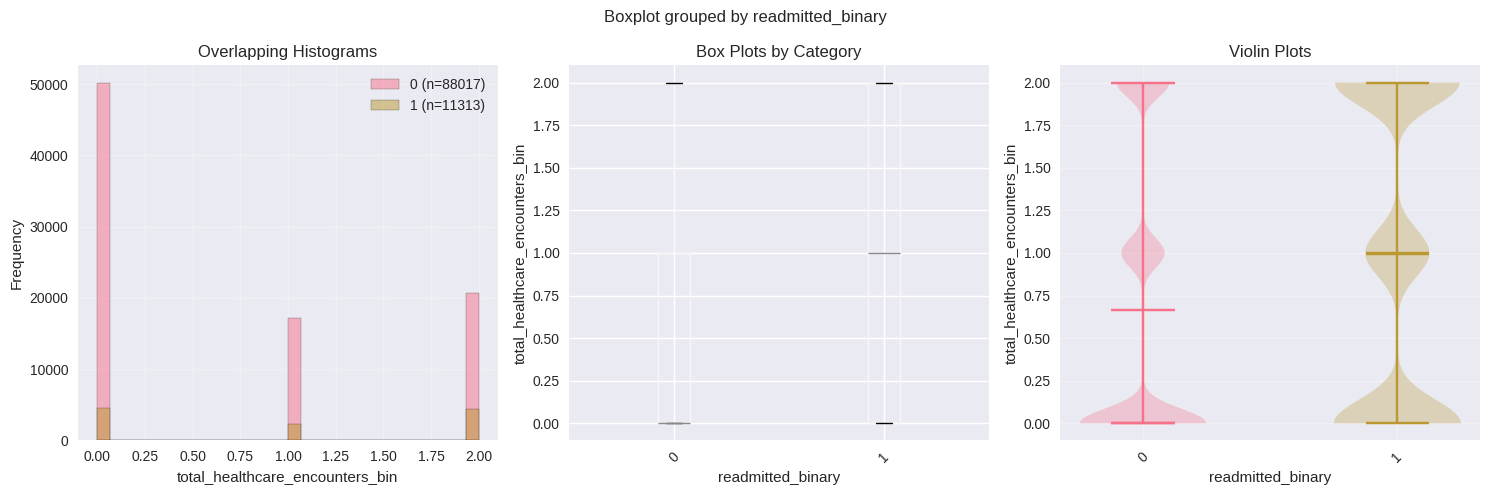


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.666349  0.832941  0.0  0.0  0.0  1.0  2.0
1                  11313.0  0.992398  0.892634  0.0  0.0  1.0  2.0  2.0

Mann-Whitney U test:
  Test Statistic: 400193436.0000
  P-value: 0.0000e+00
  Cohen's d: -0.3777
  Significant at α=0.05: Yes

Analyzing: diabetes_diagnosis_count


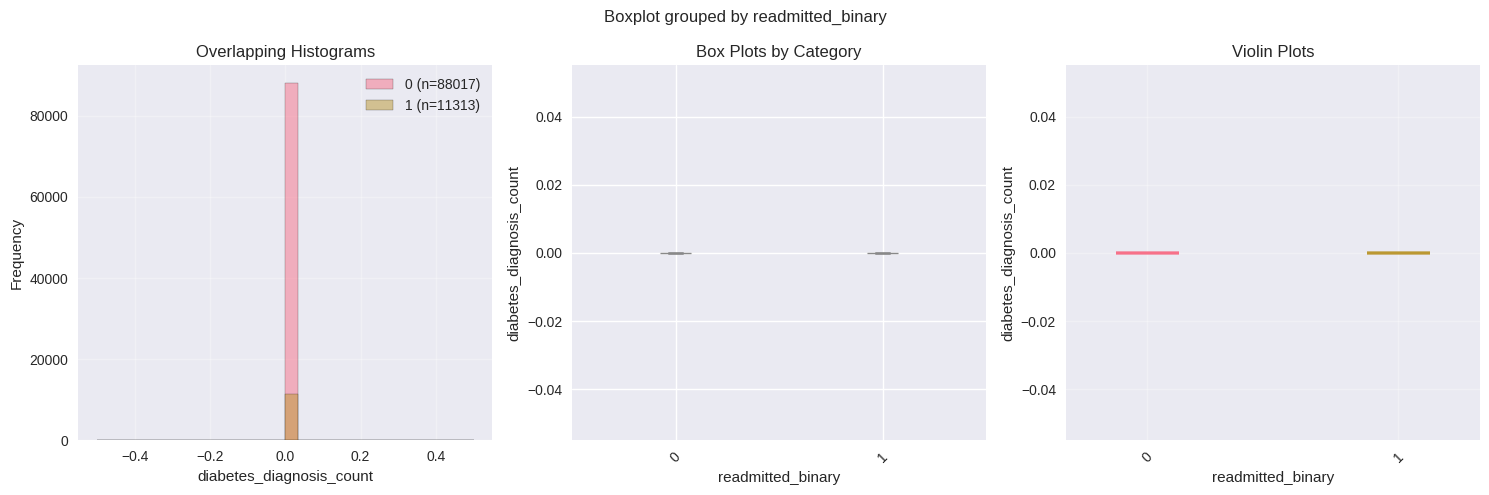


Descriptive Statistics:
                     count  mean  std  min  25%  50%  75%  max
readmitted_binary                                             
0                  88017.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1                  11313.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

Independent t-test:
  Test Statistic: nan
  P-value: nan
  Cohen's d: 0.0000
  Significant at α=0.05: No

Analyzing: primary_diabetes


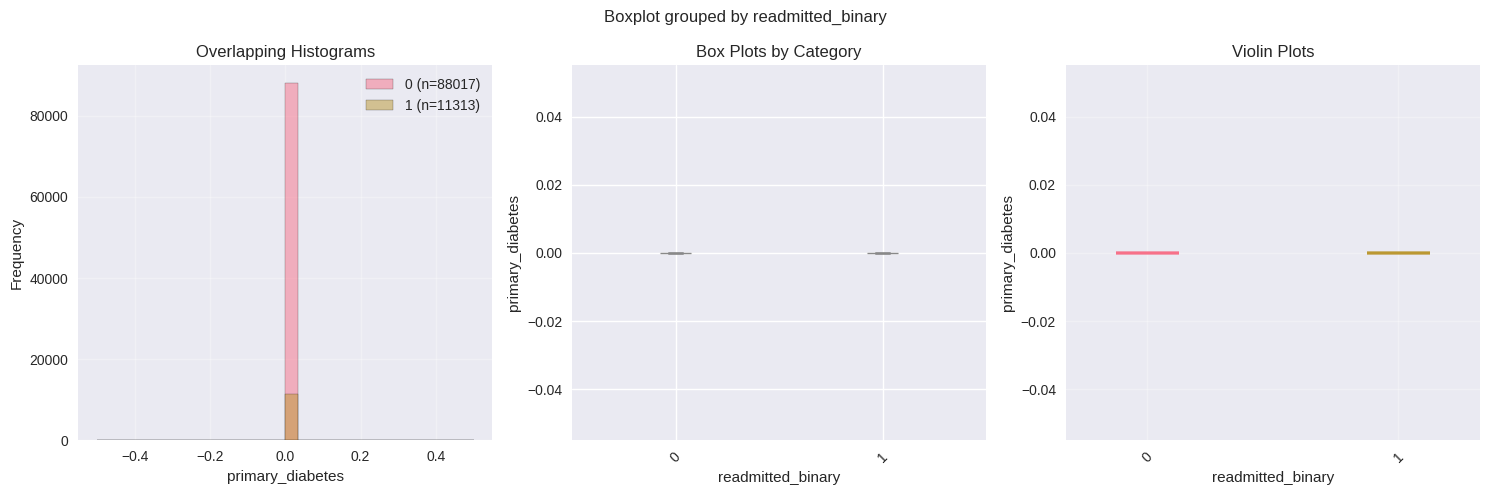


Descriptive Statistics:
                     count  mean  std  min  25%  50%  75%  max
readmitted_binary                                             
0                  88017.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1                  11313.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

Independent t-test:
  Test Statistic: nan
  P-value: nan
  Cohen's d: 0.0000
  Significant at α=0.05: No

Analyzing: has_circulatory_complication


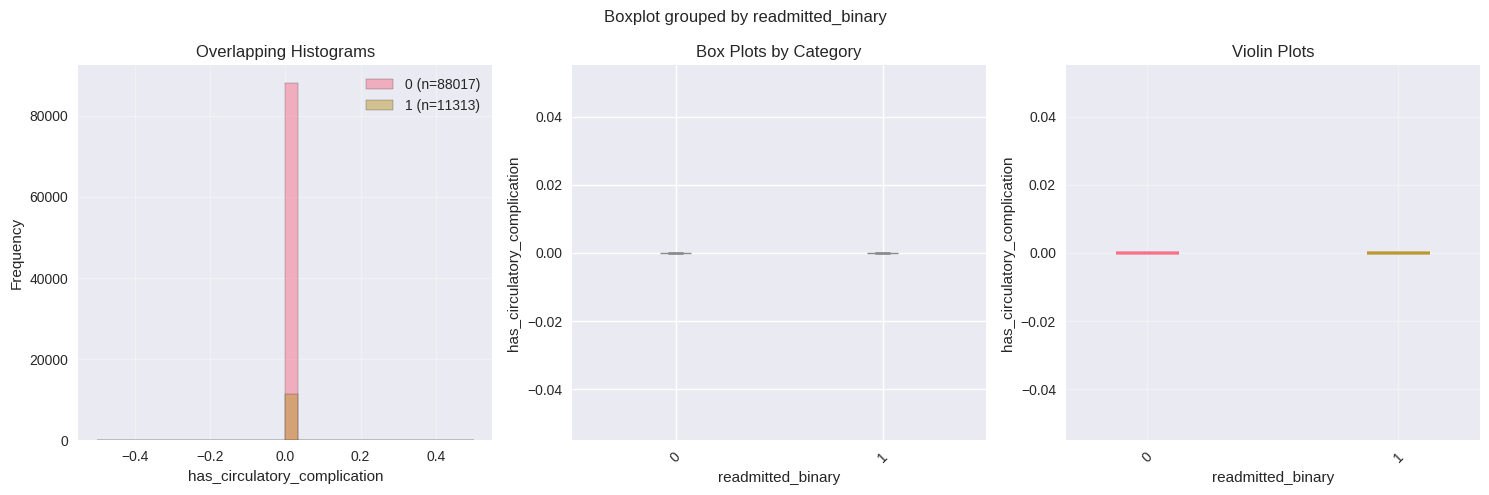


Descriptive Statistics:
                     count  mean  std  min  25%  50%  75%  max
readmitted_binary                                             
0                  88017.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1                  11313.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

Independent t-test:
  Test Statistic: nan
  P-value: nan
  Cohen's d: 0.0000
  Significant at α=0.05: No

Analyzing: circulatory_issue_flag


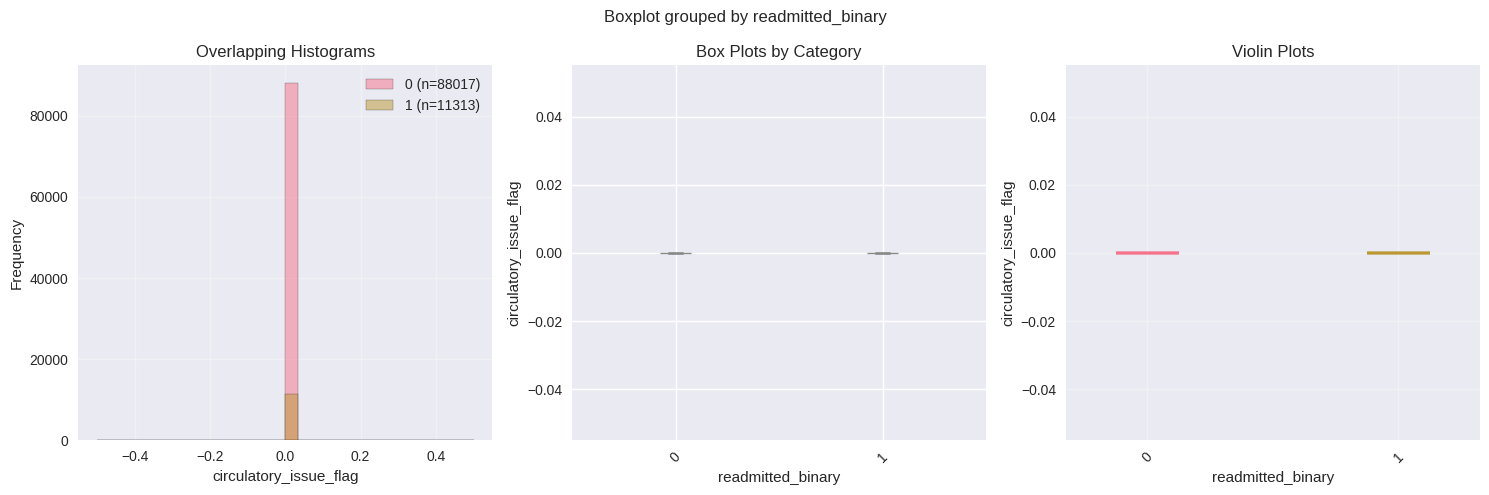


Descriptive Statistics:
                     count  mean  std  min  25%  50%  75%  max
readmitted_binary                                             
0                  88017.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1                  11313.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

Independent t-test:
  Test Statistic: nan
  P-value: nan
  Cohen's d: 0.0000
  Significant at α=0.05: No

Analyzing: diagnosis_diversity


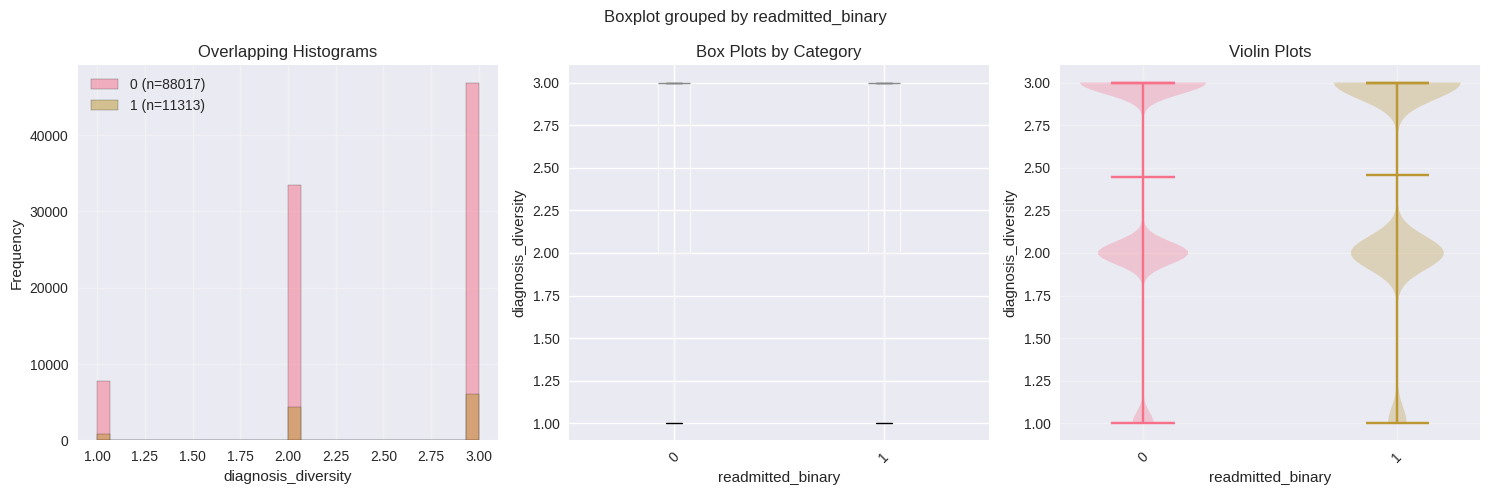


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  2.442676  0.651504  1.0  2.0  3.0  3.0  3.0
1                  11313.0  2.455228  0.634603  1.0  2.0  3.0  3.0  3.0

Mann-Whitney U test:
  Test Statistic: 494713932.5000
  P-value: 2.1753e-01
  Cohen's d: -0.0195
  Significant at α=0.05: No

Analyzing: diag_123
⚠️  SKIPPING: Feature has 56840 unique values (> 100)
   This feature likely represents IDs or has too many categories for meaningful analysis.

Analyzing: diag_123_group
⚠️  SKIPPING: Feature has 3382 unique values (> 100)
   This feature likely represents IDs or has too many categories for meaningful analysis.

Analyzing: diag_123_group_time_in_hospital_bin
⚠️  SKIPPING: Feature has 12638 unique values (> 100)
   This feature likely represents IDs or has too many categories for meaningful analysis.

Analyzing: diag_123_group_num_med

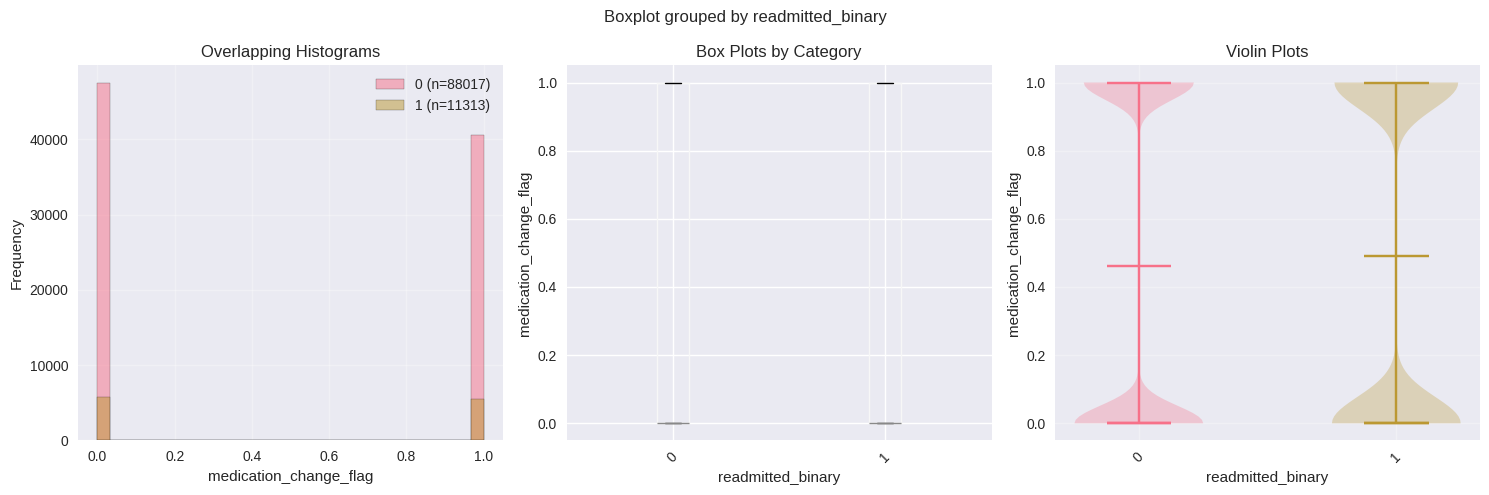


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.460956  0.498476  0.0  0.0  0.0  1.0  1.0
1                  11313.0  0.490144  0.499925  0.0  0.0  0.0  1.0  1.0

Mann-Whitney U test:
  Test Statistic: 483336546.0000
  P-value: 4.6390e-09
  Cohen's d: -0.0585
  Significant at α=0.05: Yes

Analyzing: has_diabetes_med_flag


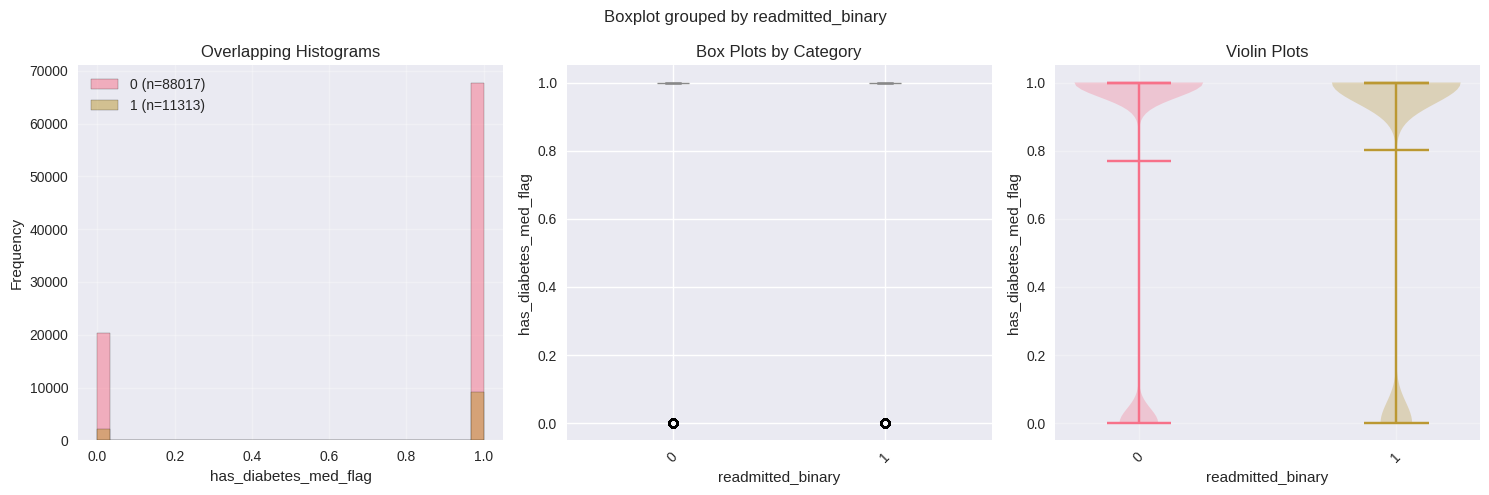


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.768363  0.421881  0.0  1.0  1.0  1.0  1.0
1                  11313.0  0.802616  0.398042  0.0  1.0  1.0  1.0  1.0

Mann-Whitney U test:
  Test Statistic: 480814419.0000
  P-value: 2.8907e-16
  Cohen's d: -0.0835
  Significant at α=0.05: Yes

Analyzing: long_stay_flag


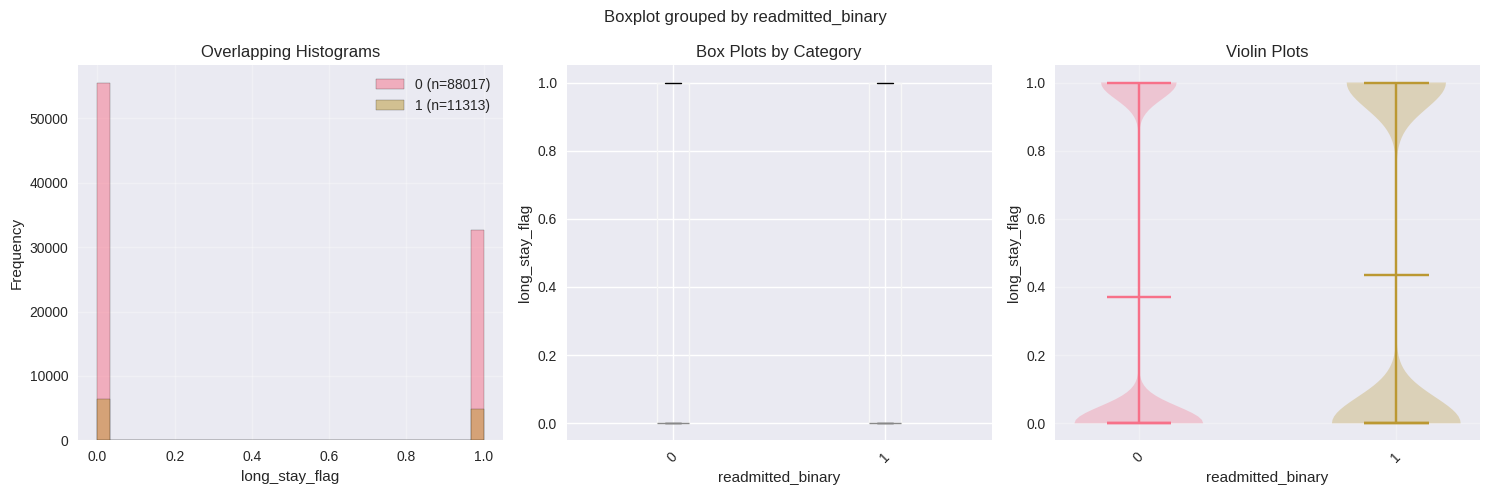


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.370190  0.482858  0.0  0.0  0.0  1.0  1.0
1                  11313.0  0.435428  0.495835  0.0  0.0  0.0  1.0  1.0

Mann-Whitney U test:
  Test Statistic: 465388029.0000
  P-value: 2.2423e-41
  Cohen's d: -0.1333
  Significant at α=0.05: Yes

Analyzing: aggregated_positive_risk_score
⚠️  SKIPPING: Feature has 288 unique values (> 100)
   This feature likely represents IDs or has too many categories for meaningful analysis.

Analyzing: high_risk_signature


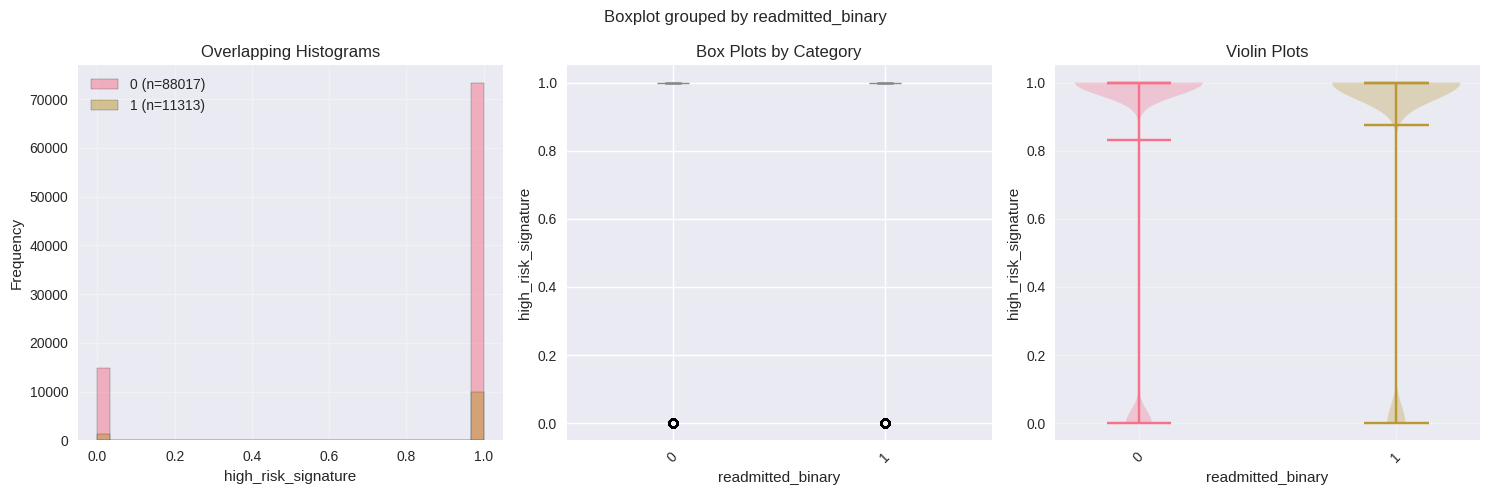


Descriptive Statistics:
                     count      mean       std  min  25%  50%  75%  max
readmitted_binary                                                      
0                  88017.0  0.832078  0.373799  0.0  1.0  1.0  1.0  1.0
1                  11313.0  0.876691  0.328807  0.0  1.0  1.0  1.0  1.0

Mann-Whitney U test:
  Test Statistic: 475656948.0000
  P-value: 1.0865e-33
  Cohen's d: -0.1267
  Significant at α=0.05: Yes

SKIPPED FEATURES:
  • encounter_id: 99330 unique values (> 100)
  • patient_nbr: 69979 unique values (> 100)
  • num_lab_procedures: 118 unique values (> 100)
  • diag_1: 715 unique values (> 100)
  • diag_2: 748 unique values (> 100)
  • diag_3: 787 unique values (> 100)
  • emergency_ratio: 159 unique values (> 100)
  • inpatient_ratio: 160 unique values (> 100)
  • outpatient_ratio: 145 unique values (> 100)
  • medication_intensity: 525 unique values (> 100)
  • lab_intensity: 874 unique values (> 100)
  • medication_per_diagnosis: 353 unique values

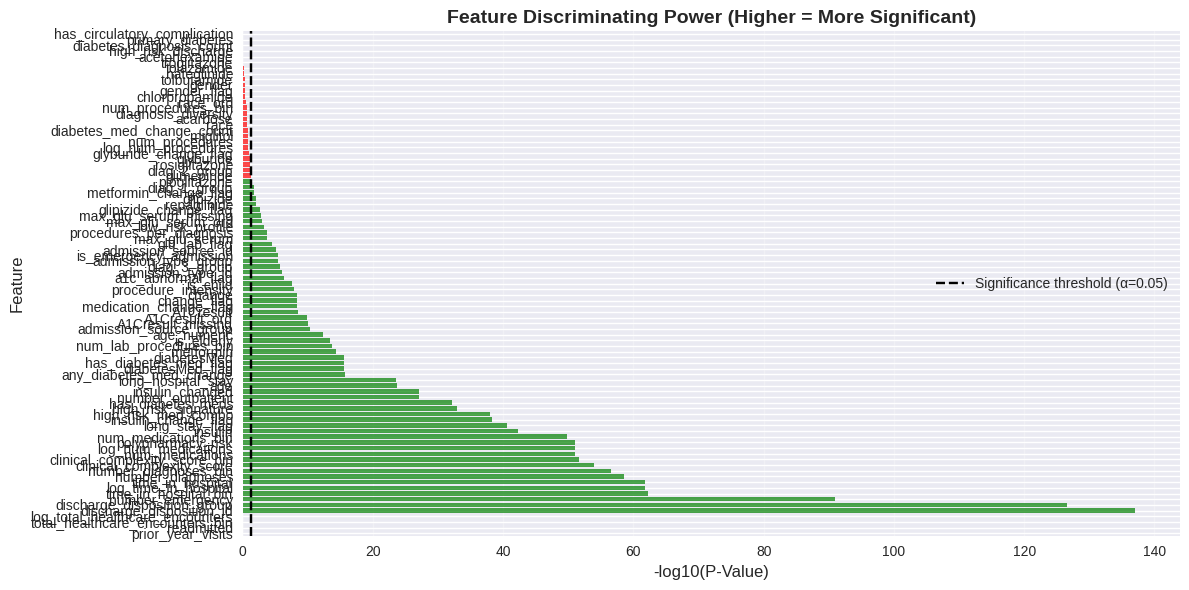


TOP 5 MOST DISTINGUISHING FEATURES:
                        Feature        Type  N_Unique                Test  Test_Statistic  P_Value  Effect_Size Effect_Measure  Significant  Rank_Score
               number_inpatient     Numeric        21 Mann-Whitney U test     391048778.5      0.0    -0.419284      Cohen's d         True         inf
    total_healthcare_encounters     Numeric        47 Mann-Whitney U test     394095606.5      0.0    -0.342448      Cohen's d         True         inf
              prior_year_visits     Numeric        47 Mann-Whitney U test     394095606.5      0.0    -0.342448      Cohen's d         True         inf
                     readmitted Categorical         3     Chi-square test         99330.0      0.0     1.000000     Cramér's V         True         inf
total_healthcare_encounters_bin     Numeric         3 Mann-Whitney U test     400193436.0      0.0    -0.377687      Cohen's d         True         inf


In [28]:
df_features = create_advanced_features(df)
target_column = 'readmitted_binary'
# Run analysis
results = analyze_feature_distributions(df_features, target_column=target_column, alpha=0.05, max_categories=100)

# Display top distinguishing features
print("\n" + "="*80)
print("TOP 5 MOST DISTINGUISHING FEATURES:")
print("="*80)
print(results.head().to_string(index=False))

In [29]:
# Display top distinguishing features
top_n = 50
print("\n" + "="*80)
print(f"TOP {top_n} MOST DISTINGUISHING FEATURES:")
print("="*80)
top_value_list = results['Feature'].head(top_n).tolist()
top_value_list = [f for f in top_value_list if f not in ['readmitted', 'readmitted_binary']]
print(top_value_list)


TOP 50 MOST DISTINGUISHING FEATURES:
['number_inpatient', 'total_healthcare_encounters', 'prior_year_visits', 'total_healthcare_encounters_bin', 'log_total_healthcare_encounters', 'discharge_disposition_id', 'discharge_disposition_group', 'number_emergency', 'time_in_hospital_bin', 'log_time_in_hospital', 'time_in_hospital', 'number_diagnoses', 'number_diagnoses_bin', 'clinical_complexity_score', 'clinical_complexity_score_bin', 'num_medications', 'log_num_medications', 'polypharmacy_risk', 'num_medications_bin', 'insulin', 'long_stay_flag', 'insulin_change_flag', 'high_risk_med_combo', 'high_risk_signature', 'has_diabetes_meds', 'number_outpatient', 'insulin_changed', 'age', 'long_hospital_stay', 'any_diabetes_med_change', 'diabetesMed_flag', 'has_diabetes_med_flag', 'diabetesMed', 'metformin', 'num_lab_procedures_bin', 'is_elderly', 'age_numeric', 'admission_source_group', 'A1Cresult_missing', 'A1Cresult_ord', 'A1Cresult', 'medication_change_flag', 'change_flag', 'change', 'procedur

In [23]:
top_value_list = ['number_inpatient', 'total_healthcare_encounters', 'prior_year_visits', 'total_healthcare_encounters_bin', 'log_total_healthcare_encounters', 'discharge_disposition_id', 'discharge_disposition_group', 'number_emergency', 'time_in_hospital_bin', 'log_time_in_hospital', 'time_in_hospital', 'number_diagnoses', 'number_diagnoses_bin', 'clinical_complexity_score', 'clinical_complexity_score_bin', 'num_medications', 'log_num_medications', 'polypharmacy_risk', 'num_medications_bin', 'insulin', 'long_stay_flag', 'insulin_change_flag', 'high_risk_med_combo', 'high_risk_signature', 'has_diabetes_meds', 'number_outpatient', 'insulin_changed', 'age', 'long_hospital_stay', 'any_diabetes_med_change', 'diabetesMed_flag', 'has_diabetes_med_flag', 'diabetesMed', 'metformin', 'num_lab_procedures_bin', 'is_elderly', 'age_numeric', 'admission_source_group', 'A1Cresult_missing', 'A1Cresult_ord', 'A1Cresult', 'medication_change_flag', 'change_flag', 'change', 'procedure_intensity', 'is_child', 'a1c_abnormal_flag', 'admission_type_id', 'diag_3_group']

# 1. Patient-centric models: single encounter patients & returning patients

In [ ]:
# Split dataset by patient encounter counts (single vs returning)
patient_counts = df.groupby('patient_nbr').size()
single_patient_ids = patient_counts[patient_counts == 1].index
multi_patient_ids = patient_counts[patient_counts > 1].index

group_datasets = {
    'Single-encounter patients': df[df['patient_nbr'].isin(single_patient_ids)].copy(),
    'Returning patients': df[df['patient_nbr'].isin(multi_patient_ids)].copy()
}

for group_name, group_df in group_datasets.items():
    print(f"\n{group_name}: {len(group_df):,} encounters from {group_df['patient_nbr'].nunique():,} patients")
    if group_df.empty:
        print("⚠️  Skipping empty group.")

group_results = {}
for group_name, group_df in group_datasets.items():
    if group_df.empty:
        continue
    group_results[group_name] = run_group_modeling_pipeline(
        group_df,
        group_name=group_name,
        target_col='readmitted_binary',
        test_size=0.2,
        random_state=42,
        patient_level=True,
        min_top_k=30,
        keep_feature_list=top_value_list
    )

group_summaries = {name: payload['summary'] for name, payload in group_results.items()}
group_summaries


Single-encounter patients: 53,640 encounters from 53,640 patients

Returning patients: 45,690 encounters from 16,339 patients
======================================== SINGLE-ENCOUNTER PATIENTS GROUP PIPELINE ========================================

Before any processing:
  Total rows: 53640
  Readmission rate: 0.043
Creating patient history features (avoiding temporal leakage)...
✓ Created 30 patient history features without data leakage
  - All features use only PRIOR encounters (via .shift(1))
  - First encounter for each patient has 0/NaN values (no prior history)
  - Uses readmitted_binary (30-day readmission) as target-aligned feature
  - Added 9 NEW advanced features for improved F1 score
  - Sample new features: has_diabetes_meds, healthcare_utilization_trend, high_confidence_readmission, high_risk_med_combo, high_risk_profile, historic_unique_diag_groups, is_returning_patient, log_num_procedures, log_prior_encounter_count, medication_count_change

=== Leakage Check ===
First 

In [ ]:
for group, payload in group_results.items():
    results = payload["results"]
    y_test = payload["y_test"]
    X_train_final = payload["X_train_final"]
    X_test_final = payload["X_test_final"]
    selected_features = payload["selected_features"]
    best_model_name = payload["best_model_name"]
    best_model_payload = payload["best_model_payload"]
    run_display_summary(results, group_name, y_test, X_train_final, X_test_final, selected_features, best_model_name, best_model_payload)

In [ ]:
selector = group_results['Single-encounter patients']['feature_selector']
len(selector.selected_features_), selector.selected_features_[:5]

In [ ]:
best_model_summary = []
for group, payload in group_results.items():
    best_name = payload['best_model_name']
    best_metrics = payload['results'][best_name]['test']
    best_model_summary.append({
        'group': group,
        'best_model': best_name,
        'precision': best_metrics['precision'],
        'recall': best_metrics['recall'],
        'f1': best_metrics['f1'],
        'roc_auc': best_metrics['roc_auc'],
        'avg_precision': best_metrics['average_precision'],
        'accuracy': best_metrics['accuracy'],
        'balanced_accuracy': best_metrics['balanced_accuracy'],
        'specificity': best_metrics['specificity']
    })
pd.DataFrame(best_model_summary)

In [ ]:
# Performance analysis breakdown by selected features
for group, payload in group_results.items():
    X_test_final = payload['X_test_final']
    y_test = payload['y_test']
    best_estimator = payload['best_model_payload']['estimator']
    test_metadata = df.loc[X_test_final.index, ['race', 'age', 'diag_1_group', 'diag_2_group', 'diag_3_group']]
    print(f'==={group} CONFUSION MATRIX ANALYSIS BY FEATURE===')
    for feature in test_metadata.columns:
        print(f"\nConfusion breakdown by {feature}:")
        display(confusion_breakdown(best_estimator, X_test_final, y_test, test_metadata, feature))

In [ ]:
# Threshold Calibration
for group, payload in group_results.items():
    best_model = payload['best_model_payload']['estimator']
    best_model_name = payload['best_model_name']
    X_test_final = payload['X_test_final']
    y_test = payload['y_test']
    display_optimal_thresholds(best_model, best_model_name, X_test_final, y_test, group)


# 2. patient-centric: all patients

In [ ]:
# Run the pipeline for this group
group_name = "Patient centric_All Patients"
pipeline_results = run_group_modeling_pipeline(
    df,
    group_name,
    target_col='readmitted_binary',
    test_size=0.2,
    random_state=42,
    min_top_k=30,
    keep_feature_list=top_value_list
)

group_results[group_name] = pipeline_results
group_summaries[group_name] = pipeline_results['summary']

print(f"\nAll DF pipeline completed successfully!")

# Print key results
best_model_name = pipeline_results['best_model_name']
best_estimator = pipeline_results['best_model_payload']['estimator']
best_f1 = pipeline_results['best_model_payload']['test']['f1']
print(f"   Best model: {best_model}")
print(f"   Best F1 score: {best_f1:.4f}")




In [ ]:
results = pipeline_results["results"]
y_test = pipeline_results["y_test"]
X_train_final = pipeline_results["X_train_final"]
X_test_final = pipeline_results["X_test_final"]
selected_features = pipeline_results["selected_features"]
best_model_name = pipeline_results["best_model_name"]
best_model_payload = pipeline_results["best_model_payload"]
shap_results = run_display_summary(results, group_name, y_test, X_train_final, X_test_final, selected_features, best_model_name, best_model_payload)

In [ ]:
if 'error' not in shap_results['shap']:
    shap_type = shap_results['shap'].get('explainer_type', 'Unknown')
    print(f"   SHAP analysis: Success ({shap_type})")
else:
    print(f"   SHAP analysis: {shap_results['shap']['error']}")

In [ ]:
# Performance analysis breakdown by selected features
best_model_name = pipeline_results['best_model_name']
best_estimator = pipeline_results['best_model_payload']['estimator']
X_test_final = pipeline_results['X_test_final']
y_test = pipeline_results['y_test']
test_metadata = df.loc[X_test_final.index, ['race', 'age', 'diag_1_group', 'diag_2_group', 'diag_3_group']]
print(f'===Patient Centric All Patients CONFUSION MATRIX ANALYSIS BY FEATURE===')
for feature in test_metadata.columns:
    print(f"\nConfusion breakdown by {feature}:")
    display(confusion_breakdown(best_estimator, X_test_final, y_test, test_metadata, feature))


In [ ]:
# Threshold Calibration
display_optimal_thresholds(best_estimator, best_model_name, X_test_final, y_test, group_name)

# 3. Encounter-centric: all patients

In [ ]:
# Run the pipeline for this group

group_name_e = "Encounter centric_All Patients"
pipeline_results_e = run_group_modeling_pipeline(
    df,
    group_name_e,
    target_col='readmitted_binary',
    test_size=0.2,
    random_state=42,
    patient_level=False,
    min_top_k=30,
    keep_feature_list=top_value_list
)

# group_results[group_name_e] = pipeline_results_e
# group_summaries[group_name_e] = pipeline_results_e['summary']

print(f"\nEncounter level All patients pipeline completed successfully!")

# Print key results
best_model_e = pipeline_results_e['best_model_name']
best_f1_e = pipeline_results_e['best_model_payload']['test']['f1']
print(f"   Best model: {best_model_e}")
print(f"   Best F1 score: {best_f1_e:.4f}")


======================================== ENCOUNTER CENTRIC_ALL PATIENTS GROUP PIPELINE ========================================

Before any processing:
  Total rows: 99330
  Readmission rate: 0.114
CREATING ADVANCED FEATURES

1️⃣  Creating domain-specific medical features...
   ✓ Created utilisation, intensity, and ratio features

2️⃣  Creating patient history interaction features...
   • Skipped (requires patient history features)

3️⃣  Creating diabetes medication combination features...
   ✓ Created diabetes medication interaction features

4️⃣  Creating age-related cross features...
   ✓ Created age cross features

5️⃣  Creating admission-discharge pattern features...
   ✓ Created admission/discharge risk indicators

6️⃣  Creating medication and lab heuristics...
   ✓ Created medication/lab heuristic features

7️⃣  Creating quantile-based binned features (n_bins=6)...
   ✓ Created 7 quantile-binned features

8️⃣  Creating diagnosis pattern features...
   ✓ Created diagnosis pattern

In [ ]:
results = pipeline_results_e["results"]
y_test = pipeline_results_e["y_test"]
X_train_final = pipeline_results_e["X_train_final"]
X_test_final = pipeline_results_e["X_test_final"]
selected_features = pipeline_results_e["selected_features"]
best_model_name = pipeline_results_e["best_model_name"]
best_model_payload = pipeline_results_e["best_model_payload"]
shap_results_e = run_display_summary(results, group_name_e, y_test, X_train_final, X_test_final, selected_features, best_model_name, best_model_payload)

In [ ]:
if 'error' not in shap_results_e['shap']:
    shap_type_e = shap_results_e['shap'].get('explainer_type', 'Unknown')
    print(f"   SHAP analysis: Success ({shap_type_e})")
else:
    print(f"   SHAP analysis: {shap_results_e['shap']['error']}")

In [ ]:
# Performance analysis breakdown by selected features
X_test_final_e = pipeline_results_e['X_test_final']
y_test_e = pipeline_results_e['y_test']
best_estimator_e = pipeline_results_e['best_model_payload']['estimator']
best_model_name_e = pipeline_results_e['best_model_name']
test_metadata_e = df.loc[X_test_final_e.index, ['race', 'age', 'diag_1_group', 'diag_2_group', 'diag_3_group']]
print(f'===ENCOUNTER LEVEL CONFUSION MATRIX ANALYSIS BY FEATURE===')
for feature in test_metadata_e.columns:
    print(f"\nConfusion breakdown by {feature}:")
    display(confusion_breakdown(best_estimator_e, X_test_final_e, y_test_e, test_metadata_e, feature))


In [ ]:
# Threshold Calibration
display_optimal_thresholds(best_estimator_e, best_model_name_e, X_test_final_e, y_test_e, group_name_e)